In [1]:
%pylab inline

from lib.KDTreeEncoding import *

import xgboost as xgb
from lib.XGBHelper import *
from lib.XGBoost_params import *
from lib.score_analysis import *

from lib.logger import logger

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from numpy import load
from glob import glob
import pandas as pd
import pickle as pkl

Populating the interactive namespace from numpy and matplotlib


In [2]:
# setting up random seed, it has been set in all helper lib too
np.random.seed(123)

In [3]:
# set path to directories here
poverty_dir = '/datasets/cs255-sp22-a00-public/poverty/'
image_dir = poverty_dir + '/anon_images'
train_table = '../public_tables/train.csv'

In [4]:
# creating main dataframe and image files here
df=pd.read_csv(train_table,index_col=0)
df.index = df['filename']
files=list(glob(f'{image_dir}/*.npz'))

In [ ]:
## Pickled the encoded dataset, so can skip this cell if no changes are being made here (pickle again if Yes)
## Getting features from the images in the main dataframe Enc_data using KD-trees
## Can think of changes here to extract features from the images in a different manner
## max_images = 610 works, but 615 will run out of memory and kernel dies
## try changing the randomness factor here file choosing images to use for encoding
## tree depth: (2^(tree_depth+1))+1 will decide how many columns we will be having in our encoded dataset
## so right now 1024+1 columns will be used to encode the image data as a feature vector
tree_depth = 8
train_size,tree=train_encoder(files,max_images=500,tree_depth=tree_depth)
Enc_data=encoded_dataset(image_dir,df,tree, depth=tree_depth, label_col='label')

In [ ]:
# saving this encoded dataset and tree so that we don't have to encode it every time
# run this cell only if you have made changes to the encoding design
encoded_dataset=f'encoded_dataset.pk'
encoder_tree=f'encoder_tree.pk'
pkl.dump(Enc_data,open(encoded_dataset,'wb'))
pkl.dump(tree, open(encoder_tree,'wb'))

In [5]:
# run this cell to load the encoded dataset and tree 
encoded_dataset=f'encoded_dataset.pk'
encoder_tree = f'encoder_tree.pk'
Enc_data = pkl.load(open(encoded_dataset,'rb'))
tree = pkl.load(open(encoder_tree,'rb'))

In [6]:
# Creating object D to handle dataset functionalities
# like getting subsets, bootstrapping samples, etc
D = DataSplitter(Enc_data.data)

In [7]:
# creating a new metric for our XGBoost algorithm
from sklearn.metrics import f1_score, recall_score

def calc_f1(predt: np.ndarray, dtrain: xgb.DMatrix):
    preds = (predt > 0.5).astype(np.int64)
    res = f1_score(predt>0.5, dtrain.get_label())
    return 'f1', res



In [8]:
# Set all params for XGBoost here
# param dictionary is already present in the lib.XGBoost_Params file
# default parameters are set, can be customized and new params can also be added
param['max_depth'] = 3   # depth of tree
param['eta'] = 0.15      # shrinkage parameter
param['verbosity'] = 0  # 0= no logging 3=max logging
param['feature_selector'] = 'shuffle'
# added parameters from tanmay's part
param['verbose_eval'] = 1 
# param['early_stopping_rounds'] = 15
# param['eval_metric'] = ['auc']
# param['feature_selector'] = 'shuffle'
param['custom_metric'] = calc_f1
param['disable_default_eval_metric']=True


# param['objective'] = 'binary:logistic'
# param['nthread'] = 7 # Number of threads used
param['eval_metric'] = ['error','logloss','auc']
param

{'max_depth': 3,
 'eta': 0.15,
 'verbosity': 0,
 'objective': 'binary:logistic',
 'nthread': 7,
 'eval_metric': ['error', 'logloss', 'auc'],
 'feature_selector': 'shuffle',
 'verbose_eval': 1,
 'custom_metric': <function __main__.calc_f1(predt:numpy.ndarray, dtrain:xgboost.core.DMatrix)>,
 'disable_default_eval_metric': True}

In [ ]:
# deciding which rows in dataset to select [True, False, False, True,.....]
train_selector=np.random.rand(df.shape[0]) > 0.35
# subset selecting everything which is True as Train set
Train=D.get_subset(train_selector)
# subset selecting everything which is False as Test set
Test=D.get_subset(~train_selector)

# checking the size of the train and test dataset train should be more
print("Training subset has: ", Train.shape[0], " samples")
print("Testing subset has: ", Test.shape[0], " samples")

In [ ]:
param['num_round']=200
log200=simple_bootstrap('xgb',Train,Test,param,ensemble_size=1)

styled_logs=[    
    {   'log':log200,
        'style':['r:','r-'],
        'label':'200 iterations',
        'label_color':'r'
    }
]
_mean,_std=plot_scores(styled_logs,title='All')

pickle_file=f'data/Checkpoint.pk'
Dump={'styled_logs':styled_logs,
     'tree':tree,
     'mean':_mean,
     'std':_std}
pkl.dump(Dump,open(pickle_file,'wb'))



[0]	train-error:0.20852	train-logloss:0.63792	train-auc:0.78984	train-f1:0.00000	eval-error:0.25829	eval-logloss:0.64749	eval-auc:0.70176	eval-f1:0.00000
[1]	train-error:0.19839	train-logloss:0.59517	train-auc:0.82239	train-f1:0.00000	eval-error:0.26698	eval-logloss:0.61345	eval-auc:0.74939	eval-f1:0.00000
[2]	train-error:0.18826	train-logloss:0.56149	train-auc:0.84371	train-f1:0.00000	eval-error:0.26777	eval-logloss:0.58949	eval-auc:0.75936	eval-f1:0.00000
[3]	train-error:0.18163	train-logloss:0.53267	train-auc:0.85468	train-f1:0.01990	eval-error:0.25434	eval-logloss:0.57168	eval-auc:0.75918	eval-f1:0.00530
[4]	train-error:0.17883	train-logloss:0.51057	train-auc:0.86545	train-f1:0.01990	eval-error:0.26224	eval-logloss:0.55664	eval-auc:0.76495	eval-f1:0.00530
[5]	train-error:0.17918	train-logloss:0.49081	train-auc:0.87140	train-f1:0.13753	eval-error:0.26224	eval-logloss:0.54182	eval-auc:0.77938	eval-f1:0.06154
[6]	train-error:0.17464	train-logloss:0.47500	train-auc:0.87569	train-f1:0.1

[53]	train-error:0.08662	train-logloss:0.27548	train-auc:0.96847	train-f1:0.72170	eval-error:0.23697	eval-logloss:0.49217	eval-auc:0.79378	eval-f1:0.40230
[54]	train-error:0.08488	train-logloss:0.27261	train-auc:0.96944	train-f1:0.72670	eval-error:0.23618	eval-logloss:0.49113	eval-auc:0.79499	eval-f1:0.40684
[55]	train-error:0.08488	train-logloss:0.27109	train-auc:0.96983	train-f1:0.73209	eval-error:0.23460	eval-logloss:0.49083	eval-auc:0.79520	eval-f1:0.40304
[56]	train-error:0.08418	train-logloss:0.26989	train-auc:0.97056	train-f1:0.73422	eval-error:0.23697	eval-logloss:0.49105	eval-auc:0.79491	eval-f1:0.40607
[57]	train-error:0.08278	train-logloss:0.26780	train-auc:0.97167	train-f1:0.73856	eval-error:0.24092	eval-logloss:0.49143	eval-auc:0.79448	eval-f1:0.40607
[58]	train-error:0.08208	train-logloss:0.26457	train-auc:0.97254	train-f1:0.74652	eval-error:0.24092	eval-logloss:0.49134	eval-auc:0.79477	eval-f1:0.40762
[59]	train-error:0.07964	train-logloss:0.26332	train-auc:0.97328	train

[106]	train-error:0.04191	train-logloss:0.19035	train-auc:0.99192	train-f1:0.85674	eval-error:0.24013	eval-logloss:0.50725	eval-auc:0.78919	eval-f1:0.41495
[107]	train-error:0.04156	train-logloss:0.18951	train-auc:0.99213	train-f1:0.85918	eval-error:0.24329	eval-logloss:0.50724	eval-auc:0.78934	eval-f1:0.41198
[108]	train-error:0.04191	train-logloss:0.18858	train-auc:0.99235	train-f1:0.86302	eval-error:0.24171	eval-logloss:0.50786	eval-auc:0.78880	eval-f1:0.41276
[109]	train-error:0.04191	train-logloss:0.18761	train-auc:0.99238	train-f1:0.86302	eval-error:0.24013	eval-logloss:0.50740	eval-auc:0.78955	eval-f1:0.41573
[110]	train-error:0.04156	train-logloss:0.18689	train-auc:0.99249	train-f1:0.86302	eval-error:0.24013	eval-logloss:0.50738	eval-auc:0.78977	eval-f1:0.41573
[111]	train-error:0.03842	train-logloss:0.18518	train-auc:0.99292	train-f1:0.86222	eval-error:0.24013	eval-logloss:0.50767	eval-auc:0.79005	eval-f1:0.41573
[112]	train-error:0.03877	train-logloss:0.18313	train-auc:0.9933

[159]	train-error:0.01956	train-logloss:0.13689	train-auc:0.99822	train-f1:0.92958	eval-error:0.23776	eval-logloss:0.52397	eval-auc:0.79014	eval-f1:0.44524
[160]	train-error:0.02026	train-logloss:0.13597	train-auc:0.99826	train-f1:0.93029	eval-error:0.23539	eval-logloss:0.52444	eval-auc:0.79029	eval-f1:0.45196
[161]	train-error:0.01956	train-logloss:0.13557	train-auc:0.99830	train-f1:0.93101	eval-error:0.23539	eval-logloss:0.52506	eval-auc:0.78991	eval-f1:0.45471
[162]	train-error:0.01991	train-logloss:0.13464	train-auc:0.99838	train-f1:0.93101	eval-error:0.23618	eval-logloss:0.52542	eval-auc:0.78956	eval-f1:0.45552
[163]	train-error:0.01921	train-logloss:0.13359	train-auc:0.99845	train-f1:0.93244	eval-error:0.23776	eval-logloss:0.52508	eval-auc:0.79006	eval-f1:0.45826
[164]	train-error:0.01851	train-logloss:0.13292	train-auc:0.99848	train-f1:0.93387	eval-error:0.23934	eval-logloss:0.52608	eval-auc:0.78950	eval-f1:0.45826
[165]	train-error:0.01851	train-logloss:0.13167	train-auc:0.9985

[12]	train-error:0.15194	train-logloss:0.39957	train-auc:0.89406	train-f1:0.46507	eval-error:0.23460	eval-logloss:0.49592	eval-auc:0.79594	eval-f1:0.28200
[13]	train-error:0.14880	train-logloss:0.39141	train-auc:0.89684	train-f1:0.48538	eval-error:0.23144	eval-logloss:0.49452	eval-auc:0.79524	eval-f1:0.32421
[14]	train-error:0.14635	train-logloss:0.38348	train-auc:0.90073	train-f1:0.49320	eval-error:0.23302	eval-logloss:0.49251	eval-auc:0.79729	eval-f1:0.33058
[15]	train-error:0.14565	train-logloss:0.37800	train-auc:0.90605	train-f1:0.49222	eval-error:0.22986	eval-logloss:0.49088	eval-auc:0.79907	eval-f1:0.32848
[16]	train-error:0.14460	train-logloss:0.37236	train-auc:0.90914	train-f1:0.49515	eval-error:0.22907	eval-logloss:0.48956	eval-auc:0.80044	eval-f1:0.34639
[17]	train-error:0.14460	train-logloss:0.36823	train-auc:0.91257	train-f1:0.49757	eval-error:0.22907	eval-logloss:0.48969	eval-auc:0.79921	eval-f1:0.34639
[18]	train-error:0.14391	train-logloss:0.36404	train-auc:0.91487	train

[65]	train-error:0.08208	train-logloss:0.24879	train-auc:0.97366	train-f1:0.73866	eval-error:0.22354	eval-logloss:0.49090	eval-auc:0.79873	eval-f1:0.43130
[66]	train-error:0.08103	train-logloss:0.24740	train-auc:0.97420	train-f1:0.74178	eval-error:0.22512	eval-logloss:0.49139	eval-auc:0.79844	eval-f1:0.43048
[67]	train-error:0.08034	train-logloss:0.24533	train-auc:0.97492	train-f1:0.74056	eval-error:0.22354	eval-logloss:0.49081	eval-auc:0.79908	eval-f1:0.43048
[68]	train-error:0.07719	train-logloss:0.24358	train-auc:0.97551	train-f1:0.74159	eval-error:0.22275	eval-logloss:0.49082	eval-auc:0.79933	eval-f1:0.43429
[69]	train-error:0.07789	train-logloss:0.24158	train-auc:0.97626	train-f1:0.74468	eval-error:0.22196	eval-logloss:0.49121	eval-auc:0.79949	eval-f1:0.43346
[70]	train-error:0.07440	train-logloss:0.23976	train-auc:0.97699	train-f1:0.74775	eval-error:0.22196	eval-logloss:0.49076	eval-auc:0.80007	eval-f1:0.42966
[71]	train-error:0.07405	train-logloss:0.23838	train-auc:0.97729	train

[118]	train-error:0.03702	train-logloss:0.17368	train-auc:0.99353	train-f1:0.87519	eval-error:0.21643	eval-logloss:0.50662	eval-auc:0.79462	eval-f1:0.44981
[119]	train-error:0.03633	train-logloss:0.17245	train-auc:0.99364	train-f1:0.87603	eval-error:0.21722	eval-logloss:0.50675	eval-auc:0.79477	eval-f1:0.44898
[120]	train-error:0.03563	train-logloss:0.17116	train-auc:0.99383	train-f1:0.87725	eval-error:0.22117	eval-logloss:0.50771	eval-auc:0.79429	eval-f1:0.44610
[121]	train-error:0.03772	train-logloss:0.17006	train-auc:0.99403	train-f1:0.87892	eval-error:0.22196	eval-logloss:0.50795	eval-auc:0.79456	eval-f1:0.45269
[122]	train-error:0.03842	train-logloss:0.16937	train-auc:0.99411	train-f1:0.88226	eval-error:0.22117	eval-logloss:0.50806	eval-auc:0.79484	eval-f1:0.45556
[123]	train-error:0.03633	train-logloss:0.16886	train-auc:0.99427	train-f1:0.88476	eval-error:0.21959	eval-logloss:0.50816	eval-auc:0.79491	eval-f1:0.46409
[124]	train-error:0.03563	train-logloss:0.16799	train-auc:0.9943

[171]	train-error:0.01711	train-logloss:0.12773	train-auc:0.99845	train-f1:0.92826	eval-error:0.21643	eval-logloss:0.52609	eval-auc:0.79171	eval-f1:0.47101
[172]	train-error:0.01677	train-logloss:0.12709	train-auc:0.99846	train-f1:0.93133	eval-error:0.21564	eval-logloss:0.52684	eval-auc:0.79145	eval-f1:0.46824
[173]	train-error:0.01607	train-logloss:0.12606	train-auc:0.99851	train-f1:0.93056	eval-error:0.21722	eval-logloss:0.52705	eval-auc:0.79180	eval-f1:0.46931
[174]	train-error:0.01607	train-logloss:0.12549	train-auc:0.99852	train-f1:0.93056	eval-error:0.21880	eval-logloss:0.52752	eval-auc:0.79168	eval-f1:0.47378
[175]	train-error:0.01607	train-logloss:0.12515	train-auc:0.99853	train-f1:0.93056	eval-error:0.21801	eval-logloss:0.52793	eval-auc:0.79154	eval-f1:0.47292
[176]	train-error:0.01537	train-logloss:0.12453	train-auc:0.99855	train-f1:0.93286	eval-error:0.21722	eval-logloss:0.52825	eval-auc:0.79151	eval-f1:0.47016
[177]	train-error:0.01572	train-logloss:0.12411	train-auc:0.9985

[24]	train-error:0.13378	train-logloss:0.35127	train-auc:0.92919	train-f1:0.59667	eval-error:0.24092	eval-logloss:0.49210	eval-auc:0.79137	eval-f1:0.40381
[25]	train-error:0.13203	train-logloss:0.34771	train-auc:0.93119	train-f1:0.60481	eval-error:0.23855	eval-logloss:0.49101	eval-auc:0.79280	eval-f1:0.40153
[26]	train-error:0.13028	train-logloss:0.34371	train-auc:0.93286	train-f1:0.62030	eval-error:0.24092	eval-logloss:0.49027	eval-auc:0.79360	eval-f1:0.40987
[27]	train-error:0.13028	train-logloss:0.34118	train-auc:0.93460	train-f1:0.62255	eval-error:0.24013	eval-logloss:0.49131	eval-auc:0.79249	eval-f1:0.41065
[28]	train-error:0.12609	train-logloss:0.33831	train-auc:0.93620	train-f1:0.63149	eval-error:0.23776	eval-logloss:0.49095	eval-auc:0.79309	eval-f1:0.41808
[29]	train-error:0.12539	train-logloss:0.33495	train-auc:0.93865	train-f1:0.63209	eval-error:0.23776	eval-logloss:0.48945	eval-auc:0.79522	eval-f1:0.41431
[30]	train-error:0.12504	train-logloss:0.33147	train-auc:0.94064	train

[77]	train-error:0.06008	train-logloss:0.22359	train-auc:0.98597	train-f1:0.81375	eval-error:0.23460	eval-logloss:0.49515	eval-auc:0.79644	eval-f1:0.47902
[78]	train-error:0.05938	train-logloss:0.22272	train-auc:0.98619	train-f1:0.81205	eval-error:0.23618	eval-logloss:0.49569	eval-auc:0.79605	eval-f1:0.46914
[79]	train-error:0.05938	train-logloss:0.22128	train-auc:0.98651	train-f1:0.81434	eval-error:0.23618	eval-logloss:0.49591	eval-auc:0.79619	eval-f1:0.48168
[80]	train-error:0.05938	train-logloss:0.21973	train-auc:0.98705	train-f1:0.81688	eval-error:0.23697	eval-logloss:0.49597	eval-auc:0.79611	eval-f1:0.48621
[81]	train-error:0.05693	train-logloss:0.21813	train-auc:0.98732	train-f1:0.81942	eval-error:0.23460	eval-logloss:0.49595	eval-auc:0.79631	eval-f1:0.48881
[82]	train-error:0.05658	train-logloss:0.21685	train-auc:0.98746	train-f1:0.81967	eval-error:0.23302	eval-logloss:0.49632	eval-auc:0.79631	eval-f1:0.48537
[83]	train-error:0.05728	train-logloss:0.21565	train-auc:0.98770	train

[130]	train-error:0.02759	train-logloss:0.15484	train-auc:0.99722	train-f1:0.90764	eval-error:0.23223	eval-logloss:0.51232	eval-auc:0.79479	eval-f1:0.50842
[131]	train-error:0.02794	train-logloss:0.15443	train-auc:0.99728	train-f1:0.90824	eval-error:0.23223	eval-logloss:0.51253	eval-auc:0.79475	eval-f1:0.50842
[132]	train-error:0.02794	train-logloss:0.15377	train-auc:0.99733	train-f1:0.90824	eval-error:0.23144	eval-logloss:0.51268	eval-auc:0.79511	eval-f1:0.51007
[133]	train-error:0.02759	train-logloss:0.15302	train-auc:0.99740	train-f1:0.90824	eval-error:0.23144	eval-logloss:0.51385	eval-auc:0.79486	eval-f1:0.51007
[134]	train-error:0.02724	train-logloss:0.15162	train-auc:0.99747	train-f1:0.90824	eval-error:0.23302	eval-logloss:0.51458	eval-auc:0.79483	eval-f1:0.50751
[135]	train-error:0.02724	train-logloss:0.15100	train-auc:0.99750	train-f1:0.90897	eval-error:0.23223	eval-logloss:0.51480	eval-auc:0.79497	eval-f1:0.50751
[136]	train-error:0.02585	train-logloss:0.15028	train-auc:0.9975

[183]	train-error:0.01118	train-logloss:0.11224	train-auc:0.99946	train-f1:0.95201	eval-error:0.22828	eval-logloss:0.52848	eval-auc:0.79722	eval-f1:0.50831
[184]	train-error:0.01083	train-logloss:0.11098	train-auc:0.99948	train-f1:0.95469	eval-error:0.22986	eval-logloss:0.52942	eval-auc:0.79708	eval-f1:0.50582
[185]	train-error:0.01048	train-logloss:0.11020	train-auc:0.99948	train-f1:0.95469	eval-error:0.23144	eval-logloss:0.52974	eval-auc:0.79695	eval-f1:0.50915
[186]	train-error:0.00978	train-logloss:0.10923	train-auc:0.99950	train-f1:0.95669	eval-error:0.22828	eval-logloss:0.52994	eval-auc:0.79750	eval-f1:0.50831
[187]	train-error:0.00978	train-logloss:0.10870	train-auc:0.99951	train-f1:0.95735	eval-error:0.22670	eval-logloss:0.52964	eval-auc:0.79779	eval-f1:0.50915
[188]	train-error:0.00978	train-logloss:0.10806	train-auc:0.99952	train-f1:0.95669	eval-error:0.22749	eval-logloss:0.52957	eval-auc:0.79790	eval-f1:0.51410
[189]	train-error:0.01048	train-logloss:0.10763	train-auc:0.9995

[36]	train-error:0.09815	train-logloss:0.29352	train-auc:0.95841	train-f1:0.64404	eval-error:0.22591	eval-logloss:0.49677	eval-auc:0.78936	eval-f1:0.31601
[37]	train-error:0.10129	train-logloss:0.28915	train-auc:0.95983	train-f1:0.67008	eval-error:0.22591	eval-logloss:0.49744	eval-auc:0.78906	eval-f1:0.32922
[38]	train-error:0.10024	train-logloss:0.28581	train-auc:0.96113	train-f1:0.67234	eval-error:0.22354	eval-logloss:0.49645	eval-auc:0.78978	eval-f1:0.34286
[39]	train-error:0.09885	train-logloss:0.28381	train-auc:0.96219	train-f1:0.67402	eval-error:0.22196	eval-logloss:0.49755	eval-auc:0.78806	eval-f1:0.34356
[40]	train-error:0.09955	train-logloss:0.28203	train-auc:0.96268	train-f1:0.68297	eval-error:0.22117	eval-logloss:0.49683	eval-auc:0.78907	eval-f1:0.33947
[41]	train-error:0.09710	train-logloss:0.27950	train-auc:0.96356	train-f1:0.69347	eval-error:0.22512	eval-logloss:0.49725	eval-auc:0.78963	eval-f1:0.33607
[42]	train-error:0.09466	train-logloss:0.27713	train-auc:0.96482	train

[89]	train-error:0.04576	train-logloss:0.18983	train-auc:0.99102	train-f1:0.86474	eval-error:0.23144	eval-logloss:0.50730	eval-auc:0.78936	eval-f1:0.38610
[90]	train-error:0.04576	train-logloss:0.18884	train-auc:0.99116	train-f1:0.86391	eval-error:0.23065	eval-logloss:0.50723	eval-auc:0.78976	eval-f1:0.38610
[91]	train-error:0.04436	train-logloss:0.18738	train-auc:0.99155	train-f1:0.86558	eval-error:0.22986	eval-logloss:0.50858	eval-auc:0.78841	eval-f1:0.39155
[92]	train-error:0.04401	train-logloss:0.18637	train-auc:0.99164	train-f1:0.86892	eval-error:0.22907	eval-logloss:0.50975	eval-auc:0.78799	eval-f1:0.39006
[93]	train-error:0.04296	train-logloss:0.18485	train-auc:0.99183	train-f1:0.86976	eval-error:0.22986	eval-logloss:0.51036	eval-auc:0.78755	eval-f1:0.38857
[94]	train-error:0.04226	train-logloss:0.18310	train-auc:0.99203	train-f1:0.87142	eval-error:0.22907	eval-logloss:0.51040	eval-auc:0.78773	eval-f1:0.38476
[95]	train-error:0.04087	train-logloss:0.18131	train-auc:0.99247	train

[142]	train-error:0.02166	train-logloss:0.13604	train-auc:0.99795	train-f1:0.92877	eval-error:0.22907	eval-logloss:0.52480	eval-auc:0.78652	eval-f1:0.40741
[143]	train-error:0.02096	train-logloss:0.13479	train-auc:0.99807	train-f1:0.92952	eval-error:0.22828	eval-logloss:0.52522	eval-auc:0.78652	eval-f1:0.41697
[144]	train-error:0.02026	train-logloss:0.13357	train-auc:0.99813	train-f1:0.93175	eval-error:0.22828	eval-logloss:0.52682	eval-auc:0.78590	eval-f1:0.42936
[145]	train-error:0.02026	train-logloss:0.13284	train-auc:0.99815	train-f1:0.93175	eval-error:0.22749	eval-logloss:0.52780	eval-auc:0.78540	eval-f1:0.42647
[146]	train-error:0.02026	train-logloss:0.13221	train-auc:0.99825	train-f1:0.93324	eval-error:0.22907	eval-logloss:0.52698	eval-auc:0.78589	eval-f1:0.42726
[147]	train-error:0.01991	train-logloss:0.13122	train-auc:0.99833	train-f1:0.93324	eval-error:0.23065	eval-logloss:0.52728	eval-auc:0.78581	eval-f1:0.42726
[148]	train-error:0.01956	train-logloss:0.13016	train-auc:0.9984

[195]	train-error:0.01013	train-logloss:0.09914	train-auc:0.99969	train-f1:0.96346	eval-error:0.22986	eval-logloss:0.54678	eval-auc:0.78295	eval-f1:0.43920
[196]	train-error:0.00908	train-logloss:0.09837	train-auc:0.99971	train-f1:0.96206	eval-error:0.22907	eval-logloss:0.54729	eval-auc:0.78263	eval-f1:0.44043
[197]	train-error:0.00873	train-logloss:0.09797	train-auc:0.99971	train-f1:0.96276	eval-error:0.22907	eval-logloss:0.54715	eval-auc:0.78303	eval-f1:0.44324
[198]	train-error:0.00873	train-logloss:0.09709	train-auc:0.99972	train-f1:0.96276	eval-error:0.22986	eval-logloss:0.54772	eval-auc:0.78337	eval-f1:0.44245
[199]	train-error:0.00873	train-logloss:0.09680	train-auc:0.99974	train-f1:0.96417	eval-error:0.22986	eval-logloss:0.54754	eval-auc:0.78359	eval-f1:0.44245
[0]	train-error:0.20119	train-logloss:0.63587	train-auc:0.78118	train-f1:0.00000	eval-error:0.27409	eval-logloss:0.64836	eval-auc:0.70966	eval-f1:0.00000
[1]	train-error:0.20433	train-logloss:0.59122	train-auc:0.80888	tr

[48]	train-error:0.09885	train-logloss:0.27767	train-auc:0.96871	train-f1:0.66841	eval-error:0.22828	eval-logloss:0.48488	eval-auc:0.80225	eval-f1:0.37549
[49]	train-error:0.09955	train-logloss:0.27576	train-auc:0.96934	train-f1:0.66899	eval-error:0.22749	eval-logloss:0.48465	eval-auc:0.80262	eval-f1:0.37549
[50]	train-error:0.09745	train-logloss:0.27325	train-auc:0.97059	train-f1:0.67420	eval-error:0.22828	eval-logloss:0.48576	eval-auc:0.80113	eval-f1:0.37402
[51]	train-error:0.09745	train-logloss:0.27154	train-auc:0.97145	train-f1:0.67420	eval-error:0.22749	eval-logloss:0.48588	eval-auc:0.80092	eval-f1:0.37081
[52]	train-error:0.09501	train-logloss:0.26908	train-auc:0.97225	train-f1:0.68335	eval-error:0.22828	eval-logloss:0.48570	eval-auc:0.80147	eval-f1:0.37081
[53]	train-error:0.09431	train-logloss:0.26786	train-auc:0.97256	train-f1:0.68562	eval-error:0.22828	eval-logloss:0.48662	eval-auc:0.80034	eval-f1:0.37402
[54]	train-error:0.09326	train-logloss:0.26603	train-auc:0.97341	train

[101]	train-error:0.04122	train-logloss:0.18649	train-auc:0.99397	train-f1:0.82115	eval-error:0.23302	eval-logloss:0.49817	eval-auc:0.79667	eval-f1:0.41667
[102]	train-error:0.03842	train-logloss:0.18467	train-auc:0.99420	train-f1:0.82753	eval-error:0.23460	eval-logloss:0.49863	eval-auc:0.79657	eval-f1:0.41808
[103]	train-error:0.03947	train-logloss:0.18331	train-auc:0.99438	train-f1:0.82934	eval-error:0.23697	eval-logloss:0.49889	eval-auc:0.79664	eval-f1:0.41667
[104]	train-error:0.03702	train-logloss:0.18145	train-auc:0.99461	train-f1:0.83359	eval-error:0.23539	eval-logloss:0.49984	eval-auc:0.79589	eval-f1:0.41288
[105]	train-error:0.03633	train-logloss:0.18063	train-auc:0.99480	train-f1:0.83628	eval-error:0.23460	eval-logloss:0.50070	eval-auc:0.79515	eval-f1:0.41288
[106]	train-error:0.03633	train-logloss:0.17902	train-auc:0.99500	train-f1:0.84604	eval-error:0.23618	eval-logloss:0.50132	eval-auc:0.79505	eval-f1:0.41288
[107]	train-error:0.03598	train-logloss:0.17820	train-auc:0.9951

[154]	train-error:0.01537	train-logloss:0.13178	train-auc:0.99885	train-f1:0.93145	eval-error:0.22986	eval-logloss:0.51641	eval-auc:0.79200	eval-f1:0.44118
[155]	train-error:0.01537	train-logloss:0.13130	train-auc:0.99884	train-f1:0.93220	eval-error:0.22986	eval-logloss:0.51620	eval-auc:0.79233	eval-f1:0.44404
[156]	train-error:0.01537	train-logloss:0.13010	train-auc:0.99886	train-f1:0.93521	eval-error:0.23223	eval-logloss:0.51624	eval-auc:0.79298	eval-f1:0.44485
[157]	train-error:0.01502	train-logloss:0.12934	train-auc:0.99890	train-f1:0.93671	eval-error:0.23223	eval-logloss:0.51668	eval-auc:0.79298	eval-f1:0.44199
[158]	train-error:0.01572	train-logloss:0.12850	train-auc:0.99894	train-f1:0.93969	eval-error:0.22986	eval-logloss:0.51759	eval-auc:0.79240	eval-f1:0.44037
[159]	train-error:0.01537	train-logloss:0.12804	train-auc:0.99896	train-f1:0.94043	eval-error:0.23065	eval-logloss:0.51770	eval-auc:0.79242	eval-f1:0.43956
[160]	train-error:0.01537	train-logloss:0.12733	train-auc:0.9990

[7]	train-error:0.16940	train-logloss:0.46256	train-auc:0.87380	train-f1:0.26381	eval-error:0.26145	eval-logloss:0.52949	eval-auc:0.77685	eval-f1:0.16822
[8]	train-error:0.16451	train-logloss:0.44988	train-auc:0.87819	train-f1:0.27354	eval-error:0.25908	eval-logloss:0.52205	eval-auc:0.78074	eval-f1:0.16981
[9]	train-error:0.15857	train-logloss:0.43953	train-auc:0.88351	train-f1:0.28508	eval-error:0.25513	eval-logloss:0.51771	eval-auc:0.78258	eval-f1:0.17799
[10]	train-error:0.15788	train-logloss:0.43002	train-auc:0.88811	train-f1:0.29425	eval-error:0.25908	eval-logloss:0.51327	eval-auc:0.78598	eval-f1:0.20690
[11]	train-error:0.15578	train-logloss:0.42034	train-auc:0.89200	train-f1:0.32936	eval-error:0.26224	eval-logloss:0.51038	eval-auc:0.78596	eval-f1:0.20323
[12]	train-error:0.15264	train-logloss:0.41215	train-auc:0.89587	train-f1:0.37855	eval-error:0.25118	eval-logloss:0.50810	eval-auc:0.78516	eval-f1:0.21149
[13]	train-error:0.15368	train-logloss:0.40631	train-auc:0.90157	train-f1

[60]	train-error:0.08208	train-logloss:0.25962	train-auc:0.97742	train-f1:0.72562	eval-error:0.24566	eval-logloss:0.49891	eval-auc:0.79515	eval-f1:0.32231
[61]	train-error:0.08034	train-logloss:0.25736	train-auc:0.97842	train-f1:0.72517	eval-error:0.24408	eval-logloss:0.49974	eval-auc:0.79383	eval-f1:0.31884
[62]	train-error:0.07929	train-logloss:0.25596	train-auc:0.97893	train-f1:0.72937	eval-error:0.24408	eval-logloss:0.49990	eval-auc:0.79376	eval-f1:0.31884
[63]	train-error:0.07649	train-logloss:0.25361	train-auc:0.97945	train-f1:0.72937	eval-error:0.24724	eval-logloss:0.49946	eval-auc:0.79414	eval-f1:0.32922
[64]	train-error:0.07544	train-logloss:0.25184	train-auc:0.97993	train-f1:0.73311	eval-error:0.24802	eval-logloss:0.50030	eval-auc:0.79335	eval-f1:0.32922
[65]	train-error:0.07370	train-logloss:0.24961	train-auc:0.98067	train-f1:0.73727	eval-error:0.24802	eval-logloss:0.50039	eval-auc:0.79386	eval-f1:0.33265
[66]	train-error:0.07405	train-logloss:0.24780	train-auc:0.98096	train

[113]	train-error:0.03842	train-logloss:0.18375	train-auc:0.99448	train-f1:0.85138	eval-error:0.24802	eval-logloss:0.51053	eval-auc:0.79367	eval-f1:0.38697
[114]	train-error:0.03877	train-logloss:0.18232	train-auc:0.99457	train-f1:0.85566	eval-error:0.24644	eval-logloss:0.51058	eval-auc:0.79367	eval-f1:0.39006
[115]	train-error:0.03807	train-logloss:0.18142	train-auc:0.99471	train-f1:0.85566	eval-error:0.24566	eval-logloss:0.51074	eval-auc:0.79343	eval-f1:0.39313
[116]	train-error:0.03877	train-logloss:0.17956	train-auc:0.99487	train-f1:0.85651	eval-error:0.24408	eval-logloss:0.51058	eval-auc:0.79371	eval-f1:0.39695
[117]	train-error:0.03807	train-logloss:0.17768	train-auc:0.99516	train-f1:0.86158	eval-error:0.24487	eval-logloss:0.51084	eval-auc:0.79394	eval-f1:0.38388
[118]	train-error:0.03807	train-logloss:0.17679	train-auc:0.99534	train-f1:0.86578	eval-error:0.24250	eval-logloss:0.51089	eval-auc:0.79403	eval-f1:0.38388
[119]	train-error:0.03737	train-logloss:0.17596	train-auc:0.9954

[166]	train-error:0.01642	train-logloss:0.13094	train-auc:0.99878	train-f1:0.92652	eval-error:0.24566	eval-logloss:0.52919	eval-auc:0.79016	eval-f1:0.40602
[167]	train-error:0.01642	train-logloss:0.13026	train-auc:0.99882	train-f1:0.92802	eval-error:0.24566	eval-logloss:0.52998	eval-auc:0.78943	eval-f1:0.40977
[168]	train-error:0.01572	train-logloss:0.12961	train-auc:0.99887	train-f1:0.92802	eval-error:0.24487	eval-logloss:0.52995	eval-auc:0.78964	eval-f1:0.40901
[169]	train-error:0.01467	train-logloss:0.12902	train-auc:0.99888	train-f1:0.92802	eval-error:0.24487	eval-logloss:0.53039	eval-auc:0.78965	eval-f1:0.40977
[170]	train-error:0.01467	train-logloss:0.12848	train-auc:0.99889	train-f1:0.93101	eval-error:0.24408	eval-logloss:0.53105	eval-auc:0.78920	eval-f1:0.40901
[171]	train-error:0.01467	train-logloss:0.12801	train-auc:0.99889	train-f1:0.93101	eval-error:0.24408	eval-logloss:0.53095	eval-auc:0.78942	eval-f1:0.41121
[172]	train-error:0.01467	train-logloss:0.12711	train-auc:0.9989

[19]	train-error:0.15683	train-logloss:0.37735	train-auc:0.91318	train-f1:0.47300	eval-error:0.22986	eval-logloss:0.48249	eval-auc:0.80309	eval-f1:0.34497
[20]	train-error:0.15054	train-logloss:0.37157	train-auc:0.91659	train-f1:0.49543	eval-error:0.22907	eval-logloss:0.48105	eval-auc:0.80414	eval-f1:0.34908
[21]	train-error:0.15124	train-logloss:0.36864	train-auc:0.91890	train-f1:0.49313	eval-error:0.22670	eval-logloss:0.48064	eval-auc:0.80526	eval-f1:0.34025
[22]	train-error:0.14949	train-logloss:0.36489	train-auc:0.92161	train-f1:0.49543	eval-error:0.22591	eval-logloss:0.48082	eval-auc:0.80526	eval-f1:0.33471
[23]	train-error:0.14600	train-logloss:0.36079	train-auc:0.92425	train-f1:0.50364	eval-error:0.22591	eval-logloss:0.47978	eval-auc:0.80636	eval-f1:0.33402
[24]	train-error:0.14425	train-logloss:0.35629	train-auc:0.92823	train-f1:0.50909	eval-error:0.22907	eval-logloss:0.47963	eval-auc:0.80642	eval-f1:0.34216
[25]	train-error:0.14321	train-logloss:0.35321	train-auc:0.92988	train

[72]	train-error:0.06497	train-logloss:0.23591	train-auc:0.98417	train-f1:0.77694	eval-error:0.22828	eval-logloss:0.48310	eval-auc:0.80485	eval-f1:0.46409
[73]	train-error:0.06462	train-logloss:0.23386	train-auc:0.98458	train-f1:0.77508	eval-error:0.22828	eval-logloss:0.48253	eval-auc:0.80559	eval-f1:0.47339
[74]	train-error:0.06217	train-logloss:0.23166	train-auc:0.98522	train-f1:0.78097	eval-error:0.22749	eval-logloss:0.48226	eval-auc:0.80624	eval-f1:0.48263
[75]	train-error:0.06043	train-logloss:0.22950	train-auc:0.98583	train-f1:0.78582	eval-error:0.22591	eval-logloss:0.48261	eval-auc:0.80561	eval-f1:0.47146
[76]	train-error:0.05938	train-logloss:0.22828	train-auc:0.98620	train-f1:0.78947	eval-error:0.22512	eval-logloss:0.48209	eval-auc:0.80642	eval-f1:0.46950
[77]	train-error:0.05903	train-logloss:0.22674	train-auc:0.98664	train-f1:0.79581	eval-error:0.22512	eval-logloss:0.48287	eval-auc:0.80612	eval-f1:0.46777
[78]	train-error:0.05624	train-logloss:0.22483	train-auc:0.98725	train

[125]	train-error:0.02550	train-logloss:0.16075	train-auc:0.99675	train-f1:0.90463	eval-error:0.22907	eval-logloss:0.49555	eval-auc:0.80508	eval-f1:0.49198
[126]	train-error:0.02550	train-logloss:0.15958	train-auc:0.99684	train-f1:0.90835	eval-error:0.22907	eval-logloss:0.49610	eval-auc:0.80498	eval-f1:0.49198
[127]	train-error:0.02515	train-logloss:0.15865	train-auc:0.99695	train-f1:0.91057	eval-error:0.22828	eval-logloss:0.49720	eval-auc:0.80457	eval-f1:0.48929
[128]	train-error:0.02480	train-logloss:0.15803	train-auc:0.99704	train-f1:0.91057	eval-error:0.22828	eval-logloss:0.49767	eval-auc:0.80473	eval-f1:0.48754
[129]	train-error:0.02445	train-logloss:0.15704	train-auc:0.99712	train-f1:0.91204	eval-error:0.22670	eval-logloss:0.49817	eval-auc:0.80470	eval-f1:0.48754
[130]	train-error:0.02410	train-logloss:0.15637	train-auc:0.99715	train-f1:0.91351	eval-error:0.22670	eval-logloss:0.49839	eval-auc:0.80471	eval-f1:0.48754
[131]	train-error:0.02410	train-logloss:0.15502	train-auc:0.9972

[178]	train-error:0.01048	train-logloss:0.11521	train-auc:0.99931	train-f1:0.94820	eval-error:0.22749	eval-logloss:0.51435	eval-auc:0.80293	eval-f1:0.50947
[179]	train-error:0.01048	train-logloss:0.11476	train-auc:0.99933	train-f1:0.94751	eval-error:0.22749	eval-logloss:0.51437	eval-auc:0.80307	eval-f1:0.50602
[180]	train-error:0.01013	train-logloss:0.11434	train-auc:0.99937	train-f1:0.94944	eval-error:0.22591	eval-logloss:0.51442	eval-auc:0.80282	eval-f1:0.50516
[181]	train-error:0.01013	train-logloss:0.11346	train-auc:0.99938	train-f1:0.95013	eval-error:0.22670	eval-logloss:0.51465	eval-auc:0.80311	eval-f1:0.50516
[182]	train-error:0.00943	train-logloss:0.11273	train-auc:0.99939	train-f1:0.95151	eval-error:0.22512	eval-logloss:0.51558	eval-auc:0.80271	eval-f1:0.50086
[183]	train-error:0.00943	train-logloss:0.11191	train-auc:0.99938	train-f1:0.95226	eval-error:0.22749	eval-logloss:0.51635	eval-auc:0.80257	eval-f1:0.50690
[184]	train-error:0.00978	train-logloss:0.11095	train-auc:0.9994

[31]	train-error:0.12295	train-logloss:0.33032	train-auc:0.94430	train-f1:0.57527	eval-error:0.23144	eval-logloss:0.48252	eval-auc:0.80526	eval-f1:0.32099
[32]	train-error:0.12085	train-logloss:0.32775	train-auc:0.94549	train-f1:0.58792	eval-error:0.23065	eval-logloss:0.48294	eval-auc:0.80486	eval-f1:0.32033
[33]	train-error:0.11980	train-logloss:0.32570	train-auc:0.94609	train-f1:0.60194	eval-error:0.23302	eval-logloss:0.48257	eval-auc:0.80527	eval-f1:0.32720
[34]	train-error:0.11771	train-logloss:0.32300	train-auc:0.94752	train-f1:0.60771	eval-error:0.23223	eval-logloss:0.48161	eval-auc:0.80655	eval-f1:0.32994
[35]	train-error:0.11736	train-logloss:0.32139	train-auc:0.94795	train-f1:0.60771	eval-error:0.23144	eval-logloss:0.48124	eval-auc:0.80705	eval-f1:0.33401
[36]	train-error:0.11631	train-logloss:0.31816	train-auc:0.94909	train-f1:0.61121	eval-error:0.22986	eval-logloss:0.48087	eval-auc:0.80718	eval-f1:0.34747
[37]	train-error:0.11491	train-logloss:0.31615	train-auc:0.95033	train

[84]	train-error:0.05554	train-logloss:0.22112	train-auc:0.98710	train-f1:0.79173	eval-error:0.23302	eval-logloss:0.49105	eval-auc:0.80024	eval-f1:0.43956
[85]	train-error:0.05519	train-logloss:0.21971	train-auc:0.98732	train-f1:0.79634	eval-error:0.23302	eval-logloss:0.49129	eval-auc:0.80026	eval-f1:0.43956
[86]	train-error:0.05449	train-logloss:0.21829	train-auc:0.98767	train-f1:0.80152	eval-error:0.23144	eval-logloss:0.49211	eval-auc:0.79978	eval-f1:0.43750
[87]	train-error:0.05484	train-logloss:0.21712	train-auc:0.98798	train-f1:0.80877	eval-error:0.23302	eval-logloss:0.49164	eval-auc:0.80032	eval-f1:0.43956
[88]	train-error:0.05519	train-logloss:0.21607	train-auc:0.98831	train-f1:0.81057	eval-error:0.23302	eval-logloss:0.49154	eval-auc:0.80061	eval-f1:0.44037
[89]	train-error:0.05414	train-logloss:0.21434	train-auc:0.98883	train-f1:0.81415	eval-error:0.23381	eval-logloss:0.49242	eval-auc:0.80002	eval-f1:0.44689
[90]	train-error:0.05309	train-logloss:0.21330	train-auc:0.98897	train

[137]	train-error:0.03074	train-logloss:0.16184	train-auc:0.99723	train-f1:0.89374	eval-error:0.22354	eval-logloss:0.50230	eval-auc:0.80070	eval-f1:0.46679
[138]	train-error:0.03039	train-logloss:0.16061	train-auc:0.99730	train-f1:0.89451	eval-error:0.22433	eval-logloss:0.50161	eval-auc:0.80140	eval-f1:0.46869
[139]	train-error:0.03039	train-logloss:0.16005	train-auc:0.99733	train-f1:0.89684	eval-error:0.22433	eval-logloss:0.50115	eval-auc:0.80189	eval-f1:0.47500
[140]	train-error:0.03039	train-logloss:0.15942	train-auc:0.99736	train-f1:0.89684	eval-error:0.22512	eval-logloss:0.50155	eval-auc:0.80167	eval-f1:0.47585
[141]	train-error:0.02794	train-logloss:0.15814	train-auc:0.99745	train-f1:0.89916	eval-error:0.22433	eval-logloss:0.50286	eval-auc:0.80095	eval-f1:0.48043
[142]	train-error:0.02724	train-logloss:0.15740	train-auc:0.99758	train-f1:0.89916	eval-error:0.22354	eval-logloss:0.50271	eval-auc:0.80124	eval-f1:0.47772
[143]	train-error:0.02724	train-logloss:0.15680	train-auc:0.9975

[190]	train-error:0.01397	train-logloss:0.11936	train-auc:0.99957	train-f1:0.93784	eval-error:0.22512	eval-logloss:0.52034	eval-auc:0.79777	eval-f1:0.47552
[191]	train-error:0.01362	train-logloss:0.11862	train-auc:0.99959	train-f1:0.93927	eval-error:0.22512	eval-logloss:0.52074	eval-auc:0.79752	eval-f1:0.47819
[192]	train-error:0.01257	train-logloss:0.11763	train-auc:0.99962	train-f1:0.94070	eval-error:0.22512	eval-logloss:0.52068	eval-auc:0.79816	eval-f1:0.48168
[193]	train-error:0.01153	train-logloss:0.11668	train-auc:0.99964	train-f1:0.94141	eval-error:0.22591	eval-logloss:0.52203	eval-auc:0.79751	eval-f1:0.48168
[194]	train-error:0.01153	train-logloss:0.11606	train-auc:0.99964	train-f1:0.94213	eval-error:0.22591	eval-logloss:0.52188	eval-auc:0.79771	eval-f1:0.47819
[195]	train-error:0.01118	train-logloss:0.11557	train-auc:0.99966	train-f1:0.94141	eval-error:0.22591	eval-logloss:0.52164	eval-auc:0.79805	eval-f1:0.47819
[196]	train-error:0.00978	train-logloss:0.11468	train-auc:0.9996

[43]	train-error:0.09535	train-logloss:0.28699	train-auc:0.96024	train-f1:0.70541	eval-error:0.22512	eval-logloss:0.49442	eval-auc:0.79143	eval-f1:0.36905
[44]	train-error:0.09396	train-logloss:0.28400	train-auc:0.96179	train-f1:0.72170	eval-error:0.22986	eval-logloss:0.49466	eval-auc:0.79147	eval-f1:0.38114
[45]	train-error:0.09186	train-logloss:0.28075	train-auc:0.96386	train-f1:0.72827	eval-error:0.23144	eval-logloss:0.49431	eval-auc:0.79214	eval-f1:0.37945
[46]	train-error:0.09012	train-logloss:0.27812	train-auc:0.96462	train-f1:0.73140	eval-error:0.23065	eval-logloss:0.49434	eval-auc:0.79222	eval-f1:0.38020
[47]	train-error:0.08977	train-logloss:0.27630	train-auc:0.96602	train-f1:0.73438	eval-error:0.23223	eval-logloss:0.49457	eval-auc:0.79204	eval-f1:0.38340
[48]	train-error:0.08942	train-logloss:0.27433	train-auc:0.96665	train-f1:0.74264	eval-error:0.23460	eval-logloss:0.49432	eval-auc:0.79228	eval-f1:0.38507
[49]	train-error:0.08872	train-logloss:0.27224	train-auc:0.96740	train

[96]	train-error:0.04960	train-logloss:0.19020	train-auc:0.99190	train-f1:0.85057	eval-error:0.23065	eval-logloss:0.50453	eval-auc:0.79185	eval-f1:0.42529
[97]	train-error:0.04925	train-logloss:0.18888	train-auc:0.99213	train-f1:0.84975	eval-error:0.23144	eval-logloss:0.50509	eval-auc:0.79148	eval-f1:0.42447
[98]	train-error:0.04750	train-logloss:0.18744	train-auc:0.99231	train-f1:0.85284	eval-error:0.23065	eval-logloss:0.50555	eval-auc:0.79136	eval-f1:0.43726
[99]	train-error:0.04750	train-logloss:0.18602	train-auc:0.99254	train-f1:0.85448	eval-error:0.23144	eval-logloss:0.50511	eval-auc:0.79187	eval-f1:0.43429
[100]	train-error:0.04680	train-logloss:0.18377	train-auc:0.99294	train-f1:0.85837	eval-error:0.23144	eval-logloss:0.50500	eval-auc:0.79253	eval-f1:0.44318
[101]	train-error:0.04611	train-logloss:0.18266	train-auc:0.99315	train-f1:0.86305	eval-error:0.23302	eval-logloss:0.50550	eval-auc:0.79231	eval-f1:0.44106
[102]	train-error:0.04611	train-logloss:0.18207	train-auc:0.99326	tr

[149]	train-error:0.02201	train-logloss:0.13385	train-auc:0.99836	train-f1:0.93271	eval-error:0.23697	eval-logloss:0.52248	eval-auc:0.79008	eval-f1:0.44693
[150]	train-error:0.02166	train-logloss:0.13313	train-auc:0.99840	train-f1:0.93333	eval-error:0.23855	eval-logloss:0.52339	eval-auc:0.78965	eval-f1:0.44320
[151]	train-error:0.02131	train-logloss:0.13256	train-auc:0.99842	train-f1:0.93333	eval-error:0.23855	eval-logloss:0.52338	eval-auc:0.78974	eval-f1:0.44320
[152]	train-error:0.01956	train-logloss:0.13156	train-auc:0.99846	train-f1:0.93342	eval-error:0.23618	eval-logloss:0.52250	eval-auc:0.79117	eval-f1:0.43866
[153]	train-error:0.01921	train-logloss:0.13124	train-auc:0.99847	train-f1:0.93271	eval-error:0.23539	eval-logloss:0.52283	eval-auc:0.79123	eval-f1:0.43866
[154]	train-error:0.01921	train-logloss:0.13090	train-auc:0.99850	train-f1:0.93700	eval-error:0.23539	eval-logloss:0.52296	eval-auc:0.79098	eval-f1:0.43575
[155]	train-error:0.01921	train-logloss:0.13044	train-auc:0.9985

[2]	train-error:0.18442	train-logloss:0.56360	train-auc:0.83187	train-f1:0.00000	eval-error:0.25434	eval-logloss:0.59063	eval-auc:0.74723	eval-f1:0.00000
[3]	train-error:0.18337	train-logloss:0.53599	train-auc:0.84235	train-f1:0.04709	eval-error:0.24960	eval-logloss:0.56822	eval-auc:0.76627	eval-f1:0.02105
[4]	train-error:0.17953	train-logloss:0.51367	train-auc:0.84660	train-f1:0.09662	eval-error:0.25118	eval-logloss:0.55246	eval-auc:0.77001	eval-f1:0.05627
[5]	train-error:0.17709	train-logloss:0.49549	train-auc:0.85107	train-f1:0.16898	eval-error:0.25198	eval-logloss:0.54141	eval-auc:0.77297	eval-f1:0.12683
[6]	train-error:0.16766	train-logloss:0.47914	train-auc:0.85759	train-f1:0.16820	eval-error:0.24802	eval-logloss:0.53277	eval-auc:0.77685	eval-f1:0.13043
[7]	train-error:0.16661	train-logloss:0.46442	train-auc:0.86894	train-f1:0.29362	eval-error:0.24408	eval-logloss:0.52300	eval-auc:0.78256	eval-f1:0.20548
[8]	train-error:0.16312	train-logloss:0.45178	train-auc:0.87510	train-f1:0.3

[55]	train-error:0.08592	train-logloss:0.26530	train-auc:0.97288	train-f1:0.71742	eval-error:0.22749	eval-logloss:0.49371	eval-auc:0.79565	eval-f1:0.38685
[56]	train-error:0.08522	train-logloss:0.26279	train-auc:0.97381	train-f1:0.72357	eval-error:0.22749	eval-logloss:0.49450	eval-auc:0.79542	eval-f1:0.38772
[57]	train-error:0.08418	train-logloss:0.26155	train-auc:0.97422	train-f1:0.72357	eval-error:0.22907	eval-logloss:0.49421	eval-auc:0.79594	eval-f1:0.38772
[58]	train-error:0.08278	train-logloss:0.25979	train-auc:0.97513	train-f1:0.73896	eval-error:0.22828	eval-logloss:0.49435	eval-auc:0.79586	eval-f1:0.38388
[59]	train-error:0.08138	train-logloss:0.25847	train-auc:0.97578	train-f1:0.73701	eval-error:0.22907	eval-logloss:0.49417	eval-auc:0.79617	eval-f1:0.38388
[60]	train-error:0.07999	train-logloss:0.25573	train-auc:0.97667	train-f1:0.74131	eval-error:0.23065	eval-logloss:0.49478	eval-auc:0.79617	eval-f1:0.37548
[61]	train-error:0.07754	train-logloss:0.25297	train-auc:0.97768	train

[108]	train-error:0.03807	train-logloss:0.18471	train-auc:0.99365	train-f1:0.86510	eval-error:0.23381	eval-logloss:0.50385	eval-auc:0.79819	eval-f1:0.43590
[109]	train-error:0.03702	train-logloss:0.18351	train-auc:0.99380	train-f1:0.86390	eval-error:0.23381	eval-logloss:0.50433	eval-auc:0.79796	eval-f1:0.43670
[110]	train-error:0.03493	train-logloss:0.18202	train-auc:0.99402	train-f1:0.86814	eval-error:0.23539	eval-logloss:0.50469	eval-auc:0.79783	eval-f1:0.44444
[111]	train-error:0.03458	train-logloss:0.18133	train-auc:0.99414	train-f1:0.87136	eval-error:0.23302	eval-logloss:0.50488	eval-auc:0.79776	eval-f1:0.44161
[112]	train-error:0.03423	train-logloss:0.17955	train-auc:0.99452	train-f1:0.87438	eval-error:0.23460	eval-logloss:0.50568	eval-auc:0.79760	eval-f1:0.44080
[113]	train-error:0.03353	train-logloss:0.17879	train-auc:0.99461	train-f1:0.87994	eval-error:0.23381	eval-logloss:0.50638	eval-auc:0.79754	eval-f1:0.44080
[114]	train-error:0.03388	train-logloss:0.17767	train-auc:0.9948

[161]	train-error:0.01711	train-logloss:0.13431	train-auc:0.99859	train-f1:0.93108	eval-error:0.23302	eval-logloss:0.51996	eval-auc:0.79858	eval-f1:0.43604
[162]	train-error:0.01711	train-logloss:0.13334	train-auc:0.99863	train-f1:0.93180	eval-error:0.23302	eval-logloss:0.52092	eval-auc:0.79837	eval-f1:0.43478
[163]	train-error:0.01711	train-logloss:0.13241	train-auc:0.99870	train-f1:0.93468	eval-error:0.23302	eval-logloss:0.52141	eval-auc:0.79800	eval-f1:0.42987
[164]	train-error:0.01711	train-logloss:0.13197	train-auc:0.99871	train-f1:0.93540	eval-error:0.23223	eval-logloss:0.52167	eval-auc:0.79804	eval-f1:0.43116
[165]	train-error:0.01607	train-logloss:0.13072	train-auc:0.99881	train-f1:0.93754	eval-error:0.23302	eval-logloss:0.52270	eval-auc:0.79777	eval-f1:0.43400
[166]	train-error:0.01607	train-logloss:0.13007	train-auc:0.99881	train-f1:0.93897	eval-error:0.23144	eval-logloss:0.52319	eval-auc:0.79758	eval-f1:0.43478
[167]	train-error:0.01607	train-logloss:0.12956	train-auc:0.9988

[14]	train-error:0.16312	train-logloss:0.41848	train-auc:0.89593	train-f1:0.45009	eval-error:0.24802	eval-logloss:0.50327	eval-auc:0.78519	eval-f1:0.24070
[15]	train-error:0.16381	train-logloss:0.41340	train-auc:0.89979	train-f1:0.45471	eval-error:0.24724	eval-logloss:0.50298	eval-auc:0.78457	eval-f1:0.25596
[16]	train-error:0.15683	train-logloss:0.40669	train-auc:0.90404	train-f1:0.46126	eval-error:0.24644	eval-logloss:0.50098	eval-auc:0.78642	eval-f1:0.24891
[17]	train-error:0.15857	train-logloss:0.40152	train-auc:0.90566	train-f1:0.49912	eval-error:0.24802	eval-logloss:0.49938	eval-auc:0.78769	eval-f1:0.26981
[18]	train-error:0.15892	train-logloss:0.39860	train-auc:0.90749	train-f1:0.49868	eval-error:0.24644	eval-logloss:0.49893	eval-auc:0.78814	eval-f1:0.27292
[19]	train-error:0.15892	train-logloss:0.39388	train-auc:0.91054	train-f1:0.50611	eval-error:0.24882	eval-logloss:0.49820	eval-auc:0.78917	eval-f1:0.26180
[20]	train-error:0.15543	train-logloss:0.38799	train-auc:0.91417	train

[67]	train-error:0.07265	train-logloss:0.25913	train-auc:0.97914	train-f1:0.75455	eval-error:0.23934	eval-logloss:0.49434	eval-auc:0.79752	eval-f1:0.40678
[68]	train-error:0.07265	train-logloss:0.25733	train-auc:0.97944	train-f1:0.75546	eval-error:0.24013	eval-logloss:0.49421	eval-auc:0.79789	eval-f1:0.40150
[69]	train-error:0.07125	train-logloss:0.25594	train-auc:0.97990	train-f1:0.75672	eval-error:0.24013	eval-logloss:0.49425	eval-auc:0.79795	eval-f1:0.40075
[70]	train-error:0.07230	train-logloss:0.25318	train-auc:0.98115	train-f1:0.77419	eval-error:0.24092	eval-logloss:0.49494	eval-auc:0.79748	eval-f1:0.40374
[71]	train-error:0.07056	train-logloss:0.25067	train-auc:0.98190	train-f1:0.77299	eval-error:0.24171	eval-logloss:0.49564	eval-auc:0.79659	eval-f1:0.39775
[72]	train-error:0.07056	train-logloss:0.24940	train-auc:0.98217	train-f1:0.77133	eval-error:0.24250	eval-logloss:0.49535	eval-auc:0.79702	eval-f1:0.39850
[73]	train-error:0.07056	train-logloss:0.24830	train-auc:0.98250	train

[120]	train-error:0.03213	train-logloss:0.18278	train-auc:0.99520	train-f1:0.88583	eval-error:0.23934	eval-logloss:0.50659	eval-auc:0.79652	eval-f1:0.43400
[121]	train-error:0.03179	train-logloss:0.18205	train-auc:0.99534	train-f1:0.88729	eval-error:0.24013	eval-logloss:0.50667	eval-auc:0.79651	eval-f1:0.43194
[122]	train-error:0.03074	train-logloss:0.18082	train-auc:0.99551	train-f1:0.89020	eval-error:0.23934	eval-logloss:0.50705	eval-auc:0.79629	eval-f1:0.43273
[123]	train-error:0.03074	train-logloss:0.17994	train-auc:0.99555	train-f1:0.89092	eval-error:0.23934	eval-logloss:0.50731	eval-auc:0.79650	eval-f1:0.43273
[124]	train-error:0.03074	train-logloss:0.17891	train-auc:0.99565	train-f1:0.89092	eval-error:0.24013	eval-logloss:0.50823	eval-auc:0.79580	eval-f1:0.43557
[125]	train-error:0.03109	train-logloss:0.17818	train-auc:0.99571	train-f1:0.89092	eval-error:0.23855	eval-logloss:0.50798	eval-auc:0.79592	eval-f1:0.43841
[126]	train-error:0.03074	train-logloss:0.17628	train-auc:0.9959

[173]	train-error:0.01677	train-logloss:0.13259	train-auc:0.99908	train-f1:0.94514	eval-error:0.23618	eval-logloss:0.52313	eval-auc:0.79280	eval-f1:0.45310
[174]	train-error:0.01677	train-logloss:0.13221	train-auc:0.99909	train-f1:0.94579	eval-error:0.23697	eval-logloss:0.52322	eval-auc:0.79296	eval-f1:0.45310
[175]	train-error:0.01642	train-logloss:0.13114	train-auc:0.99914	train-f1:0.94645	eval-error:0.24013	eval-logloss:0.52347	eval-auc:0.79312	eval-f1:0.44956
[176]	train-error:0.01642	train-logloss:0.13076	train-auc:0.99915	train-f1:0.94645	eval-error:0.24013	eval-logloss:0.52405	eval-auc:0.79284	eval-f1:0.44956
[177]	train-error:0.01572	train-logloss:0.13007	train-auc:0.99920	train-f1:0.94776	eval-error:0.24013	eval-logloss:0.52404	eval-auc:0.79295	eval-f1:0.44956
[178]	train-error:0.01537	train-logloss:0.12889	train-auc:0.99923	train-f1:0.94907	eval-error:0.24092	eval-logloss:0.52572	eval-auc:0.79216	eval-f1:0.45230
[179]	train-error:0.01537	train-logloss:0.12815	train-auc:0.9992

[26]	train-error:0.13867	train-logloss:0.34601	train-auc:0.93435	train-f1:0.61070	eval-error:0.24487	eval-logloss:0.49219	eval-auc:0.79327	eval-f1:0.38372
[27]	train-error:0.13657	train-logloss:0.34271	train-auc:0.93660	train-f1:0.61311	eval-error:0.24487	eval-logloss:0.49081	eval-auc:0.79490	eval-f1:0.38447
[28]	train-error:0.13517	train-logloss:0.34003	train-auc:0.93858	train-f1:0.61198	eval-error:0.24566	eval-logloss:0.49124	eval-auc:0.79465	eval-f1:0.38521
[29]	train-error:0.13238	train-logloss:0.33722	train-auc:0.93951	train-f1:0.61940	eval-error:0.24644	eval-logloss:0.49259	eval-auc:0.79383	eval-f1:0.38685
[30]	train-error:0.13203	train-logloss:0.33445	train-auc:0.94195	train-f1:0.61951	eval-error:0.24487	eval-logloss:0.49258	eval-auc:0.79420	eval-f1:0.38372
[31]	train-error:0.13028	train-logloss:0.33185	train-auc:0.94348	train-f1:0.61614	eval-error:0.24566	eval-logloss:0.49232	eval-auc:0.79455	eval-f1:0.38372
[32]	train-error:0.12993	train-logloss:0.32643	train-auc:0.94578	train

[79]	train-error:0.05484	train-logloss:0.22031	train-auc:0.98658	train-f1:0.82143	eval-error:0.23460	eval-logloss:0.49849	eval-auc:0.79684	eval-f1:0.41405
[80]	train-error:0.05309	train-logloss:0.21905	train-auc:0.98682	train-f1:0.82000	eval-error:0.23381	eval-logloss:0.49901	eval-auc:0.79672	eval-f1:0.41621
[81]	train-error:0.05204	train-logloss:0.21784	train-auc:0.98722	train-f1:0.81916	eval-error:0.23223	eval-logloss:0.49912	eval-auc:0.79676	eval-f1:0.41252
[82]	train-error:0.05204	train-logloss:0.21622	train-auc:0.98750	train-f1:0.82252	eval-error:0.23223	eval-logloss:0.49914	eval-auc:0.79729	eval-f1:0.41111
[83]	train-error:0.05169	train-logloss:0.21462	train-auc:0.98790	train-f1:0.82168	eval-error:0.23223	eval-logloss:0.49905	eval-auc:0.79729	eval-f1:0.41697
[84]	train-error:0.05274	train-logloss:0.21308	train-auc:0.98825	train-f1:0.82612	eval-error:0.23302	eval-logloss:0.49942	eval-auc:0.79740	eval-f1:0.41912
[85]	train-error:0.05099	train-logloss:0.21195	train-auc:0.98838	train

[132]	train-error:0.02550	train-logloss:0.15599	train-auc:0.99699	train-f1:0.90741	eval-error:0.23460	eval-logloss:0.51139	eval-auc:0.79772	eval-f1:0.45471
[133]	train-error:0.02445	train-logloss:0.15531	train-auc:0.99709	train-f1:0.90885	eval-error:0.23223	eval-logloss:0.51098	eval-auc:0.79789	eval-f1:0.44365
[134]	train-error:0.02270	train-logloss:0.15400	train-auc:0.99719	train-f1:0.91233	eval-error:0.23302	eval-logloss:0.51084	eval-auc:0.79811	eval-f1:0.44365
[135]	train-error:0.02270	train-logloss:0.15263	train-auc:0.99731	train-f1:0.91519	eval-error:0.23381	eval-logloss:0.51084	eval-auc:0.79863	eval-f1:0.44920
[136]	train-error:0.02096	train-logloss:0.15111	train-auc:0.99745	train-f1:0.91945	eval-error:0.23381	eval-logloss:0.51118	eval-auc:0.79848	eval-f1:0.44563
[137]	train-error:0.02201	train-logloss:0.15046	train-auc:0.99750	train-f1:0.92136	eval-error:0.23381	eval-logloss:0.51141	eval-auc:0.79834	eval-f1:0.44286
[138]	train-error:0.02201	train-logloss:0.14948	train-auc:0.9975

[185]	train-error:0.01013	train-logloss:0.11199	train-auc:0.99952	train-f1:0.95751	eval-error:0.24013	eval-logloss:0.52957	eval-auc:0.79614	eval-f1:0.46667
[186]	train-error:0.00943	train-logloss:0.11133	train-auc:0.99953	train-f1:0.95817	eval-error:0.23855	eval-logloss:0.53031	eval-auc:0.79575	eval-f1:0.46397
[187]	train-error:0.00943	train-logloss:0.11088	train-auc:0.99954	train-f1:0.95883	eval-error:0.23697	eval-logloss:0.53065	eval-auc:0.79566	eval-f1:0.46479
[188]	train-error:0.00943	train-logloss:0.11018	train-auc:0.99956	train-f1:0.96147	eval-error:0.23618	eval-logloss:0.53056	eval-auc:0.79573	eval-f1:0.46290
[189]	train-error:0.00978	train-logloss:0.10927	train-auc:0.99957	train-f1:0.96212	eval-error:0.23539	eval-logloss:0.53125	eval-auc:0.79587	eval-f1:0.47100
[190]	train-error:0.00908	train-logloss:0.10844	train-auc:0.99959	train-f1:0.96212	eval-error:0.23618	eval-logloss:0.53125	eval-auc:0.79603	eval-f1:0.46831
[191]	train-error:0.00943	train-logloss:0.10783	train-auc:0.9996

[38]	train-error:0.11911	train-logloss:0.30931	train-auc:0.95162	train-f1:0.64412	eval-error:0.23855	eval-logloss:0.49365	eval-auc:0.79154	eval-f1:0.40848
[39]	train-error:0.12085	train-logloss:0.30732	train-auc:0.95256	train-f1:0.64646	eval-error:0.23934	eval-logloss:0.49402	eval-auc:0.79142	eval-f1:0.40848
[40]	train-error:0.11806	train-logloss:0.30395	train-auc:0.95380	train-f1:0.64815	eval-error:0.23934	eval-logloss:0.49266	eval-auc:0.79282	eval-f1:0.41603
[41]	train-error:0.11177	train-logloss:0.30206	train-auc:0.95497	train-f1:0.64755	eval-error:0.24408	eval-logloss:0.49391	eval-auc:0.79156	eval-f1:0.41683
[42]	train-error:0.10828	train-logloss:0.29907	train-auc:0.95659	train-f1:0.64983	eval-error:0.24329	eval-logloss:0.49315	eval-auc:0.79204	eval-f1:0.41603
[43]	train-error:0.10618	train-logloss:0.29544	train-auc:0.95873	train-f1:0.67657	eval-error:0.24013	eval-logloss:0.49412	eval-auc:0.79120	eval-f1:0.42505
[44]	train-error:0.10409	train-logloss:0.29369	train-auc:0.95982	train

[91]	train-error:0.05169	train-logloss:0.20944	train-auc:0.98808	train-f1:0.82769	eval-error:0.23934	eval-logloss:0.50334	eval-auc:0.79051	eval-f1:0.44362
[92]	train-error:0.05169	train-logloss:0.20834	train-auc:0.98823	train-f1:0.83199	eval-error:0.23855	eval-logloss:0.50343	eval-auc:0.79072	eval-f1:0.44485
[93]	train-error:0.05169	train-logloss:0.20747	train-auc:0.98831	train-f1:0.83199	eval-error:0.23776	eval-logloss:0.50312	eval-auc:0.79141	eval-f1:0.44322
[94]	train-error:0.05065	train-logloss:0.20602	train-auc:0.98843	train-f1:0.83565	eval-error:0.23934	eval-logloss:0.50466	eval-auc:0.79048	eval-f1:0.44161
[95]	train-error:0.05065	train-logloss:0.20389	train-auc:0.98903	train-f1:0.83394	eval-error:0.24092	eval-logloss:0.50473	eval-auc:0.79064	eval-f1:0.44080
[96]	train-error:0.05065	train-logloss:0.20222	train-auc:0.98947	train-f1:0.83819	eval-error:0.23855	eval-logloss:0.50523	eval-auc:0.79048	eval-f1:0.43796
[97]	train-error:0.04890	train-logloss:0.20053	train-auc:0.98999	train

[144]	train-error:0.02305	train-logloss:0.14961	train-auc:0.99711	train-f1:0.91519	eval-error:0.23539	eval-logloss:0.52435	eval-auc:0.78732	eval-f1:0.45196
[145]	train-error:0.02201	train-logloss:0.14890	train-auc:0.99720	train-f1:0.91667	eval-error:0.23618	eval-logloss:0.52431	eval-auc:0.78752	eval-f1:0.45196
[146]	train-error:0.02131	train-logloss:0.14769	train-auc:0.99733	train-f1:0.91444	eval-error:0.23776	eval-logloss:0.52416	eval-auc:0.78827	eval-f1:0.45115
[147]	train-error:0.02061	train-logloss:0.14724	train-auc:0.99741	train-f1:0.91519	eval-error:0.23618	eval-logloss:0.52405	eval-auc:0.78838	eval-f1:0.45390
[148]	train-error:0.02131	train-logloss:0.14622	train-auc:0.99748	train-f1:0.91667	eval-error:0.23855	eval-logloss:0.52483	eval-auc:0.78801	eval-f1:0.45115
[149]	train-error:0.02166	train-logloss:0.14566	train-auc:0.99753	train-f1:0.91888	eval-error:0.23697	eval-logloss:0.52571	eval-auc:0.78739	eval-f1:0.45471
[150]	train-error:0.02061	train-logloss:0.14449	train-auc:0.9976

[197]	train-error:0.00943	train-logloss:0.10971	train-auc:0.99928	train-f1:0.95916	eval-error:0.23697	eval-logloss:0.54035	eval-auc:0.78786	eval-f1:0.47183
[198]	train-error:0.00943	train-logloss:0.10907	train-auc:0.99930	train-f1:0.95916	eval-error:0.23855	eval-logloss:0.54106	eval-auc:0.78765	eval-f1:0.47535
[199]	train-error:0.00978	train-logloss:0.10854	train-auc:0.99930	train-f1:0.95984	eval-error:0.23776	eval-logloss:0.54166	eval-auc:0.78746	eval-f1:0.47535
[0]	train-error:0.20189	train-logloss:0.63663	train-auc:0.76054	train-f1:0.00000	eval-error:0.25750	eval-logloss:0.64673	eval-auc:0.70875	eval-f1:0.00000
[1]	train-error:0.19420	train-logloss:0.59411	train-auc:0.80599	train-f1:0.00000	eval-error:0.25987	eval-logloss:0.61486	eval-auc:0.73608	eval-f1:0.00000
[2]	train-error:0.18477	train-logloss:0.56058	train-auc:0.81712	train-f1:0.00260	eval-error:0.26066	eval-logloss:0.59178	eval-auc:0.73588	eval-f1:0.00000
[3]	train-error:0.18198	train-logloss:0.53320	train-auc:0.83564	train-

[50]	train-error:0.08837	train-logloss:0.27757	train-auc:0.96488	train-f1:0.67622	eval-error:0.22591	eval-logloss:0.48444	eval-auc:0.80723	eval-f1:0.40152
[51]	train-error:0.08627	train-logloss:0.27575	train-auc:0.96581	train-f1:0.67399	eval-error:0.22670	eval-logloss:0.48492	eval-auc:0.80702	eval-f1:0.39619
[52]	train-error:0.08557	train-logloss:0.27304	train-auc:0.96700	train-f1:0.68891	eval-error:0.23223	eval-logloss:0.48478	eval-auc:0.80739	eval-f1:0.39313
[53]	train-error:0.08453	train-logloss:0.27158	train-auc:0.96794	train-f1:0.68891	eval-error:0.23223	eval-logloss:0.48436	eval-auc:0.80736	eval-f1:0.39619
[54]	train-error:0.08383	train-logloss:0.26925	train-auc:0.96868	train-f1:0.70190	eval-error:0.23381	eval-logloss:0.48444	eval-auc:0.80770	eval-f1:0.39238
[55]	train-error:0.08243	train-logloss:0.26683	train-auc:0.96969	train-f1:0.71522	eval-error:0.23539	eval-logloss:0.48500	eval-auc:0.80759	eval-f1:0.39848
[56]	train-error:0.08348	train-logloss:0.26520	train-auc:0.97029	train

[103]	train-error:0.04156	train-logloss:0.18882	train-auc:0.99240	train-f1:0.84415	eval-error:0.23618	eval-logloss:0.49632	eval-auc:0.80549	eval-f1:0.43351
[104]	train-error:0.04087	train-logloss:0.18753	train-auc:0.99262	train-f1:0.84673	eval-error:0.23618	eval-logloss:0.49659	eval-auc:0.80554	eval-f1:0.43066
[105]	train-error:0.04087	train-logloss:0.18617	train-auc:0.99281	train-f1:0.85100	eval-error:0.23460	eval-logloss:0.49729	eval-auc:0.80500	eval-f1:0.43351
[106]	train-error:0.04087	train-logloss:0.18538	train-auc:0.99299	train-f1:0.85355	eval-error:0.23381	eval-logloss:0.49720	eval-auc:0.80525	eval-f1:0.43510
[107]	train-error:0.04156	train-logloss:0.18391	train-auc:0.99330	train-f1:0.85862	eval-error:0.23539	eval-logloss:0.49692	eval-auc:0.80550	eval-f1:0.43431
[108]	train-error:0.04087	train-logloss:0.18321	train-auc:0.99337	train-f1:0.85966	eval-error:0.23223	eval-logloss:0.49665	eval-auc:0.80584	eval-f1:0.42857
[109]	train-error:0.03982	train-logloss:0.18129	train-auc:0.9937

[156]	train-error:0.01991	train-logloss:0.13290	train-auc:0.99851	train-f1:0.93010	eval-error:0.23302	eval-logloss:0.51854	eval-auc:0.79834	eval-f1:0.45552
[157]	train-error:0.01956	train-logloss:0.13168	train-auc:0.99861	train-f1:0.93075	eval-error:0.22828	eval-logloss:0.52039	eval-auc:0.79712	eval-f1:0.45276
[158]	train-error:0.01991	train-logloss:0.13093	train-auc:0.99868	train-f1:0.93213	eval-error:0.22907	eval-logloss:0.52075	eval-auc:0.79740	eval-f1:0.45276
[159]	train-error:0.01956	train-logloss:0.13000	train-auc:0.99867	train-f1:0.93508	eval-error:0.22749	eval-logloss:0.52154	eval-auc:0.79716	eval-f1:0.45196
[160]	train-error:0.01921	train-logloss:0.12915	train-auc:0.99868	train-f1:0.93582	eval-error:0.22907	eval-logloss:0.52185	eval-auc:0.79712	eval-f1:0.45357
[161]	train-error:0.01956	train-logloss:0.12839	train-auc:0.99872	train-f1:0.93508	eval-error:0.22828	eval-logloss:0.52228	eval-auc:0.79717	eval-f1:0.45438
[162]	train-error:0.01816	train-logloss:0.12759	train-auc:0.9987

[9]	train-error:0.16836	train-logloss:0.43683	train-auc:0.87813	train-f1:0.36573	eval-error:0.23144	eval-logloss:0.50540	eval-auc:0.79092	eval-f1:0.22973
[10]	train-error:0.16242	train-logloss:0.42754	train-auc:0.88062	train-f1:0.39837	eval-error:0.22986	eval-logloss:0.50058	eval-auc:0.79398	eval-f1:0.24834
[11]	train-error:0.15962	train-logloss:0.41756	train-auc:0.88598	train-f1:0.41372	eval-error:0.22907	eval-logloss:0.49637	eval-auc:0.79621	eval-f1:0.27133
[12]	train-error:0.15718	train-logloss:0.41042	train-auc:0.89022	train-f1:0.42545	eval-error:0.22670	eval-logloss:0.49359	eval-auc:0.79709	eval-f1:0.30107
[13]	train-error:0.15124	train-logloss:0.40349	train-auc:0.89469	train-f1:0.43633	eval-error:0.22670	eval-logloss:0.49024	eval-auc:0.79958	eval-f1:0.31263
[14]	train-error:0.15438	train-logloss:0.39849	train-auc:0.89673	train-f1:0.44291	eval-error:0.22670	eval-logloss:0.48802	eval-auc:0.80086	eval-f1:0.31489
[15]	train-error:0.15403	train-logloss:0.39241	train-auc:0.89875	train-

[62]	train-error:0.08103	train-logloss:0.25807	train-auc:0.97346	train-f1:0.74068	eval-error:0.22907	eval-logloss:0.47890	eval-auc:0.80682	eval-f1:0.41165
[63]	train-error:0.08034	train-logloss:0.25615	train-auc:0.97405	train-f1:0.74068	eval-error:0.22749	eval-logloss:0.47933	eval-auc:0.80649	eval-f1:0.41393
[64]	train-error:0.07964	train-logloss:0.25512	train-auc:0.97432	train-f1:0.74127	eval-error:0.22591	eval-logloss:0.47941	eval-auc:0.80634	eval-f1:0.41923
[65]	train-error:0.07929	train-logloss:0.25409	train-auc:0.97467	train-f1:0.75020	eval-error:0.22749	eval-logloss:0.47947	eval-auc:0.80628	eval-f1:0.41923
[66]	train-error:0.07754	train-logloss:0.25258	train-auc:0.97546	train-f1:0.74921	eval-error:0.22986	eval-logloss:0.47910	eval-auc:0.80696	eval-f1:0.41843
[67]	train-error:0.07754	train-logloss:0.25052	train-auc:0.97579	train-f1:0.75938	eval-error:0.22828	eval-logloss:0.47890	eval-auc:0.80734	eval-f1:0.42227
[68]	train-error:0.07754	train-logloss:0.24895	train-auc:0.97632	train

[115]	train-error:0.03947	train-logloss:0.18217	train-auc:0.99208	train-f1:0.86820	eval-error:0.22591	eval-logloss:0.48964	eval-auc:0.80465	eval-f1:0.44944
[116]	train-error:0.03912	train-logloss:0.18124	train-auc:0.99225	train-f1:0.87044	eval-error:0.22591	eval-logloss:0.48960	eval-auc:0.80459	eval-f1:0.45608
[117]	train-error:0.03877	train-logloss:0.17984	train-auc:0.99249	train-f1:0.87125	eval-error:0.22433	eval-logloss:0.49004	eval-auc:0.80448	eval-f1:0.44737
[118]	train-error:0.03877	train-logloss:0.17900	train-auc:0.99260	train-f1:0.87205	eval-error:0.22433	eval-logloss:0.49026	eval-auc:0.80426	eval-f1:0.44653
[119]	train-error:0.03877	train-logloss:0.17839	train-auc:0.99264	train-f1:0.87366	eval-error:0.22433	eval-logloss:0.49052	eval-auc:0.80420	eval-f1:0.44653
[120]	train-error:0.03807	train-logloss:0.17737	train-auc:0.99279	train-f1:0.87767	eval-error:0.22591	eval-logloss:0.49034	eval-auc:0.80479	eval-f1:0.45149
[121]	train-error:0.03807	train-logloss:0.17645	train-auc:0.9929

[168]	train-error:0.02270	train-logloss:0.13572	train-auc:0.99770	train-f1:0.92740	eval-error:0.22275	eval-logloss:0.50615	eval-auc:0.80118	eval-f1:0.47842
[169]	train-error:0.02270	train-logloss:0.13509	train-auc:0.99782	train-f1:0.92887	eval-error:0.22354	eval-logloss:0.50675	eval-auc:0.80084	eval-f1:0.47101
[170]	train-error:0.02270	train-logloss:0.13474	train-auc:0.99783	train-f1:0.92887	eval-error:0.22512	eval-logloss:0.50713	eval-auc:0.80096	eval-f1:0.47207
[171]	train-error:0.02201	train-logloss:0.13377	train-auc:0.99786	train-f1:0.93033	eval-error:0.22749	eval-logloss:0.50831	eval-auc:0.80059	eval-f1:0.47207
[172]	train-error:0.02166	train-logloss:0.13272	train-auc:0.99795	train-f1:0.93106	eval-error:0.22670	eval-logloss:0.50779	eval-auc:0.80080	eval-f1:0.47122
[173]	train-error:0.02026	train-logloss:0.13195	train-auc:0.99801	train-f1:0.93033	eval-error:0.22749	eval-logloss:0.50816	eval-auc:0.80081	eval-f1:0.46763
[174]	train-error:0.02061	train-logloss:0.13147	train-auc:0.9980

[21]	train-error:0.14041	train-logloss:0.35233	train-auc:0.92381	train-f1:0.55083	eval-error:0.22828	eval-logloss:0.48700	eval-auc:0.79793	eval-f1:0.34497
[22]	train-error:0.13832	train-logloss:0.34859	train-auc:0.92712	train-f1:0.55217	eval-error:0.22749	eval-logloss:0.48682	eval-auc:0.79778	eval-f1:0.34568
[23]	train-error:0.13762	train-logloss:0.34403	train-auc:0.92990	train-f1:0.56593	eval-error:0.22512	eval-logloss:0.48591	eval-auc:0.79940	eval-f1:0.33402
[24]	train-error:0.12993	train-logloss:0.33910	train-auc:0.93383	train-f1:0.55904	eval-error:0.22670	eval-logloss:0.48742	eval-auc:0.79756	eval-f1:0.32577
[25]	train-error:0.12993	train-logloss:0.33594	train-auc:0.93518	train-f1:0.56037	eval-error:0.22591	eval-logloss:0.48805	eval-auc:0.79618	eval-f1:0.35294
[26]	train-error:0.12434	train-logloss:0.33190	train-auc:0.93768	train-f1:0.56960	eval-error:0.22828	eval-logloss:0.48820	eval-auc:0.79704	eval-f1:0.35556
[27]	train-error:0.12260	train-logloss:0.32900	train-auc:0.93908	train

[74]	train-error:0.06532	train-logloss:0.22028	train-auc:0.98545	train-f1:0.78281	eval-error:0.22749	eval-logloss:0.49662	eval-auc:0.79683	eval-f1:0.43253
[75]	train-error:0.06043	train-logloss:0.21906	train-auc:0.98597	train-f1:0.78566	eval-error:0.22749	eval-logloss:0.49661	eval-auc:0.79678	eval-f1:0.43414
[76]	train-error:0.05903	train-logloss:0.21665	train-auc:0.98658	train-f1:0.78845	eval-error:0.22591	eval-logloss:0.49706	eval-auc:0.79714	eval-f1:0.43333
[77]	train-error:0.05588	train-logloss:0.21510	train-auc:0.98694	train-f1:0.78845	eval-error:0.22749	eval-logloss:0.49783	eval-auc:0.79683	eval-f1:0.42963
[78]	train-error:0.05554	train-logloss:0.21308	train-auc:0.98748	train-f1:0.79128	eval-error:0.22670	eval-logloss:0.49810	eval-auc:0.79685	eval-f1:0.42963
[79]	train-error:0.05519	train-logloss:0.21171	train-auc:0.98778	train-f1:0.79222	eval-error:0.22749	eval-logloss:0.49828	eval-auc:0.79700	eval-f1:0.43253
[80]	train-error:0.05344	train-logloss:0.21045	train-auc:0.98804	train

[127]	train-error:0.02934	train-logloss:0.15490	train-auc:0.99653	train-f1:0.89176	eval-error:0.22275	eval-logloss:0.51506	eval-auc:0.79523	eval-f1:0.44043
[128]	train-error:0.02934	train-logloss:0.15440	train-auc:0.99656	train-f1:0.89176	eval-error:0.22275	eval-logloss:0.51529	eval-auc:0.79533	eval-f1:0.44043
[129]	train-error:0.02829	train-logloss:0.15358	train-auc:0.99669	train-f1:0.89334	eval-error:0.22196	eval-logloss:0.51528	eval-auc:0.79541	eval-f1:0.43400
[130]	train-error:0.02724	train-logloss:0.15288	train-auc:0.99678	train-f1:0.89571	eval-error:0.22117	eval-logloss:0.51545	eval-auc:0.79527	eval-f1:0.43400
[131]	train-error:0.02689	train-logloss:0.15198	train-auc:0.99687	train-f1:0.89571	eval-error:0.22275	eval-logloss:0.51667	eval-auc:0.79485	eval-f1:0.43321
[132]	train-error:0.02759	train-logloss:0.15126	train-auc:0.99694	train-f1:0.89492	eval-error:0.22275	eval-logloss:0.51638	eval-auc:0.79506	eval-f1:0.43806
[133]	train-error:0.02759	train-logloss:0.15023	train-auc:0.9970

[180]	train-error:0.01502	train-logloss:0.11355	train-auc:0.99920	train-f1:0.94505	eval-error:0.22986	eval-logloss:0.53539	eval-auc:0.79467	eval-f1:0.46235
[181]	train-error:0.01397	train-logloss:0.11267	train-auc:0.99924	train-f1:0.94650	eval-error:0.22907	eval-logloss:0.53599	eval-auc:0.79431	eval-f1:0.46154
[182]	train-error:0.01467	train-logloss:0.11207	train-auc:0.99926	train-f1:0.94578	eval-error:0.22749	eval-logloss:0.53628	eval-auc:0.79446	eval-f1:0.45884
[183]	train-error:0.01432	train-logloss:0.11179	train-auc:0.99927	train-f1:0.94722	eval-error:0.22828	eval-logloss:0.53625	eval-auc:0.79467	eval-f1:0.46422
[184]	train-error:0.01292	train-logloss:0.11103	train-auc:0.99930	train-f1:0.94866	eval-error:0.22591	eval-logloss:0.53669	eval-auc:0.79447	eval-f1:0.46771
[185]	train-error:0.01292	train-logloss:0.11057	train-auc:0.99931	train-f1:0.94795	eval-error:0.22670	eval-logloss:0.53693	eval-auc:0.79447	eval-f1:0.47038
[186]	train-error:0.01292	train-logloss:0.11014	train-auc:0.9993

[33]	train-error:0.11876	train-logloss:0.32090	train-auc:0.94397	train-f1:0.64602	eval-error:0.23381	eval-logloss:0.48183	eval-auc:0.80293	eval-f1:0.38610
[34]	train-error:0.11841	train-logloss:0.31696	train-auc:0.94649	train-f1:0.65503	eval-error:0.23065	eval-logloss:0.48082	eval-auc:0.80385	eval-f1:0.38298
[35]	train-error:0.11631	train-logloss:0.31388	train-auc:0.94774	train-f1:0.66502	eval-error:0.23302	eval-logloss:0.48101	eval-auc:0.80396	eval-f1:0.38921
[36]	train-error:0.11491	train-logloss:0.31160	train-auc:0.94906	train-f1:0.66446	eval-error:0.23302	eval-logloss:0.48069	eval-auc:0.80445	eval-f1:0.39923
[37]	train-error:0.11177	train-logloss:0.30897	train-auc:0.95071	train-f1:0.66886	eval-error:0.23460	eval-logloss:0.48219	eval-auc:0.80292	eval-f1:0.40076
[38]	train-error:0.11107	train-logloss:0.30625	train-auc:0.95245	train-f1:0.67813	eval-error:0.23381	eval-logloss:0.48132	eval-auc:0.80361	eval-f1:0.40607
[39]	train-error:0.10828	train-logloss:0.30358	train-auc:0.95378	train

[86]	train-error:0.05274	train-logloss:0.21441	train-auc:0.98761	train-f1:0.83249	eval-error:0.22907	eval-logloss:0.48122	eval-auc:0.80911	eval-f1:0.44404
[87]	train-error:0.05344	train-logloss:0.21341	train-auc:0.98777	train-f1:0.83249	eval-error:0.22749	eval-logloss:0.48102	eval-auc:0.80937	eval-f1:0.43956
[88]	train-error:0.05274	train-logloss:0.21170	train-auc:0.98797	train-f1:0.83249	eval-error:0.22749	eval-logloss:0.48092	eval-auc:0.80991	eval-f1:0.43253
[89]	train-error:0.05030	train-logloss:0.20932	train-auc:0.98869	train-f1:0.83418	eval-error:0.22433	eval-logloss:0.48123	eval-auc:0.80968	eval-f1:0.43623
[90]	train-error:0.04960	train-logloss:0.20805	train-auc:0.98899	train-f1:0.83502	eval-error:0.22433	eval-logloss:0.48128	eval-auc:0.80975	eval-f1:0.43333
[91]	train-error:0.04925	train-logloss:0.20684	train-auc:0.98914	train-f1:0.83586	eval-error:0.22591	eval-logloss:0.48135	eval-auc:0.80976	eval-f1:0.43542
[92]	train-error:0.04890	train-logloss:0.20542	train-auc:0.98928	train

[139]	train-error:0.02340	train-logloss:0.15556	train-auc:0.99689	train-f1:0.90021	eval-error:0.23144	eval-logloss:0.49144	eval-auc:0.80717	eval-f1:0.47703
[140]	train-error:0.02235	train-logloss:0.15498	train-auc:0.99693	train-f1:0.89869	eval-error:0.23065	eval-logloss:0.49203	eval-auc:0.80668	eval-f1:0.47350
[141]	train-error:0.02235	train-logloss:0.15442	train-auc:0.99701	train-f1:0.89945	eval-error:0.23144	eval-logloss:0.49208	eval-auc:0.80668	eval-f1:0.47266
[142]	train-error:0.02235	train-logloss:0.15340	train-auc:0.99706	train-f1:0.89869	eval-error:0.23223	eval-logloss:0.49147	eval-auc:0.80714	eval-f1:0.47350
[143]	train-error:0.02235	train-logloss:0.15292	train-auc:0.99709	train-f1:0.89869	eval-error:0.23144	eval-logloss:0.49176	eval-auc:0.80712	eval-f1:0.47350
[144]	train-error:0.02235	train-logloss:0.15247	train-auc:0.99711	train-f1:0.89883	eval-error:0.23144	eval-logloss:0.49196	eval-auc:0.80703	eval-f1:0.47619
[145]	train-error:0.02235	train-logloss:0.15179	train-auc:0.9971

[192]	train-error:0.01327	train-logloss:0.11585	train-auc:0.99930	train-f1:0.95188	eval-error:0.22196	eval-logloss:0.50086	eval-auc:0.80661	eval-f1:0.48881
[193]	train-error:0.01327	train-logloss:0.11462	train-auc:0.99929	train-f1:0.95257	eval-error:0.21959	eval-logloss:0.50162	eval-auc:0.80609	eval-f1:0.48881
[194]	train-error:0.01327	train-logloss:0.11387	train-auc:0.99930	train-f1:0.95200	eval-error:0.21959	eval-logloss:0.50192	eval-auc:0.80599	eval-f1:0.49225
[195]	train-error:0.01292	train-logloss:0.11307	train-auc:0.99931	train-f1:0.95200	eval-error:0.22038	eval-logloss:0.50170	eval-auc:0.80659	eval-f1:0.49400
[196]	train-error:0.01292	train-logloss:0.11239	train-auc:0.99933	train-f1:0.95338	eval-error:0.22038	eval-logloss:0.50257	eval-auc:0.80603	eval-f1:0.49400
[197]	train-error:0.01222	train-logloss:0.11184	train-auc:0.99934	train-f1:0.95200	eval-error:0.21801	eval-logloss:0.50244	eval-auc:0.80618	eval-f1:0.49657
[198]	train-error:0.01153	train-logloss:0.11092	train-auc:0.9993

[45]	train-error:0.09710	train-logloss:0.29307	train-auc:0.96065	train-f1:0.65388	eval-error:0.23381	eval-logloss:0.48281	eval-auc:0.80824	eval-f1:0.36255
[46]	train-error:0.09570	train-logloss:0.28986	train-auc:0.96181	train-f1:0.65275	eval-error:0.23381	eval-logloss:0.48416	eval-auc:0.80775	eval-f1:0.35785
[47]	train-error:0.09535	train-logloss:0.28809	train-auc:0.96282	train-f1:0.65163	eval-error:0.23539	eval-logloss:0.48495	eval-auc:0.80716	eval-f1:0.35928
[48]	train-error:0.08907	train-logloss:0.28474	train-auc:0.96441	train-f1:0.64878	eval-error:0.23223	eval-logloss:0.48372	eval-auc:0.80807	eval-f1:0.36255
[49]	train-error:0.08872	train-logloss:0.28225	train-auc:0.96551	train-f1:0.65778	eval-error:0.23144	eval-logloss:0.48404	eval-auc:0.80798	eval-f1:0.36183
[50]	train-error:0.08802	train-logloss:0.27939	train-auc:0.96677	train-f1:0.66556	eval-error:0.23381	eval-logloss:0.48302	eval-auc:0.80925	eval-f1:0.36183
[51]	train-error:0.08697	train-logloss:0.27775	train-auc:0.96737	train

[98]	train-error:0.05065	train-logloss:0.20274	train-auc:0.99084	train-f1:0.85014	eval-error:0.23223	eval-logloss:0.48692	eval-auc:0.80966	eval-f1:0.42458
[99]	train-error:0.05030	train-logloss:0.20099	train-auc:0.99125	train-f1:0.85673	eval-error:0.23302	eval-logloss:0.48696	eval-auc:0.80969	eval-f1:0.42830
[100]	train-error:0.04925	train-logloss:0.19988	train-auc:0.99138	train-f1:0.85837	eval-error:0.23144	eval-logloss:0.48709	eval-auc:0.80981	eval-f1:0.43414
[101]	train-error:0.04925	train-logloss:0.19921	train-auc:0.99161	train-f1:0.85837	eval-error:0.23144	eval-logloss:0.48701	eval-auc:0.80996	eval-f1:0.43414
[102]	train-error:0.04960	train-logloss:0.19839	train-auc:0.99166	train-f1:0.85837	eval-error:0.23302	eval-logloss:0.48732	eval-auc:0.80985	eval-f1:0.43123
[103]	train-error:0.04925	train-logloss:0.19680	train-auc:0.99183	train-f1:0.86081	eval-error:0.23065	eval-logloss:0.48871	eval-auc:0.80914	eval-f1:0.43203
[104]	train-error:0.04855	train-logloss:0.19515	train-auc:0.99217	

[151]	train-error:0.02235	train-logloss:0.14313	train-auc:0.99801	train-f1:0.91565	eval-error:0.22986	eval-logloss:0.50271	eval-auc:0.80681	eval-f1:0.45620
[152]	train-error:0.02201	train-logloss:0.14265	train-auc:0.99805	train-f1:0.91785	eval-error:0.22986	eval-logloss:0.50243	eval-auc:0.80709	eval-f1:0.45338
[153]	train-error:0.02166	train-logloss:0.14130	train-auc:0.99811	train-f1:0.91870	eval-error:0.23144	eval-logloss:0.50328	eval-auc:0.80648	eval-f1:0.45421
[154]	train-error:0.02096	train-logloss:0.14019	train-auc:0.99816	train-f1:0.92152	eval-error:0.23539	eval-logloss:0.50300	eval-auc:0.80694	eval-f1:0.45221
[155]	train-error:0.02026	train-logloss:0.13955	train-auc:0.99816	train-f1:0.92152	eval-error:0.23381	eval-logloss:0.50298	eval-auc:0.80738	eval-f1:0.45620
[156]	train-error:0.02061	train-logloss:0.13839	train-auc:0.99822	train-f1:0.92380	eval-error:0.23065	eval-logloss:0.50340	eval-auc:0.80710	eval-f1:0.45255
[157]	train-error:0.01921	train-logloss:0.13765	train-auc:0.9983

[4]	train-error:0.17464	train-logloss:0.50253	train-auc:0.85960	train-f1:0.16745	eval-error:0.24408	eval-logloss:0.54871	eval-auc:0.77592	eval-f1:0.10837
[5]	train-error:0.16836	train-logloss:0.48295	train-auc:0.86539	train-f1:0.27716	eval-error:0.24092	eval-logloss:0.53791	eval-auc:0.77497	eval-f1:0.15714
[6]	train-error:0.17150	train-logloss:0.46662	train-auc:0.87127	train-f1:0.28287	eval-error:0.24013	eval-logloss:0.52900	eval-auc:0.77657	eval-f1:0.16152
[7]	train-error:0.16766	train-logloss:0.45030	train-auc:0.87976	train-f1:0.37122	eval-error:0.24171	eval-logloss:0.52264	eval-auc:0.77596	eval-f1:0.18692
[8]	train-error:0.16346	train-logloss:0.43754	train-auc:0.88356	train-f1:0.39876	eval-error:0.23539	eval-logloss:0.51643	eval-auc:0.77888	eval-f1:0.21510
[9]	train-error:0.15788	train-logloss:0.42596	train-auc:0.88824	train-f1:0.38964	eval-error:0.23302	eval-logloss:0.51026	eval-auc:0.78237	eval-f1:0.23077
[10]	train-error:0.15753	train-logloss:0.41572	train-auc:0.89040	train-f1:0.

[57]	train-error:0.07544	train-logloss:0.25217	train-auc:0.97699	train-f1:0.73377	eval-error:0.22433	eval-logloss:0.49700	eval-auc:0.79142	eval-f1:0.38431
[58]	train-error:0.07544	train-logloss:0.25061	train-auc:0.97752	train-f1:0.73420	eval-error:0.22433	eval-logloss:0.49741	eval-auc:0.79140	eval-f1:0.38431
[59]	train-error:0.07370	train-logloss:0.24859	train-auc:0.97791	train-f1:0.73727	eval-error:0.22433	eval-logloss:0.49802	eval-auc:0.79183	eval-f1:0.38431
[60]	train-error:0.07230	train-logloss:0.24699	train-auc:0.97833	train-f1:0.74175	eval-error:0.22433	eval-logloss:0.49774	eval-auc:0.79222	eval-f1:0.39453
[61]	train-error:0.07230	train-logloss:0.24513	train-auc:0.97887	train-f1:0.74900	eval-error:0.22591	eval-logloss:0.49736	eval-auc:0.79245	eval-f1:0.39766
[62]	train-error:0.07160	train-logloss:0.24360	train-auc:0.97943	train-f1:0.75418	eval-error:0.22828	eval-logloss:0.49791	eval-auc:0.79203	eval-f1:0.38823
[63]	train-error:0.07160	train-logloss:0.24064	train-auc:0.98005	train

[110]	train-error:0.03353	train-logloss:0.17238	train-auc:0.99509	train-f1:0.87007	eval-error:0.22670	eval-logloss:0.50575	eval-auc:0.79436	eval-f1:0.45588
[111]	train-error:0.03248	train-logloss:0.17125	train-auc:0.99526	train-f1:0.87663	eval-error:0.22749	eval-logloss:0.50697	eval-auc:0.79375	eval-f1:0.45505
[112]	train-error:0.03144	train-logloss:0.17050	train-auc:0.99538	train-f1:0.87500	eval-error:0.22749	eval-logloss:0.50702	eval-auc:0.79364	eval-f1:0.45505
[113]	train-error:0.03074	train-logloss:0.16972	train-auc:0.99547	train-f1:0.87745	eval-error:0.22670	eval-logloss:0.50708	eval-auc:0.79371	eval-f1:0.45787
[114]	train-error:0.02969	train-logloss:0.16864	train-auc:0.99567	train-f1:0.88231	eval-error:0.22670	eval-logloss:0.50770	eval-auc:0.79378	eval-f1:0.45985
[115]	train-error:0.02934	train-logloss:0.16705	train-auc:0.99582	train-f1:0.88793	eval-error:0.22749	eval-logloss:0.50679	eval-auc:0.79461	eval-f1:0.44936
[116]	train-error:0.02934	train-logloss:0.16656	train-auc:0.9959

[163]	train-error:0.01397	train-logloss:0.12378	train-auc:0.99904	train-f1:0.93517	eval-error:0.22670	eval-logloss:0.52276	eval-auc:0.79440	eval-f1:0.48029
[164]	train-error:0.01292	train-logloss:0.12319	train-auc:0.99904	train-f1:0.93223	eval-error:0.22354	eval-logloss:0.52231	eval-auc:0.79507	eval-f1:0.47842
[165]	train-error:0.01292	train-logloss:0.12215	train-auc:0.99906	train-f1:0.93435	eval-error:0.22354	eval-logloss:0.52268	eval-auc:0.79528	eval-f1:0.47482
[166]	train-error:0.01292	train-logloss:0.12105	train-auc:0.99908	train-f1:0.93517	eval-error:0.22512	eval-logloss:0.52247	eval-auc:0.79566	eval-f1:0.47568
[167]	train-error:0.01257	train-logloss:0.12073	train-auc:0.99911	train-f1:0.93591	eval-error:0.22591	eval-logloss:0.52253	eval-auc:0.79596	eval-f1:0.47292
[168]	train-error:0.01222	train-logloss:0.12023	train-auc:0.99912	train-f1:0.93591	eval-error:0.22433	eval-logloss:0.52282	eval-auc:0.79569	eval-f1:0.47207
[169]	train-error:0.01222	train-logloss:0.11978	train-auc:0.9991

[16]	train-error:0.16207	train-logloss:0.39195	train-auc:0.90412	train-f1:0.47283	eval-error:0.23618	eval-logloss:0.49690	eval-auc:0.78481	eval-f1:0.36179
[17]	train-error:0.15543	train-logloss:0.38623	train-auc:0.90533	train-f1:0.49720	eval-error:0.23223	eval-logloss:0.49521	eval-auc:0.78587	eval-f1:0.37200
[18]	train-error:0.15613	train-logloss:0.38345	train-auc:0.90711	train-f1:0.49060	eval-error:0.23144	eval-logloss:0.49417	eval-auc:0.78717	eval-f1:0.36620
[19]	train-error:0.15089	train-logloss:0.37881	train-auc:0.90990	train-f1:0.50743	eval-error:0.23539	eval-logloss:0.49450	eval-auc:0.78770	eval-f1:0.37200
[20]	train-error:0.15159	train-logloss:0.37559	train-auc:0.91168	train-f1:0.50465	eval-error:0.23460	eval-logloss:0.49480	eval-auc:0.78726	eval-f1:0.38492
[21]	train-error:0.14495	train-logloss:0.36995	train-auc:0.91617	train-f1:0.51523	eval-error:0.23539	eval-logloss:0.49493	eval-auc:0.78658	eval-f1:0.37773
[22]	train-error:0.14286	train-logloss:0.36504	train-auc:0.91978	train

[69]	train-error:0.07859	train-logloss:0.25006	train-auc:0.97854	train-f1:0.73709	eval-error:0.24408	eval-logloss:0.50192	eval-auc:0.78735	eval-f1:0.41713
[70]	train-error:0.07824	train-logloss:0.24899	train-auc:0.97881	train-f1:0.73910	eval-error:0.24408	eval-logloss:0.50214	eval-auc:0.78740	eval-f1:0.41713
[71]	train-error:0.07719	train-logloss:0.24610	train-auc:0.97987	train-f1:0.74408	eval-error:0.24487	eval-logloss:0.50188	eval-auc:0.78758	eval-f1:0.42963
[72]	train-error:0.07649	train-logloss:0.24457	train-auc:0.98033	train-f1:0.74704	eval-error:0.24408	eval-logloss:0.50199	eval-auc:0.78754	eval-f1:0.42007
[73]	train-error:0.07405	train-logloss:0.24227	train-auc:0.98114	train-f1:0.75157	eval-error:0.24408	eval-logloss:0.50149	eval-auc:0.78856	eval-f1:0.42164
[74]	train-error:0.07370	train-logloss:0.23957	train-auc:0.98200	train-f1:0.75451	eval-error:0.24250	eval-logloss:0.50289	eval-auc:0.78749	eval-f1:0.41869
[75]	train-error:0.07090	train-logloss:0.23788	train-auc:0.98237	train

[122]	train-error:0.03667	train-logloss:0.17464	train-auc:0.99500	train-f1:0.87330	eval-error:0.24724	eval-logloss:0.51822	eval-auc:0.78465	eval-f1:0.43728
[123]	train-error:0.03458	train-logloss:0.17324	train-auc:0.99511	train-f1:0.87330	eval-error:0.24487	eval-logloss:0.51765	eval-auc:0.78533	eval-f1:0.43728
[124]	train-error:0.03353	train-logloss:0.17195	train-auc:0.99533	train-f1:0.87571	eval-error:0.24487	eval-logloss:0.51801	eval-auc:0.78521	eval-f1:0.43447
[125]	train-error:0.03179	train-logloss:0.17112	train-auc:0.99537	train-f1:0.87652	eval-error:0.24408	eval-logloss:0.51797	eval-auc:0.78548	eval-f1:0.43806
[126]	train-error:0.03144	train-logloss:0.16956	train-auc:0.99562	train-f1:0.87892	eval-error:0.24802	eval-logloss:0.51870	eval-auc:0.78510	eval-f1:0.43292
[127]	train-error:0.02899	train-logloss:0.16856	train-auc:0.99570	train-f1:0.88131	eval-error:0.24882	eval-logloss:0.51950	eval-auc:0.78490	eval-f1:0.43649
[128]	train-error:0.02864	train-logloss:0.16733	train-auc:0.9958

[175]	train-error:0.01537	train-logloss:0.12538	train-auc:0.99919	train-f1:0.94054	eval-error:0.23776	eval-logloss:0.53066	eval-auc:0.78587	eval-f1:0.44326
[176]	train-error:0.01397	train-logloss:0.12417	train-auc:0.99923	train-f1:0.94126	eval-error:0.23460	eval-logloss:0.53029	eval-auc:0.78627	eval-f1:0.44484
[177]	train-error:0.01292	train-logloss:0.12320	train-auc:0.99926	train-f1:0.94268	eval-error:0.23776	eval-logloss:0.53063	eval-auc:0.78651	eval-f1:0.44484
[178]	train-error:0.01292	train-logloss:0.12204	train-auc:0.99928	train-f1:0.94197	eval-error:0.24013	eval-logloss:0.53171	eval-auc:0.78607	eval-f1:0.44760
[179]	train-error:0.01327	train-logloss:0.12177	train-auc:0.99931	train-f1:0.94197	eval-error:0.24013	eval-logloss:0.53235	eval-auc:0.78573	eval-f1:0.44681
[180]	train-error:0.01292	train-logloss:0.12117	train-auc:0.99932	train-f1:0.94126	eval-error:0.24013	eval-logloss:0.53265	eval-auc:0.78573	eval-f1:0.44405
[181]	train-error:0.01292	train-logloss:0.12046	train-auc:0.9993

[28]	train-error:0.13203	train-logloss:0.34365	train-auc:0.93694	train-f1:0.55897	eval-error:0.24329	eval-logloss:0.48583	eval-auc:0.79815	eval-f1:0.35363
[29]	train-error:0.13133	train-logloss:0.33965	train-auc:0.93958	train-f1:0.55850	eval-error:0.24566	eval-logloss:0.48561	eval-auc:0.79833	eval-f1:0.36257
[30]	train-error:0.12434	train-logloss:0.33469	train-auc:0.94279	train-f1:0.59235	eval-error:0.24566	eval-logloss:0.48644	eval-auc:0.79804	eval-f1:0.36893
[31]	train-error:0.12469	train-logloss:0.33227	train-auc:0.94398	train-f1:0.59536	eval-error:0.24408	eval-logloss:0.48556	eval-auc:0.79911	eval-f1:0.38536
[32]	train-error:0.11980	train-logloss:0.32709	train-auc:0.94622	train-f1:0.62903	eval-error:0.23539	eval-logloss:0.48514	eval-auc:0.79919	eval-f1:0.38058
[33]	train-error:0.11736	train-logloss:0.32433	train-auc:0.94832	train-f1:0.62653	eval-error:0.24013	eval-logloss:0.48458	eval-auc:0.79965	eval-f1:0.38132
[34]	train-error:0.11701	train-logloss:0.32059	train-auc:0.95041	train

[81]	train-error:0.06078	train-logloss:0.21933	train-auc:0.98734	train-f1:0.82821	eval-error:0.22749	eval-logloss:0.49024	eval-auc:0.80238	eval-f1:0.44681
[82]	train-error:0.06043	train-logloss:0.21841	train-auc:0.98757	train-f1:0.83019	eval-error:0.22828	eval-logloss:0.49187	eval-auc:0.80153	eval-f1:0.44956
[83]	train-error:0.06008	train-logloss:0.21647	train-auc:0.98803	train-f1:0.83992	eval-error:0.22986	eval-logloss:0.49170	eval-auc:0.80192	eval-f1:0.45150
[84]	train-error:0.06008	train-logloss:0.21581	train-auc:0.98837	train-f1:0.83992	eval-error:0.22986	eval-logloss:0.49181	eval-auc:0.80203	eval-f1:0.45150
[85]	train-error:0.06008	train-logloss:0.21437	train-auc:0.98876	train-f1:0.84152	eval-error:0.23065	eval-logloss:0.49192	eval-auc:0.80220	eval-f1:0.45230
[86]	train-error:0.05658	train-logloss:0.21332	train-auc:0.98908	train-f1:0.84631	eval-error:0.23302	eval-logloss:0.49209	eval-auc:0.80200	eval-f1:0.45583
[87]	train-error:0.05588	train-logloss:0.21194	train-auc:0.98941	train

[134]	train-error:0.02340	train-logloss:0.15691	train-auc:0.99724	train-f1:0.91634	eval-error:0.23223	eval-logloss:0.49751	eval-auc:0.80590	eval-f1:0.48110
[135]	train-error:0.02201	train-logloss:0.15567	train-auc:0.99737	train-f1:0.91846	eval-error:0.23381	eval-logloss:0.49723	eval-auc:0.80642	eval-f1:0.48276
[136]	train-error:0.02166	train-logloss:0.15503	train-auc:0.99740	train-f1:0.91917	eval-error:0.23302	eval-logloss:0.49795	eval-auc:0.80614	eval-f1:0.48276
[137]	train-error:0.02131	train-logloss:0.15374	train-auc:0.99750	train-f1:0.91917	eval-error:0.23223	eval-logloss:0.49828	eval-auc:0.80602	eval-f1:0.47751
[138]	train-error:0.02096	train-logloss:0.15269	train-auc:0.99757	train-f1:0.91917	eval-error:0.22986	eval-logloss:0.49879	eval-auc:0.80593	eval-f1:0.47487
[139]	train-error:0.02026	train-logloss:0.15124	train-auc:0.99764	train-f1:0.92208	eval-error:0.22986	eval-logloss:0.49874	eval-auc:0.80629	eval-f1:0.47917
[140]	train-error:0.02026	train-logloss:0.15063	train-auc:0.9976

[187]	train-error:0.01118	train-logloss:0.11433	train-auc:0.99931	train-f1:0.95592	eval-error:0.22986	eval-logloss:0.51292	eval-auc:0.80545	eval-f1:0.48311
[188]	train-error:0.01083	train-logloss:0.11360	train-auc:0.99934	train-f1:0.95718	eval-error:0.22749	eval-logloss:0.51337	eval-auc:0.80503	eval-f1:0.48311
[189]	train-error:0.01083	train-logloss:0.11292	train-auc:0.99938	train-f1:0.95718	eval-error:0.22670	eval-logloss:0.51393	eval-auc:0.80475	eval-f1:0.48567
[190]	train-error:0.01083	train-logloss:0.11248	train-auc:0.99939	train-f1:0.95915	eval-error:0.22670	eval-logloss:0.51432	eval-auc:0.80462	eval-f1:0.48567
[191]	train-error:0.01083	train-logloss:0.11200	train-auc:0.99940	train-f1:0.95980	eval-error:0.22670	eval-logloss:0.51504	eval-auc:0.80410	eval-f1:0.48567
[192]	train-error:0.01048	train-logloss:0.11149	train-auc:0.99944	train-f1:0.95980	eval-error:0.22670	eval-logloss:0.51549	eval-auc:0.80375	eval-f1:0.48740
[193]	train-error:0.01083	train-logloss:0.11058	train-auc:0.9994

[40]	train-error:0.11142	train-logloss:0.31762	train-auc:0.95189	train-f1:0.64595	eval-error:0.23697	eval-logloss:0.49188	eval-auc:0.78930	eval-f1:0.38986
[41]	train-error:0.10967	train-logloss:0.31543	train-auc:0.95296	train-f1:0.65366	eval-error:0.23539	eval-logloss:0.49212	eval-auc:0.78918	eval-f1:0.39223
[42]	train-error:0.10688	train-logloss:0.31127	train-auc:0.95544	train-f1:0.65802	eval-error:0.23460	eval-logloss:0.49309	eval-auc:0.78811	eval-f1:0.39223
[43]	train-error:0.10723	train-logloss:0.30854	train-auc:0.95718	train-f1:0.66559	eval-error:0.23302	eval-logloss:0.49238	eval-auc:0.78887	eval-f1:0.39300
[44]	train-error:0.10793	train-logloss:0.30451	train-auc:0.95888	train-f1:0.67094	eval-error:0.23776	eval-logloss:0.49299	eval-auc:0.78833	eval-f1:0.39147
[45]	train-error:0.10548	train-logloss:0.30086	train-auc:0.96073	train-f1:0.67729	eval-error:0.23855	eval-logloss:0.49226	eval-auc:0.78895	eval-f1:0.38356
[46]	train-error:0.10513	train-logloss:0.29979	train-auc:0.96123	train

[93]	train-error:0.04401	train-logloss:0.21771	train-auc:0.98974	train-f1:0.82916	eval-error:0.24408	eval-logloss:0.49917	eval-auc:0.78919	eval-f1:0.44161
[94]	train-error:0.04366	train-logloss:0.21701	train-auc:0.98997	train-f1:0.82665	eval-error:0.24408	eval-logloss:0.49994	eval-auc:0.78848	eval-f1:0.44037
[95]	train-error:0.04366	train-logloss:0.21588	train-auc:0.99016	train-f1:0.82749	eval-error:0.24329	eval-logloss:0.49913	eval-auc:0.78972	eval-f1:0.44161
[96]	train-error:0.04331	train-logloss:0.21513	train-auc:0.99026	train-f1:0.82581	eval-error:0.24329	eval-logloss:0.49938	eval-auc:0.78975	eval-f1:0.44037
[97]	train-error:0.04331	train-logloss:0.21404	train-auc:0.99057	train-f1:0.83059	eval-error:0.24329	eval-logloss:0.49903	eval-auc:0.79014	eval-f1:0.42647
[98]	train-error:0.04261	train-logloss:0.21321	train-auc:0.99079	train-f1:0.83476	eval-error:0.24250	eval-logloss:0.49955	eval-auc:0.78994	eval-f1:0.43382
[99]	train-error:0.04122	train-logloss:0.21215	train-auc:0.99088	train

[146]	train-error:0.02061	train-logloss:0.15776	train-auc:0.99783	train-f1:0.91489	eval-error:0.24250	eval-logloss:0.51316	eval-auc:0.78594	eval-f1:0.44883
[147]	train-error:0.02061	train-logloss:0.15713	train-auc:0.99790	train-f1:0.91777	eval-error:0.24408	eval-logloss:0.51444	eval-auc:0.78497	eval-f1:0.44324
[148]	train-error:0.02026	train-logloss:0.15666	train-auc:0.99792	train-f1:0.92063	eval-error:0.24250	eval-logloss:0.51459	eval-auc:0.78500	eval-f1:0.44324
[149]	train-error:0.02026	train-logloss:0.15597	train-auc:0.99798	train-f1:0.92206	eval-error:0.24250	eval-logloss:0.51465	eval-auc:0.78484	eval-f1:0.44324
[150]	train-error:0.01956	train-logloss:0.15486	train-auc:0.99802	train-f1:0.92913	eval-error:0.24013	eval-logloss:0.51538	eval-auc:0.78502	eval-f1:0.44883
[151]	train-error:0.02026	train-logloss:0.15385	train-auc:0.99807	train-f1:0.92702	eval-error:0.24092	eval-logloss:0.51567	eval-auc:0.78523	eval-f1:0.44883
[152]	train-error:0.01956	train-logloss:0.15320	train-auc:0.9981

[199]	train-error:0.00943	train-logloss:0.11452	train-auc:0.99965	train-f1:0.96381	eval-error:0.23381	eval-logloss:0.52607	eval-auc:0.78830	eval-f1:0.47203
[0]	train-error:0.20852	train-logloss:0.63870	train-auc:0.78111	train-f1:0.00000	eval-error:0.25355	eval-logloss:0.64711	eval-auc:0.73117	eval-f1:0.00000
[1]	train-error:0.20538	train-logloss:0.59709	train-auc:0.81035	train-f1:0.00000	eval-error:0.25039	eval-logloss:0.61383	eval-auc:0.75376	eval-f1:0.00000
[2]	train-error:0.18896	train-logloss:0.56405	train-auc:0.83048	train-f1:0.01554	eval-error:0.24329	eval-logloss:0.58866	eval-auc:0.75832	eval-f1:0.00000
[3]	train-error:0.18512	train-logloss:0.53751	train-auc:0.84073	train-f1:0.01554	eval-error:0.24566	eval-logloss:0.56932	eval-auc:0.76466	eval-f1:0.00000
[4]	train-error:0.18163	train-logloss:0.51697	train-auc:0.84335	train-f1:0.21101	eval-error:0.24171	eval-logloss:0.55457	eval-auc:0.76875	eval-f1:0.08933
[5]	train-error:0.18058	train-logloss:0.49856	train-auc:0.85309	train-f1:0

[52]	train-error:0.09116	train-logloss:0.27997	train-auc:0.96728	train-f1:0.67120	eval-error:0.24566	eval-logloss:0.49857	eval-auc:0.79323	eval-f1:0.30189
[53]	train-error:0.08872	train-logloss:0.27790	train-auc:0.96816	train-f1:0.68017	eval-error:0.24566	eval-logloss:0.49833	eval-auc:0.79345	eval-f1:0.30189
[54]	train-error:0.08592	train-logloss:0.27646	train-auc:0.96860	train-f1:0.68682	eval-error:0.24408	eval-logloss:0.49835	eval-auc:0.79377	eval-f1:0.30063
[55]	train-error:0.08557	train-logloss:0.27512	train-auc:0.96897	train-f1:0.68902	eval-error:0.24408	eval-logloss:0.49852	eval-auc:0.79335	eval-f1:0.31535
[56]	train-error:0.08278	train-logloss:0.27220	train-auc:0.97032	train-f1:0.70413	eval-error:0.24724	eval-logloss:0.49816	eval-auc:0.79397	eval-f1:0.31535
[57]	train-error:0.08243	train-logloss:0.27053	train-auc:0.97123	train-f1:0.69442	eval-error:0.24566	eval-logloss:0.49905	eval-auc:0.79331	eval-f1:0.31405
[58]	train-error:0.08138	train-logloss:0.26861	train-auc:0.97184	train

[105]	train-error:0.04366	train-logloss:0.19336	train-auc:0.99222	train-f1:0.84844	eval-error:0.24960	eval-logloss:0.50816	eval-auc:0.79603	eval-f1:0.37984
[106]	train-error:0.04261	train-logloss:0.19236	train-auc:0.99236	train-f1:0.84867	eval-error:0.24882	eval-logloss:0.50890	eval-auc:0.79583	eval-f1:0.39231
[107]	train-error:0.04226	train-logloss:0.19067	train-auc:0.99262	train-f1:0.85312	eval-error:0.24882	eval-logloss:0.51021	eval-auc:0.79519	eval-f1:0.38461
[108]	train-error:0.04331	train-logloss:0.18971	train-auc:0.99279	train-f1:0.85438	eval-error:0.24802	eval-logloss:0.50982	eval-auc:0.79556	eval-f1:0.39313
[109]	train-error:0.04296	train-logloss:0.18833	train-auc:0.99304	train-f1:0.85693	eval-error:0.24882	eval-logloss:0.50992	eval-auc:0.79568	eval-f1:0.38846
[110]	train-error:0.04261	train-logloss:0.18784	train-auc:0.99311	train-f1:0.85693	eval-error:0.24802	eval-logloss:0.51004	eval-auc:0.79580	eval-f1:0.38921
[111]	train-error:0.04296	train-logloss:0.18731	train-auc:0.9932

[158]	train-error:0.02096	train-logloss:0.14134	train-auc:0.99839	train-f1:0.91919	eval-error:0.24882	eval-logloss:0.52105	eval-auc:0.79563	eval-f1:0.39245
[159]	train-error:0.02096	train-logloss:0.14048	train-auc:0.99843	train-f1:0.92070	eval-error:0.24802	eval-logloss:0.52119	eval-auc:0.79549	eval-f1:0.39850
[160]	train-error:0.02061	train-logloss:0.13969	train-auc:0.99846	train-f1:0.92070	eval-error:0.24882	eval-logloss:0.52148	eval-auc:0.79557	eval-f1:0.40150
[161]	train-error:0.02061	train-logloss:0.13883	train-auc:0.99849	train-f1:0.92070	eval-error:0.24566	eval-logloss:0.52146	eval-auc:0.79545	eval-f1:0.40075
[162]	train-error:0.02061	train-logloss:0.13825	train-auc:0.99851	train-f1:0.92221	eval-error:0.24566	eval-logloss:0.52151	eval-auc:0.79582	eval-f1:0.40150
[163]	train-error:0.02061	train-logloss:0.13773	train-auc:0.99853	train-f1:0.92221	eval-error:0.24487	eval-logloss:0.52148	eval-auc:0.79590	eval-f1:0.40075
[164]	train-error:0.02096	train-logloss:0.13686	train-auc:0.9985

[11]	train-error:0.16696	train-logloss:0.42611	train-auc:0.88577	train-f1:0.41085	eval-error:0.23855	eval-logloss:0.50481	eval-auc:0.79192	eval-f1:0.26237
[12]	train-error:0.16696	train-logloss:0.41972	train-auc:0.89006	train-f1:0.40701	eval-error:0.24092	eval-logloss:0.50232	eval-auc:0.79332	eval-f1:0.24783
[13]	train-error:0.16172	train-logloss:0.41217	train-auc:0.89327	train-f1:0.42899	eval-error:0.23934	eval-logloss:0.49936	eval-auc:0.79392	eval-f1:0.28448
[14]	train-error:0.16451	train-logloss:0.40697	train-auc:0.89798	train-f1:0.41406	eval-error:0.23855	eval-logloss:0.49922	eval-auc:0.79230	eval-f1:0.26898
[15]	train-error:0.16277	train-logloss:0.40181	train-auc:0.90119	train-f1:0.41910	eval-error:0.23618	eval-logloss:0.49692	eval-auc:0.79398	eval-f1:0.26464
[16]	train-error:0.15962	train-logloss:0.39524	train-auc:0.90359	train-f1:0.44146	eval-error:0.23934	eval-logloss:0.49526	eval-auc:0.79399	eval-f1:0.29724
[17]	train-error:0.15473	train-logloss:0.38926	train-auc:0.90674	train

[64]	train-error:0.07719	train-logloss:0.25904	train-auc:0.97531	train-f1:0.74371	eval-error:0.24724	eval-logloss:0.49170	eval-auc:0.80081	eval-f1:0.38330
[65]	train-error:0.07719	train-logloss:0.25644	train-auc:0.97622	train-f1:0.74430	eval-error:0.24408	eval-logloss:0.49243	eval-auc:0.80045	eval-f1:0.38857
[66]	train-error:0.07510	train-logloss:0.25417	train-auc:0.97688	train-f1:0.74371	eval-error:0.24487	eval-logloss:0.49189	eval-auc:0.80101	eval-f1:0.39238
[67]	train-error:0.07475	train-logloss:0.25330	train-auc:0.97711	train-f1:0.74765	eval-error:0.24644	eval-logloss:0.49266	eval-auc:0.80023	eval-f1:0.39544
[68]	train-error:0.07230	train-logloss:0.25175	train-auc:0.97777	train-f1:0.74863	eval-error:0.24566	eval-logloss:0.49274	eval-auc:0.79983	eval-f1:0.39924
[69]	train-error:0.07405	train-logloss:0.24960	train-auc:0.97817	train-f1:0.75448	eval-error:0.24408	eval-logloss:0.49248	eval-auc:0.80068	eval-f1:0.39924
[70]	train-error:0.07335	train-logloss:0.24751	train-auc:0.97887	train

[117]	train-error:0.03912	train-logloss:0.18567	train-auc:0.99394	train-f1:0.86506	eval-error:0.25513	eval-logloss:0.50717	eval-auc:0.79620	eval-f1:0.40445
[118]	train-error:0.03912	train-logloss:0.18510	train-auc:0.99404	train-f1:0.86667	eval-error:0.25434	eval-logloss:0.50729	eval-auc:0.79610	eval-f1:0.40816
[119]	train-error:0.03912	train-logloss:0.18372	train-auc:0.99411	train-f1:0.87147	eval-error:0.25277	eval-logloss:0.50830	eval-auc:0.79570	eval-f1:0.40959
[120]	train-error:0.03842	train-logloss:0.18262	train-auc:0.99421	train-f1:0.87067	eval-error:0.24960	eval-logloss:0.50900	eval-auc:0.79519	eval-f1:0.40809
[121]	train-error:0.03842	train-logloss:0.18208	train-auc:0.99433	train-f1:0.87067	eval-error:0.25039	eval-logloss:0.50935	eval-auc:0.79504	eval-f1:0.40516
[122]	train-error:0.03807	train-logloss:0.18103	train-auc:0.99444	train-f1:0.87306	eval-error:0.25039	eval-logloss:0.50910	eval-auc:0.79532	eval-f1:0.40590
[123]	train-error:0.03702	train-logloss:0.17948	train-auc:0.9947

[170]	train-error:0.01886	train-logloss:0.13453	train-auc:0.99864	train-f1:0.92795	eval-error:0.24960	eval-logloss:0.52479	eval-auc:0.79319	eval-f1:0.43292
[171]	train-error:0.01921	train-logloss:0.13356	train-auc:0.99869	train-f1:0.93083	eval-error:0.24960	eval-logloss:0.52448	eval-auc:0.79369	eval-f1:0.42729
[172]	train-error:0.01851	train-logloss:0.13314	train-auc:0.99873	train-f1:0.93154	eval-error:0.25039	eval-logloss:0.52445	eval-auc:0.79384	eval-f1:0.42729
[173]	train-error:0.01781	train-logloss:0.13247	train-auc:0.99874	train-f1:0.93440	eval-error:0.25039	eval-logloss:0.52360	eval-auc:0.79467	eval-f1:0.43011
[174]	train-error:0.01816	train-logloss:0.13191	train-auc:0.99874	train-f1:0.93226	eval-error:0.25039	eval-logloss:0.52420	eval-auc:0.79451	eval-f1:0.43369
[175]	train-error:0.01711	train-logloss:0.13118	train-auc:0.99877	train-f1:0.93298	eval-error:0.24960	eval-logloss:0.52369	eval-auc:0.79486	eval-f1:0.43772
[176]	train-error:0.01677	train-logloss:0.13051	train-auc:0.9988

[23]	train-error:0.13168	train-logloss:0.35139	train-auc:0.92927	train-f1:0.57817	eval-error:0.24329	eval-logloss:0.49660	eval-auc:0.78942	eval-f1:0.35918
[24]	train-error:0.13098	train-logloss:0.34859	train-auc:0.93051	train-f1:0.57941	eval-error:0.24250	eval-logloss:0.49667	eval-auc:0.78950	eval-f1:0.35918
[25]	train-error:0.12889	train-logloss:0.34509	train-auc:0.93222	train-f1:0.57118	eval-error:0.23855	eval-logloss:0.49631	eval-auc:0.78954	eval-f1:0.35772
[26]	train-error:0.12504	train-logloss:0.34170	train-auc:0.93405	train-f1:0.59810	eval-error:0.24250	eval-logloss:0.49757	eval-auc:0.78901	eval-f1:0.34426
[27]	train-error:0.12574	train-logloss:0.33711	train-auc:0.93590	train-f1:0.60328	eval-error:0.24408	eval-logloss:0.49684	eval-auc:0.79010	eval-f1:0.35223
[28]	train-error:0.12400	train-logloss:0.33371	train-auc:0.93767	train-f1:0.61101	eval-error:0.24487	eval-logloss:0.49780	eval-auc:0.78834	eval-f1:0.34959
[29]	train-error:0.12295	train-logloss:0.32955	train-auc:0.93918	train

[76]	train-error:0.06252	train-logloss:0.22424	train-auc:0.98396	train-f1:0.80327	eval-error:0.24329	eval-logloss:0.50875	eval-auc:0.78454	eval-f1:0.40458
[77]	train-error:0.06182	train-logloss:0.22260	train-auc:0.98445	train-f1:0.80857	eval-error:0.24171	eval-logloss:0.50979	eval-auc:0.78358	eval-f1:0.40381
[78]	train-error:0.05973	train-logloss:0.22085	train-auc:0.98499	train-f1:0.80945	eval-error:0.24250	eval-logloss:0.51001	eval-auc:0.78357	eval-f1:0.41065
[79]	train-error:0.06078	train-logloss:0.21907	train-auc:0.98525	train-f1:0.81005	eval-error:0.24250	eval-logloss:0.51189	eval-auc:0.78228	eval-f1:0.40301
[80]	train-error:0.05938	train-logloss:0.21744	train-auc:0.98554	train-f1:0.82025	eval-error:0.24092	eval-logloss:0.51209	eval-auc:0.78221	eval-f1:0.40454
[81]	train-error:0.05728	train-logloss:0.21490	train-auc:0.98617	train-f1:0.82884	eval-error:0.23697	eval-logloss:0.51166	eval-auc:0.78257	eval-f1:0.40152
[82]	train-error:0.05554	train-logloss:0.21315	train-auc:0.98659	train

[129]	train-error:0.03318	train-logloss:0.15921	train-auc:0.99591	train-f1:0.89073	eval-error:0.23539	eval-logloss:0.52407	eval-auc:0.78412	eval-f1:0.44364
[130]	train-error:0.03318	train-logloss:0.15782	train-auc:0.99608	train-f1:0.89150	eval-error:0.23776	eval-logloss:0.52428	eval-auc:0.78376	eval-f1:0.44727
[131]	train-error:0.03144	train-logloss:0.15700	train-auc:0.99620	train-f1:0.89226	eval-error:0.23776	eval-logloss:0.52440	eval-auc:0.78386	eval-f1:0.45290
[132]	train-error:0.03144	train-logloss:0.15605	train-auc:0.99632	train-f1:0.89532	eval-error:0.23539	eval-logloss:0.52428	eval-auc:0.78414	eval-f1:0.44809
[133]	train-error:0.03109	train-logloss:0.15478	train-auc:0.99645	train-f1:0.89684	eval-error:0.23855	eval-logloss:0.52377	eval-auc:0.78454	eval-f1:0.44526
[134]	train-error:0.03039	train-logloss:0.15412	train-auc:0.99651	train-f1:0.89760	eval-error:0.23934	eval-logloss:0.52379	eval-auc:0.78465	eval-f1:0.44526
[135]	train-error:0.02969	train-logloss:0.15344	train-auc:0.9965

[182]	train-error:0.01432	train-logloss:0.11716	train-auc:0.99889	train-f1:0.94102	eval-error:0.23776	eval-logloss:0.54049	eval-auc:0.78313	eval-f1:0.46536
[183]	train-error:0.01397	train-logloss:0.11636	train-auc:0.99889	train-f1:0.94102	eval-error:0.23855	eval-logloss:0.54099	eval-auc:0.78326	eval-f1:0.46808
[184]	train-error:0.01397	train-logloss:0.11557	train-auc:0.99891	train-f1:0.94312	eval-error:0.23776	eval-logloss:0.54148	eval-auc:0.78323	eval-f1:0.46892
[185]	train-error:0.01397	train-logloss:0.11510	train-auc:0.99891	train-f1:0.94312	eval-error:0.23697	eval-logloss:0.54228	eval-auc:0.78276	eval-f1:0.46892
[186]	train-error:0.01362	train-logloss:0.11440	train-auc:0.99896	train-f1:0.94312	eval-error:0.23697	eval-logloss:0.54360	eval-auc:0.78203	eval-f1:0.46892
[187]	train-error:0.01362	train-logloss:0.11398	train-auc:0.99896	train-f1:0.94591	eval-error:0.23697	eval-logloss:0.54399	eval-auc:0.78184	eval-f1:0.46892
[188]	train-error:0.01327	train-logloss:0.11348	train-auc:0.9989

[35]	train-error:0.11806	train-logloss:0.32001	train-auc:0.95051	train-f1:0.67180	eval-error:0.22196	eval-logloss:0.47464	eval-auc:0.80897	eval-f1:0.45255
[36]	train-error:0.11491	train-logloss:0.31686	train-auc:0.95200	train-f1:0.67893	eval-error:0.22196	eval-logloss:0.47347	eval-auc:0.81033	eval-f1:0.45454
[37]	train-error:0.11142	train-logloss:0.31372	train-auc:0.95300	train-f1:0.68897	eval-error:0.22196	eval-logloss:0.47340	eval-auc:0.81064	eval-f1:0.45848
[38]	train-error:0.11177	train-logloss:0.31141	train-auc:0.95452	train-f1:0.68502	eval-error:0.22117	eval-logloss:0.47442	eval-auc:0.80945	eval-f1:0.45931
[39]	train-error:0.10967	train-logloss:0.30905	train-auc:0.95584	train-f1:0.68650	eval-error:0.22196	eval-logloss:0.47374	eval-auc:0.81007	eval-f1:0.47857
[40]	train-error:0.10653	train-logloss:0.30606	train-auc:0.95702	train-f1:0.68950	eval-error:0.21959	eval-logloss:0.47198	eval-auc:0.81175	eval-f1:0.48115
[41]	train-error:0.10374	train-logloss:0.30332	train-auc:0.95829	train

[88]	train-error:0.04925	train-logloss:0.20874	train-auc:0.99001	train-f1:0.83840	eval-error:0.22038	eval-logloss:0.48268	eval-auc:0.80776	eval-f1:0.49391
[89]	train-error:0.04715	train-logloss:0.20755	train-auc:0.99022	train-f1:0.84080	eval-error:0.22117	eval-logloss:0.48210	eval-auc:0.80858	eval-f1:0.49477
[90]	train-error:0.04715	train-logloss:0.20531	train-auc:0.99064	train-f1:0.84853	eval-error:0.22038	eval-logloss:0.48351	eval-auc:0.80760	eval-f1:0.49739
[91]	train-error:0.04715	train-logloss:0.20444	train-auc:0.99068	train-f1:0.85010	eval-error:0.22196	eval-logloss:0.48384	eval-auc:0.80738	eval-f1:0.49739
[92]	train-error:0.04680	train-logloss:0.20339	train-auc:0.99090	train-f1:0.85010	eval-error:0.22038	eval-logloss:0.48415	eval-auc:0.80713	eval-f1:0.49653
[93]	train-error:0.04506	train-logloss:0.20182	train-auc:0.99147	train-f1:0.85441	eval-error:0.22038	eval-logloss:0.48486	eval-auc:0.80659	eval-f1:0.49391
[94]	train-error:0.04576	train-logloss:0.20088	train-auc:0.99154	train

[141]	train-error:0.02061	train-logloss:0.14965	train-auc:0.99797	train-f1:0.92456	eval-error:0.21959	eval-logloss:0.49290	eval-auc:0.80782	eval-f1:0.50256
[142]	train-error:0.02026	train-logloss:0.14865	train-auc:0.99805	train-f1:0.92802	eval-error:0.21959	eval-logloss:0.49336	eval-auc:0.80771	eval-f1:0.50598
[143]	train-error:0.02061	train-logloss:0.14771	train-auc:0.99811	train-f1:0.93008	eval-error:0.21880	eval-logloss:0.49327	eval-auc:0.80783	eval-f1:0.50598
[144]	train-error:0.02061	train-logloss:0.14709	train-auc:0.99813	train-f1:0.93008	eval-error:0.21880	eval-logloss:0.49382	eval-auc:0.80771	eval-f1:0.50343
[145]	train-error:0.02026	train-logloss:0.14646	train-auc:0.99814	train-f1:0.93214	eval-error:0.21880	eval-logloss:0.49390	eval-auc:0.80776	eval-f1:0.50767
[146]	train-error:0.01991	train-logloss:0.14598	train-auc:0.99818	train-f1:0.93214	eval-error:0.21880	eval-logloss:0.49441	eval-auc:0.80756	eval-f1:0.50426
[147]	train-error:0.01991	train-logloss:0.14535	train-auc:0.9982

[194]	train-error:0.00803	train-logloss:0.10786	train-auc:0.99968	train-f1:0.96646	eval-error:0.22986	eval-logloss:0.50907	eval-auc:0.80539	eval-f1:0.52261
[195]	train-error:0.00734	train-logloss:0.10720	train-auc:0.99970	train-f1:0.96646	eval-error:0.22907	eval-logloss:0.50935	eval-auc:0.80553	eval-f1:0.52492
[196]	train-error:0.00803	train-logloss:0.10682	train-auc:0.99971	train-f1:0.96646	eval-error:0.22828	eval-logloss:0.50905	eval-auc:0.80580	eval-f1:0.52333
[197]	train-error:0.00699	train-logloss:0.10584	train-auc:0.99975	train-f1:0.96774	eval-error:0.22749	eval-logloss:0.50959	eval-auc:0.80556	eval-f1:0.51505
[198]	train-error:0.00699	train-logloss:0.10545	train-auc:0.99976	train-f1:0.96838	eval-error:0.22749	eval-logloss:0.51016	eval-auc:0.80565	eval-f1:0.52160
[199]	train-error:0.00734	train-logloss:0.10463	train-auc:0.99977	train-f1:0.97030	eval-error:0.22670	eval-logloss:0.51152	eval-auc:0.80524	eval-f1:0.52318
[0]	train-error:0.20713	train-logloss:0.63751	train-auc:0.78424	

[47]	train-error:0.10339	train-logloss:0.28933	train-auc:0.96390	train-f1:0.64328	eval-error:0.24171	eval-logloss:0.50715	eval-auc:0.78497	eval-f1:0.35010
[48]	train-error:0.10269	train-logloss:0.28735	train-auc:0.96510	train-f1:0.64791	eval-error:0.24171	eval-logloss:0.50737	eval-auc:0.78487	eval-f1:0.35010
[49]	train-error:0.10304	train-logloss:0.28428	train-auc:0.96637	train-f1:0.65651	eval-error:0.24013	eval-logloss:0.50672	eval-auc:0.78561	eval-f1:0.34800
[50]	train-error:0.09920	train-logloss:0.28256	train-auc:0.96725	train-f1:0.66273	eval-error:0.23697	eval-logloss:0.50715	eval-auc:0.78560	eval-f1:0.35130
[51]	train-error:0.09605	train-logloss:0.28123	train-auc:0.96756	train-f1:0.66273	eval-error:0.23776	eval-logloss:0.50723	eval-auc:0.78560	eval-f1:0.35130
[52]	train-error:0.09466	train-logloss:0.28014	train-auc:0.96814	train-f1:0.66441	eval-error:0.23618	eval-logloss:0.50699	eval-auc:0.78594	eval-f1:0.35130
[53]	train-error:0.09431	train-logloss:0.27869	train-auc:0.96888	train

[100]	train-error:0.04925	train-logloss:0.20406	train-auc:0.99031	train-f1:0.82573	eval-error:0.23776	eval-logloss:0.51101	eval-auc:0.79160	eval-f1:0.41353
[101]	train-error:0.04750	train-logloss:0.20194	train-auc:0.99057	train-f1:0.83852	eval-error:0.23697	eval-logloss:0.51221	eval-auc:0.79125	eval-f1:0.41431
[102]	train-error:0.04715	train-logloss:0.20074	train-auc:0.99071	train-f1:0.83593	eval-error:0.23934	eval-logloss:0.51315	eval-auc:0.79105	eval-f1:0.41353
[103]	train-error:0.04576	train-logloss:0.19947	train-auc:0.99092	train-f1:0.84086	eval-error:0.23855	eval-logloss:0.51343	eval-auc:0.79086	eval-f1:0.41431
[104]	train-error:0.04541	train-logloss:0.19852	train-auc:0.99122	train-f1:0.84296	eval-error:0.23934	eval-logloss:0.51344	eval-auc:0.79096	eval-f1:0.41431
[105]	train-error:0.04506	train-logloss:0.19717	train-auc:0.99148	train-f1:0.84808	eval-error:0.24013	eval-logloss:0.51343	eval-auc:0.79108	eval-f1:0.41353
[106]	train-error:0.04436	train-logloss:0.19633	train-auc:0.9916

[153]	train-error:0.02445	train-logloss:0.14581	train-auc:0.99751	train-f1:0.91492	eval-error:0.24329	eval-logloss:0.52518	eval-auc:0.79202	eval-f1:0.41328
[154]	train-error:0.02305	train-logloss:0.14481	train-auc:0.99752	train-f1:0.91429	eval-error:0.24408	eval-logloss:0.52623	eval-auc:0.79181	eval-f1:0.40741
[155]	train-error:0.02305	train-logloss:0.14338	train-auc:0.99763	train-f1:0.91580	eval-error:0.23934	eval-logloss:0.52727	eval-auc:0.79121	eval-f1:0.41697
[156]	train-error:0.02235	train-logloss:0.14219	train-auc:0.99775	train-f1:0.91730	eval-error:0.24171	eval-logloss:0.52675	eval-auc:0.79175	eval-f1:0.41481
[157]	train-error:0.02201	train-logloss:0.14160	train-auc:0.99778	train-f1:0.91730	eval-error:0.24250	eval-logloss:0.52672	eval-auc:0.79194	eval-f1:0.41989
[158]	train-error:0.02235	train-logloss:0.14079	train-auc:0.99780	train-f1:0.91580	eval-error:0.24171	eval-logloss:0.52691	eval-auc:0.79193	eval-f1:0.42124
[159]	train-error:0.02166	train-logloss:0.14007	train-auc:0.9978

[6]	train-error:0.17359	train-logloss:0.47931	train-auc:0.85980	train-f1:0.36254	eval-error:0.24092	eval-logloss:0.53510	eval-auc:0.76668	eval-f1:0.22973
[7]	train-error:0.17290	train-logloss:0.46466	train-auc:0.86554	train-f1:0.39208	eval-error:0.23223	eval-logloss:0.52804	eval-auc:0.76720	eval-f1:0.26432
[8]	train-error:0.17045	train-logloss:0.45234	train-auc:0.87116	train-f1:0.43726	eval-error:0.23144	eval-logloss:0.52144	eval-auc:0.77041	eval-f1:0.30380
[9]	train-error:0.17290	train-logloss:0.44310	train-auc:0.87504	train-f1:0.45326	eval-error:0.23223	eval-logloss:0.51719	eval-auc:0.76932	eval-f1:0.29724
[10]	train-error:0.16975	train-logloss:0.43236	train-auc:0.88545	train-f1:0.46586	eval-error:0.23460	eval-logloss:0.51202	eval-auc:0.77307	eval-f1:0.30085
[11]	train-error:0.16836	train-logloss:0.42351	train-auc:0.88940	train-f1:0.48104	eval-error:0.23302	eval-logloss:0.51027	eval-auc:0.77396	eval-f1:0.32636
[12]	train-error:0.16801	train-logloss:0.41664	train-auc:0.89441	train-f1:

[59]	train-error:0.08802	train-logloss:0.26261	train-auc:0.97499	train-f1:0.72459	eval-error:0.23697	eval-logloss:0.49875	eval-auc:0.78533	eval-f1:0.42286
[60]	train-error:0.08453	train-logloss:0.25996	train-auc:0.97594	train-f1:0.73008	eval-error:0.24013	eval-logloss:0.49942	eval-auc:0.78505	eval-f1:0.41985
[61]	train-error:0.08348	train-logloss:0.25809	train-auc:0.97637	train-f1:0.73926	eval-error:0.23855	eval-logloss:0.49978	eval-auc:0.78517	eval-f1:0.42447
[62]	train-error:0.08278	train-logloss:0.25551	train-auc:0.97727	train-f1:0.74599	eval-error:0.23697	eval-logloss:0.49963	eval-auc:0.78590	eval-f1:0.42884
[63]	train-error:0.08069	train-logloss:0.25293	train-auc:0.97791	train-f1:0.74848	eval-error:0.23539	eval-logloss:0.49981	eval-auc:0.78579	eval-f1:0.42722
[64]	train-error:0.08069	train-logloss:0.25155	train-auc:0.97829	train-f1:0.75380	eval-error:0.23618	eval-logloss:0.50089	eval-auc:0.78484	eval-f1:0.43315
[65]	train-error:0.07999	train-logloss:0.24950	train-auc:0.97869	train

[112]	train-error:0.03877	train-logloss:0.18207	train-auc:0.99334	train-f1:0.85049	eval-error:0.23539	eval-logloss:0.51361	eval-auc:0.78528	eval-f1:0.46377
[113]	train-error:0.03877	train-logloss:0.18123	train-auc:0.99350	train-f1:0.85130	eval-error:0.23618	eval-logloss:0.51376	eval-auc:0.78524	eval-f1:0.46293
[114]	train-error:0.03877	train-logloss:0.17956	train-auc:0.99387	train-f1:0.85594	eval-error:0.23460	eval-logloss:0.51387	eval-auc:0.78525	eval-f1:0.46570
[115]	train-error:0.03702	train-logloss:0.17870	train-auc:0.99401	train-f1:0.85754	eval-error:0.23460	eval-logloss:0.51374	eval-auc:0.78547	eval-f1:0.46293
[116]	train-error:0.03947	train-logloss:0.17783	train-auc:0.99413	train-f1:0.85714	eval-error:0.23460	eval-logloss:0.51311	eval-auc:0.78582	eval-f1:0.46630
[117]	train-error:0.03912	train-logloss:0.17701	train-auc:0.99418	train-f1:0.85714	eval-error:0.23539	eval-logloss:0.51424	eval-auc:0.78553	eval-f1:0.46266
[118]	train-error:0.03807	train-logloss:0.17629	train-auc:0.9942

[165]	train-error:0.01886	train-logloss:0.13408	train-auc:0.99842	train-f1:0.92696	eval-error:0.23776	eval-logloss:0.53289	eval-auc:0.78424	eval-f1:0.45989
[166]	train-error:0.01851	train-logloss:0.13350	train-auc:0.99844	train-f1:0.92625	eval-error:0.23855	eval-logloss:0.53392	eval-auc:0.78356	eval-f1:0.46071
[167]	train-error:0.01851	train-logloss:0.13282	train-auc:0.99848	train-f1:0.92980	eval-error:0.23934	eval-logloss:0.53477	eval-auc:0.78318	eval-f1:0.45878
[168]	train-error:0.01816	train-logloss:0.13238	train-auc:0.99850	train-f1:0.93122	eval-error:0.23934	eval-logloss:0.53459	eval-auc:0.78321	eval-f1:0.45878
[169]	train-error:0.01781	train-logloss:0.13159	train-auc:0.99852	train-f1:0.93192	eval-error:0.23697	eval-logloss:0.53449	eval-auc:0.78351	eval-f1:0.46154
[170]	train-error:0.01746	train-logloss:0.13109	train-auc:0.99856	train-f1:0.93192	eval-error:0.23776	eval-logloss:0.53470	eval-auc:0.78322	eval-f1:0.46154
[171]	train-error:0.01781	train-logloss:0.13034	train-auc:0.9985

[18]	train-error:0.14914	train-logloss:0.38232	train-auc:0.90522	train-f1:0.45580	eval-error:0.24250	eval-logloss:0.49894	eval-auc:0.78917	eval-f1:0.25934
[19]	train-error:0.15019	train-logloss:0.37836	train-auc:0.90706	train-f1:0.47082	eval-error:0.23539	eval-logloss:0.49705	eval-auc:0.79150	eval-f1:0.27887
[20]	train-error:0.14740	train-logloss:0.37315	train-auc:0.91070	train-f1:0.47674	eval-error:0.23855	eval-logloss:0.49640	eval-auc:0.79128	eval-f1:0.28261
[21]	train-error:0.14565	train-logloss:0.36932	train-auc:0.91398	train-f1:0.48701	eval-error:0.23855	eval-logloss:0.49624	eval-auc:0.79134	eval-f1:0.27826
[22]	train-error:0.14076	train-logloss:0.36389	train-auc:0.91862	train-f1:0.48263	eval-error:0.23618	eval-logloss:0.49644	eval-auc:0.79138	eval-f1:0.27391
[23]	train-error:0.14041	train-logloss:0.36033	train-auc:0.92059	train-f1:0.49904	eval-error:0.23776	eval-logloss:0.49491	eval-auc:0.79316	eval-f1:0.29310
[24]	train-error:0.14251	train-logloss:0.35642	train-auc:0.92325	train

[71]	train-error:0.07056	train-logloss:0.23872	train-auc:0.98250	train-f1:0.74497	eval-error:0.24408	eval-logloss:0.49400	eval-auc:0.79788	eval-f1:0.36145
[72]	train-error:0.06916	train-logloss:0.23684	train-auc:0.98299	train-f1:0.74799	eval-error:0.24171	eval-logloss:0.49433	eval-auc:0.79765	eval-f1:0.36032
[73]	train-error:0.06741	train-logloss:0.23475	train-auc:0.98352	train-f1:0.75321	eval-error:0.24092	eval-logloss:0.49345	eval-auc:0.79849	eval-f1:0.36620
[74]	train-error:0.06636	train-logloss:0.23303	train-auc:0.98404	train-f1:0.75619	eval-error:0.24092	eval-logloss:0.49382	eval-auc:0.79829	eval-f1:0.36290
[75]	train-error:0.06147	train-logloss:0.23013	train-auc:0.98518	train-f1:0.75719	eval-error:0.24171	eval-logloss:0.49446	eval-auc:0.79768	eval-f1:0.36620
[76]	train-error:0.06287	train-logloss:0.22795	train-auc:0.98565	train-f1:0.76115	eval-error:0.24329	eval-logloss:0.49613	eval-auc:0.79675	eval-f1:0.36800
[77]	train-error:0.06112	train-logloss:0.22663	train-auc:0.98601	train

[124]	train-error:0.02794	train-logloss:0.16605	train-auc:0.99608	train-f1:0.87727	eval-error:0.23855	eval-logloss:0.51655	eval-auc:0.78883	eval-f1:0.40449
[125]	train-error:0.02724	train-logloss:0.16482	train-auc:0.99615	train-f1:0.88214	eval-error:0.24013	eval-logloss:0.51685	eval-auc:0.78882	eval-f1:0.40377
[126]	train-error:0.02829	train-logloss:0.16345	train-auc:0.99635	train-f1:0.87971	eval-error:0.23934	eval-logloss:0.51737	eval-auc:0.78904	eval-f1:0.40228
[127]	train-error:0.02864	train-logloss:0.16198	train-auc:0.99637	train-f1:0.88617	eval-error:0.24329	eval-logloss:0.51802	eval-auc:0.78886	eval-f1:0.40304
[128]	train-error:0.02794	train-logloss:0.16067	train-auc:0.99646	train-f1:0.88697	eval-error:0.24013	eval-logloss:0.51937	eval-auc:0.78865	eval-f1:0.40381
[129]	train-error:0.02655	train-logloss:0.15948	train-auc:0.99656	train-f1:0.88617	eval-error:0.24013	eval-logloss:0.51964	eval-auc:0.78869	eval-f1:0.39771
[130]	train-error:0.02550	train-logloss:0.15834	train-auc:0.9966

[177]	train-error:0.01257	train-logloss:0.11732	train-auc:0.99927	train-f1:0.94585	eval-error:0.23618	eval-logloss:0.53580	eval-auc:0.78928	eval-f1:0.41495
[178]	train-error:0.01188	train-logloss:0.11627	train-auc:0.99933	train-f1:0.94945	eval-error:0.23697	eval-logloss:0.53606	eval-auc:0.78939	eval-f1:0.40602
[179]	train-error:0.01188	train-logloss:0.11564	train-auc:0.99937	train-f1:0.95089	eval-error:0.23618	eval-logloss:0.53644	eval-auc:0.78922	eval-f1:0.40602
[180]	train-error:0.01153	train-logloss:0.11473	train-auc:0.99943	train-f1:0.94873	eval-error:0.23539	eval-logloss:0.53747	eval-auc:0.78881	eval-f1:0.40901
[181]	train-error:0.01222	train-logloss:0.11390	train-auc:0.99945	train-f1:0.95082	eval-error:0.23618	eval-logloss:0.53875	eval-auc:0.78862	eval-f1:0.40901
[182]	train-error:0.01188	train-logloss:0.11273	train-auc:0.99952	train-f1:0.95154	eval-error:0.23618	eval-logloss:0.53913	eval-auc:0.78822	eval-f1:0.40755
[183]	train-error:0.01153	train-logloss:0.11169	train-auc:0.9995

[30]	train-error:0.12714	train-logloss:0.33575	train-auc:0.93727	train-f1:0.54995	eval-error:0.23302	eval-logloss:0.48293	eval-auc:0.80261	eval-f1:0.35052
[31]	train-error:0.12749	train-logloss:0.33327	train-auc:0.93912	train-f1:0.55525	eval-error:0.23539	eval-logloss:0.48186	eval-auc:0.80371	eval-f1:0.36842
[32]	train-error:0.12400	train-logloss:0.33059	train-auc:0.94054	train-f1:0.57349	eval-error:0.23381	eval-logloss:0.48133	eval-auc:0.80516	eval-f1:0.37022
[33]	train-error:0.12190	train-logloss:0.32836	train-auc:0.94162	train-f1:0.58064	eval-error:0.23302	eval-logloss:0.48115	eval-auc:0.80522	eval-f1:0.36290
[34]	train-error:0.12155	train-logloss:0.32551	train-auc:0.94299	train-f1:0.59947	eval-error:0.23460	eval-logloss:0.48135	eval-auc:0.80493	eval-f1:0.37274
[35]	train-error:0.11946	train-logloss:0.32334	train-auc:0.94446	train-f1:0.60494	eval-error:0.23223	eval-logloss:0.48014	eval-auc:0.80609	eval-f1:0.37097
[36]	train-error:0.11946	train-logloss:0.32160	train-auc:0.94555	train

[83]	train-error:0.06357	train-logloss:0.22847	train-auc:0.98383	train-f1:0.79847	eval-error:0.23144	eval-logloss:0.48553	eval-auc:0.80530	eval-f1:0.45283
[84]	train-error:0.06252	train-logloss:0.22758	train-auc:0.98413	train-f1:0.80214	eval-error:0.23144	eval-logloss:0.48538	eval-auc:0.80552	eval-f1:0.45574
[85]	train-error:0.06252	train-logloss:0.22510	train-auc:0.98484	train-f1:0.79662	eval-error:0.23065	eval-logloss:0.48671	eval-auc:0.80451	eval-f1:0.46642
[86]	train-error:0.06252	train-logloss:0.22407	train-auc:0.98509	train-f1:0.79662	eval-error:0.23144	eval-logloss:0.48747	eval-auc:0.80424	eval-f1:0.46729
[87]	train-error:0.05798	train-logloss:0.22285	train-auc:0.98540	train-f1:0.79969	eval-error:0.22907	eval-logloss:0.48761	eval-auc:0.80414	eval-f1:0.46154
[88]	train-error:0.05868	train-logloss:0.22190	train-auc:0.98551	train-f1:0.80427	eval-error:0.23144	eval-logloss:0.48842	eval-auc:0.80392	eval-f1:0.45693
[89]	train-error:0.05868	train-logloss:0.22031	train-auc:0.98583	train

[136]	train-error:0.03109	train-logloss:0.16864	train-auc:0.99547	train-f1:0.89422	eval-error:0.23065	eval-logloss:0.50053	eval-auc:0.80077	eval-f1:0.46461
[137]	train-error:0.03039	train-logloss:0.16709	train-auc:0.99571	train-f1:0.89344	eval-error:0.23223	eval-logloss:0.50126	eval-auc:0.80047	eval-f1:0.45985
[138]	train-error:0.03004	train-logloss:0.16604	train-auc:0.99581	train-f1:0.89810	eval-error:0.23302	eval-logloss:0.50091	eval-auc:0.80080	eval-f1:0.46266
[139]	train-error:0.02969	train-logloss:0.16490	train-auc:0.99595	train-f1:0.90028	eval-error:0.23381	eval-logloss:0.50107	eval-auc:0.80058	eval-f1:0.46266
[140]	train-error:0.02934	train-logloss:0.16322	train-auc:0.99599	train-f1:0.90336	eval-error:0.23618	eval-logloss:0.50213	eval-auc:0.80034	eval-f1:0.46377
[141]	train-error:0.02899	train-logloss:0.16250	train-auc:0.99608	train-f1:0.90336	eval-error:0.23223	eval-logloss:0.50192	eval-auc:0.80058	eval-f1:0.46655
[142]	train-error:0.02934	train-logloss:0.16127	train-auc:0.9961

[189]	train-error:0.01677	train-logloss:0.12318	train-auc:0.99904	train-f1:0.94324	eval-error:0.23223	eval-logloss:0.51455	eval-auc:0.80112	eval-f1:0.48485
[190]	train-error:0.01607	train-logloss:0.12267	train-auc:0.99905	train-f1:0.94324	eval-error:0.23223	eval-logloss:0.51425	eval-auc:0.80128	eval-f1:0.48485
[191]	train-error:0.01607	train-logloss:0.12220	train-auc:0.99908	train-f1:0.94680	eval-error:0.23144	eval-logloss:0.51423	eval-auc:0.80149	eval-f1:0.48214
[192]	train-error:0.01607	train-logloss:0.12141	train-auc:0.99912	train-f1:0.94822	eval-error:0.23065	eval-logloss:0.51405	eval-auc:0.80170	eval-f1:0.48043
[193]	train-error:0.01572	train-logloss:0.12069	train-auc:0.99918	train-f1:0.94963	eval-error:0.22670	eval-logloss:0.51453	eval-auc:0.80158	eval-f1:0.47857
[194]	train-error:0.01607	train-logloss:0.12023	train-auc:0.99917	train-f1:0.94963	eval-error:0.22828	eval-logloss:0.51560	eval-auc:0.80119	eval-f1:0.47857
[195]	train-error:0.01572	train-logloss:0.11984	train-auc:0.9992

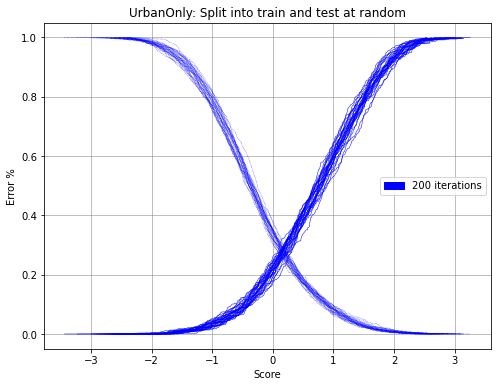

In [9]:
# Only for Urban Areas now
urban=True
area= 'Urban' if urban else 'Rural'
selector=df['urban']==urban
subData=D.get_subset(selector)
subD=DataSplitter(subData)

train_selector=np.random.rand(subData.shape[0]) > 0.3
Train=subD.get_subset(train_selector)
Test=subD.get_subset(~train_selector)

param['num_round']=200
log200=simple_bootstrap('xgb',Train,Test,param,ensemble_size=30)

styled_logs=[
    {   'log':log200,
        'style':['b:','b-'],
        'label':'200 iterations',
        'label_color':'b'
    }
]

_mean,_std=plot_scores(styled_logs,title=f'{area}Only: Split into train and test at random')

pickle_file=f'data/Checkpoint_{area}.pk'
Dump={'styled_logs':styled_logs,
     'tree':tree,
     'mean':_mean,
     'std':_std}
pkl.dump(Dump,open(pickle_file,'wb'))



[0]	train-error:0.32833	train-logloss:0.67340	train-auc:0.69765	train-f1:0.00000	eval-error:0.37121	eval-logloss:0.67798	eval-auc:0.65397	eval-f1:0.00000
[1]	train-error:0.30363	train-logloss:0.65654	train-auc:0.75193	train-f1:0.00000	eval-error:0.35419	eval-logloss:0.66564	eval-auc:0.69375	eval-f1:0.00000
[2]	train-error:0.29415	train-logloss:0.64293	train-auc:0.76605	train-f1:0.00074	eval-error:0.34729	eval-logloss:0.65563	eval-auc:0.70309	eval-f1:0.00170
[3]	train-error:0.29830	train-logloss:0.63116	train-auc:0.77824	train-f1:0.13703	eval-error:0.33349	eval-logloss:0.64737	eval-auc:0.71311	eval-f1:0.11950
[4]	train-error:0.27795	train-logloss:0.61807	train-auc:0.79451	train-f1:0.31072	eval-error:0.33073	eval-logloss:0.64019	eval-auc:0.72033	eval-f1:0.25378
[5]	train-error:0.27578	train-logloss:0.60805	train-auc:0.79794	train-f1:0.38464	eval-error:0.33165	eval-logloss:0.63527	eval-auc:0.71841	eval-f1:0.32520
[6]	train-error:0.26630	train-logloss:0.59931	train-auc:0.80674	train-f1:0.4

[53]	train-error:0.16337	train-logloss:0.43556	train-auc:0.91809	train-f1:0.80033	eval-error:0.29623	eval-logloss:0.58174	eval-auc:0.76256	eval-f1:0.65192
[54]	train-error:0.16179	train-logloss:0.43373	train-auc:0.91914	train-f1:0.80209	eval-error:0.29899	eval-logloss:0.58225	eval-auc:0.76197	eval-f1:0.65585
[55]	train-error:0.16021	train-logloss:0.43118	train-auc:0.92021	train-f1:0.80557	eval-error:0.29991	eval-logloss:0.58122	eval-auc:0.76306	eval-f1:0.65784
[56]	train-error:0.15863	train-logloss:0.42956	train-auc:0.92172	train-f1:0.80681	eval-error:0.29945	eval-logloss:0.58056	eval-auc:0.76368	eval-f1:0.65882
[57]	train-error:0.15626	train-logloss:0.42831	train-auc:0.92250	train-f1:0.80797	eval-error:0.30037	eval-logloss:0.58061	eval-auc:0.76351	eval-f1:0.65850
[58]	train-error:0.15705	train-logloss:0.42610	train-auc:0.92376	train-f1:0.81004	eval-error:0.29991	eval-logloss:0.58018	eval-auc:0.76392	eval-f1:0.66210
[59]	train-error:0.15745	train-logloss:0.42450	train-auc:0.92442	train

[106]	train-error:0.10036	train-logloss:0.34618	train-auc:0.96322	train-f1:0.86543	eval-error:0.28795	eval-logloss:0.57303	eval-auc:0.77297	eval-f1:0.68097
[107]	train-error:0.09976	train-logloss:0.34452	train-auc:0.96403	train-f1:0.86729	eval-error:0.28749	eval-logloss:0.57315	eval-auc:0.77296	eval-f1:0.67813
[108]	train-error:0.09878	train-logloss:0.34353	train-auc:0.96444	train-f1:0.86499	eval-error:0.28749	eval-logloss:0.57329	eval-auc:0.77283	eval-f1:0.67876
[109]	train-error:0.09581	train-logloss:0.34225	train-auc:0.96487	train-f1:0.86844	eval-error:0.29071	eval-logloss:0.57344	eval-auc:0.77264	eval-f1:0.67717
[110]	train-error:0.09561	train-logloss:0.34139	train-auc:0.96511	train-f1:0.86856	eval-error:0.28979	eval-logloss:0.57306	eval-auc:0.77300	eval-f1:0.67717
[111]	train-error:0.09542	train-logloss:0.34039	train-auc:0.96545	train-f1:0.86930	eval-error:0.28841	eval-logloss:0.57316	eval-auc:0.77282	eval-f1:0.67622
[112]	train-error:0.09680	train-logloss:0.33937	train-auc:0.9655

[159]	train-error:0.07112	train-logloss:0.28893	train-auc:0.98065	train-f1:0.90949	eval-error:0.29255	eval-logloss:0.57630	eval-auc:0.77315	eval-f1:0.69101
[160]	train-error:0.07072	train-logloss:0.28817	train-auc:0.98093	train-f1:0.91057	eval-error:0.28933	eval-logloss:0.57621	eval-auc:0.77334	eval-f1:0.69072
[161]	train-error:0.07033	train-logloss:0.28756	train-auc:0.98090	train-f1:0.91143	eval-error:0.29025	eval-logloss:0.57588	eval-auc:0.77380	eval-f1:0.69037
[162]	train-error:0.06974	train-logloss:0.28654	train-auc:0.98106	train-f1:0.91103	eval-error:0.29071	eval-logloss:0.57601	eval-auc:0.77376	eval-f1:0.69101
[163]	train-error:0.06974	train-logloss:0.28594	train-auc:0.98114	train-f1:0.91168	eval-error:0.28979	eval-logloss:0.57598	eval-auc:0.77392	eval-f1:0.69072
[164]	train-error:0.06855	train-logloss:0.28539	train-auc:0.98119	train-f1:0.91057	eval-error:0.29025	eval-logloss:0.57587	eval-auc:0.77403	eval-f1:0.69134
[165]	train-error:0.06855	train-logloss:0.28480	train-auc:0.9813

[12]	train-error:0.24911	train-logloss:0.56160	train-auc:0.83713	train-f1:0.64766	eval-error:0.32889	eval-logloss:0.61587	eval-auc:0.73380	eval-f1:0.56135
[13]	train-error:0.24595	train-logloss:0.55670	train-auc:0.84212	train-f1:0.66201	eval-error:0.32659	eval-logloss:0.61341	eval-auc:0.73672	eval-f1:0.57066
[14]	train-error:0.24141	train-logloss:0.55292	train-auc:0.84463	train-f1:0.66756	eval-error:0.32061	eval-logloss:0.61148	eval-auc:0.73870	eval-f1:0.58959
[15]	train-error:0.24180	train-logloss:0.54916	train-auc:0.84802	train-f1:0.68338	eval-error:0.31969	eval-logloss:0.60977	eval-auc:0.74046	eval-f1:0.59729
[16]	train-error:0.24496	train-logloss:0.54462	train-auc:0.85174	train-f1:0.69552	eval-error:0.31877	eval-logloss:0.60930	eval-auc:0.73985	eval-f1:0.60247
[17]	train-error:0.24101	train-logloss:0.54111	train-auc:0.85257	train-f1:0.70139	eval-error:0.32199	eval-logloss:0.60711	eval-auc:0.74151	eval-f1:0.60606
[18]	train-error:0.24062	train-logloss:0.53792	train-auc:0.85357	train

[65]	train-error:0.14599	train-logloss:0.41320	train-auc:0.93444	train-f1:0.82334	eval-error:0.28933	eval-logloss:0.57127	eval-auc:0.77241	eval-f1:0.68251
[66]	train-error:0.14263	train-logloss:0.41174	train-auc:0.93536	train-f1:0.82334	eval-error:0.28841	eval-logloss:0.57127	eval-auc:0.77239	eval-f1:0.68311
[67]	train-error:0.13848	train-logloss:0.40881	train-auc:0.93647	train-f1:0.82603	eval-error:0.29117	eval-logloss:0.57185	eval-auc:0.77170	eval-f1:0.68089
[68]	train-error:0.13750	train-logloss:0.40651	train-auc:0.93745	train-f1:0.82973	eval-error:0.28749	eval-logloss:0.57164	eval-auc:0.77178	eval-f1:0.67707
[69]	train-error:0.13710	train-logloss:0.40513	train-auc:0.93814	train-f1:0.83130	eval-error:0.28841	eval-logloss:0.57145	eval-auc:0.77187	eval-f1:0.67707
[70]	train-error:0.13592	train-logloss:0.40366	train-auc:0.93913	train-f1:0.83283	eval-error:0.28887	eval-logloss:0.57112	eval-auc:0.77228	eval-f1:0.67737
[71]	train-error:0.13315	train-logloss:0.40143	train-auc:0.94032	train

[118]	train-error:0.09976	train-logloss:0.34112	train-auc:0.96589	train-f1:0.87232	eval-error:0.29301	eval-logloss:0.56751	eval-auc:0.77633	eval-f1:0.68505
[119]	train-error:0.09660	train-logloss:0.33914	train-auc:0.96666	train-f1:0.87424	eval-error:0.29347	eval-logloss:0.56674	eval-auc:0.77720	eval-f1:0.68785
[120]	train-error:0.09759	train-logloss:0.33816	train-auc:0.96672	train-f1:0.87468	eval-error:0.29301	eval-logloss:0.56618	eval-auc:0.77792	eval-f1:0.69033
[121]	train-error:0.09720	train-logloss:0.33694	train-auc:0.96708	train-f1:0.87568	eval-error:0.29117	eval-logloss:0.56588	eval-auc:0.77838	eval-f1:0.69127
[122]	train-error:0.09443	train-logloss:0.33629	train-auc:0.96722	train-f1:0.87585	eval-error:0.28933	eval-logloss:0.56544	eval-auc:0.77872	eval-f1:0.69371
[123]	train-error:0.09482	train-logloss:0.33481	train-auc:0.96778	train-f1:0.87673	eval-error:0.28979	eval-logloss:0.56592	eval-auc:0.77813	eval-f1:0.69371
[124]	train-error:0.09463	train-logloss:0.33379	train-auc:0.9680

[171]	train-error:0.06835	train-logloss:0.28819	train-auc:0.98199	train-f1:0.91502	eval-error:0.29255	eval-logloss:0.57054	eval-auc:0.77681	eval-f1:0.69597
[172]	train-error:0.06815	train-logloss:0.28751	train-auc:0.98217	train-f1:0.91502	eval-error:0.29255	eval-logloss:0.57040	eval-auc:0.77692	eval-f1:0.69718
[173]	train-error:0.06796	train-logloss:0.28681	train-auc:0.98234	train-f1:0.91540	eval-error:0.29255	eval-logloss:0.57015	eval-auc:0.77719	eval-f1:0.69778
[174]	train-error:0.06756	train-logloss:0.28607	train-auc:0.98250	train-f1:0.91602	eval-error:0.29071	eval-logloss:0.57009	eval-auc:0.77736	eval-f1:0.69569
[175]	train-error:0.06776	train-logloss:0.28474	train-auc:0.98276	train-f1:0.91540	eval-error:0.29025	eval-logloss:0.57071	eval-auc:0.77705	eval-f1:0.69356
[176]	train-error:0.06717	train-logloss:0.28307	train-auc:0.98306	train-f1:0.91481	eval-error:0.29255	eval-logloss:0.57116	eval-auc:0.77679	eval-f1:0.69441
[177]	train-error:0.06638	train-logloss:0.28148	train-auc:0.9833

[24]	train-error:0.22422	train-logloss:0.51532	train-auc:0.86462	train-f1:0.70783	eval-error:0.31325	eval-logloss:0.59689	eval-auc:0.74647	eval-f1:0.61295
[25]	train-error:0.22086	train-logloss:0.51282	train-auc:0.86692	train-f1:0.70699	eval-error:0.31325	eval-logloss:0.59637	eval-auc:0.74745	eval-f1:0.61476
[26]	train-error:0.21691	train-logloss:0.50936	train-auc:0.87010	train-f1:0.71339	eval-error:0.31187	eval-logloss:0.59564	eval-auc:0.74829	eval-f1:0.61999
[27]	train-error:0.21691	train-logloss:0.50680	train-auc:0.87226	train-f1:0.71663	eval-error:0.31647	eval-logloss:0.59602	eval-auc:0.74748	eval-f1:0.62177
[28]	train-error:0.21098	train-logloss:0.50253	train-auc:0.87600	train-f1:0.72237	eval-error:0.31417	eval-logloss:0.59533	eval-auc:0.74803	eval-f1:0.62107
[29]	train-error:0.20822	train-logloss:0.49944	train-auc:0.87867	train-f1:0.72494	eval-error:0.31693	eval-logloss:0.59461	eval-auc:0.74924	eval-f1:0.62589
[30]	train-error:0.20802	train-logloss:0.49618	train-auc:0.88064	train

[77]	train-error:0.13967	train-logloss:0.40010	train-auc:0.93911	train-f1:0.81642	eval-error:0.29669	eval-logloss:0.57899	eval-auc:0.76552	eval-f1:0.68421
[78]	train-error:0.13888	train-logloss:0.39869	train-auc:0.93992	train-f1:0.81768	eval-error:0.29715	eval-logloss:0.57901	eval-auc:0.76562	eval-f1:0.68642
[79]	train-error:0.13631	train-logloss:0.39648	train-auc:0.94131	train-f1:0.81935	eval-error:0.29853	eval-logloss:0.57871	eval-auc:0.76577	eval-f1:0.68580
[80]	train-error:0.13809	train-logloss:0.39520	train-auc:0.94196	train-f1:0.81810	eval-error:0.29991	eval-logloss:0.57875	eval-auc:0.76569	eval-f1:0.68454
[81]	train-error:0.13572	train-logloss:0.39413	train-auc:0.94261	train-f1:0.81952	eval-error:0.29945	eval-logloss:0.57864	eval-auc:0.76582	eval-f1:0.68547
[82]	train-error:0.13236	train-logloss:0.39210	train-auc:0.94385	train-f1:0.82175	eval-error:0.30037	eval-logloss:0.57855	eval-auc:0.76574	eval-f1:0.68514
[83]	train-error:0.13177	train-logloss:0.39063	train-auc:0.94443	train

[130]	train-error:0.08929	train-logloss:0.32406	train-auc:0.97252	train-f1:0.87764	eval-error:0.29531	eval-logloss:0.57511	eval-auc:0.77178	eval-f1:0.70693
[131]	train-error:0.08830	train-logloss:0.32314	train-auc:0.97266	train-f1:0.87833	eval-error:0.29577	eval-logloss:0.57447	eval-auc:0.77232	eval-f1:0.70572
[132]	train-error:0.08870	train-logloss:0.32249	train-auc:0.97274	train-f1:0.87901	eval-error:0.29485	eval-logloss:0.57438	eval-auc:0.77240	eval-f1:0.70665
[133]	train-error:0.08811	train-logloss:0.32159	train-auc:0.97299	train-f1:0.87982	eval-error:0.29439	eval-logloss:0.57443	eval-auc:0.77243	eval-f1:0.70660
[134]	train-error:0.08692	train-logloss:0.32064	train-auc:0.97328	train-f1:0.88141	eval-error:0.29485	eval-logloss:0.57475	eval-auc:0.77215	eval-f1:0.70566
[135]	train-error:0.08633	train-logloss:0.31947	train-auc:0.97359	train-f1:0.88272	eval-error:0.29347	eval-logloss:0.57514	eval-auc:0.77181	eval-f1:0.70621
[136]	train-error:0.08455	train-logloss:0.31835	train-auc:0.9740

[183]	train-error:0.06223	train-logloss:0.27314	train-auc:0.98628	train-f1:0.91231	eval-error:0.29669	eval-logloss:0.57923	eval-auc:0.77155	eval-f1:0.70654
[184]	train-error:0.06282	train-logloss:0.27269	train-auc:0.98642	train-f1:0.91274	eval-error:0.29531	eval-logloss:0.57905	eval-auc:0.77170	eval-f1:0.70686
[185]	train-error:0.06164	train-logloss:0.27098	train-auc:0.98696	train-f1:0.91342	eval-error:0.29761	eval-logloss:0.57959	eval-auc:0.77127	eval-f1:0.70681
[186]	train-error:0.06005	train-logloss:0.26998	train-auc:0.98723	train-f1:0.91397	eval-error:0.29531	eval-logloss:0.57958	eval-auc:0.77139	eval-f1:0.70621
[187]	train-error:0.06005	train-logloss:0.26878	train-auc:0.98740	train-f1:0.91605	eval-error:0.29393	eval-logloss:0.58005	eval-auc:0.77114	eval-f1:0.70708
[188]	train-error:0.05847	train-logloss:0.26736	train-auc:0.98750	train-f1:0.91692	eval-error:0.29071	eval-logloss:0.58047	eval-auc:0.77121	eval-f1:0.70594
[189]	train-error:0.05867	train-logloss:0.26684	train-auc:0.9876

[36]	train-error:0.19182	train-logloss:0.48183	train-auc:0.89375	train-f1:0.75353	eval-error:0.30819	eval-logloss:0.58719	eval-auc:0.75975	eval-f1:0.62087
[37]	train-error:0.18866	train-logloss:0.47842	train-auc:0.89628	train-f1:0.76304	eval-error:0.30635	eval-logloss:0.58703	eval-auc:0.75951	eval-f1:0.61976
[38]	train-error:0.18925	train-logloss:0.47634	train-auc:0.89814	train-f1:0.76263	eval-error:0.30819	eval-logloss:0.58677	eval-auc:0.75988	eval-f1:0.62268
[39]	train-error:0.18906	train-logloss:0.47447	train-auc:0.89976	train-f1:0.76587	eval-error:0.30727	eval-logloss:0.58649	eval-auc:0.76023	eval-f1:0.62384
[40]	train-error:0.18570	train-logloss:0.47178	train-auc:0.90209	train-f1:0.76487	eval-error:0.30773	eval-logloss:0.58569	eval-auc:0.76119	eval-f1:0.62622
[41]	train-error:0.18491	train-logloss:0.47047	train-auc:0.90281	train-f1:0.76762	eval-error:0.30221	eval-logloss:0.58522	eval-auc:0.76146	eval-f1:0.62584
[42]	train-error:0.18491	train-logloss:0.46782	train-auc:0.90462	train

[89]	train-error:0.11853	train-logloss:0.38219	train-auc:0.95241	train-f1:0.84131	eval-error:0.29715	eval-logloss:0.57128	eval-auc:0.77287	eval-f1:0.65614
[90]	train-error:0.11794	train-logloss:0.38101	train-auc:0.95277	train-f1:0.84059	eval-error:0.29531	eval-logloss:0.57146	eval-auc:0.77280	eval-f1:0.65747
[91]	train-error:0.11754	train-logloss:0.38007	train-auc:0.95315	train-f1:0.84083	eval-error:0.29439	eval-logloss:0.57087	eval-auc:0.77332	eval-f1:0.65945
[92]	train-error:0.11715	train-logloss:0.37749	train-auc:0.95375	train-f1:0.84430	eval-error:0.29439	eval-logloss:0.57073	eval-auc:0.77366	eval-f1:0.66406
[93]	train-error:0.11675	train-logloss:0.37609	train-auc:0.95441	train-f1:0.84548	eval-error:0.29117	eval-logloss:0.57050	eval-auc:0.77399	eval-f1:0.66341
[94]	train-error:0.11774	train-logloss:0.37472	train-auc:0.95466	train-f1:0.84644	eval-error:0.29117	eval-logloss:0.57053	eval-auc:0.77390	eval-f1:0.66602
[95]	train-error:0.11399	train-logloss:0.37273	train-auc:0.95562	train

[142]	train-error:0.08139	train-logloss:0.31505	train-auc:0.97615	train-f1:0.89216	eval-error:0.29531	eval-logloss:0.56778	eval-auc:0.77665	eval-f1:0.67651
[143]	train-error:0.08100	train-logloss:0.31420	train-auc:0.97642	train-f1:0.89216	eval-error:0.29531	eval-logloss:0.56811	eval-auc:0.77632	eval-f1:0.67682
[144]	train-error:0.08060	train-logloss:0.31344	train-auc:0.97650	train-f1:0.89269	eval-error:0.29669	eval-logloss:0.56817	eval-auc:0.77631	eval-f1:0.67714
[145]	train-error:0.07922	train-logloss:0.31283	train-auc:0.97662	train-f1:0.89363	eval-error:0.29853	eval-logloss:0.56918	eval-auc:0.77551	eval-f1:0.67430
[146]	train-error:0.07843	train-logloss:0.31151	train-auc:0.97708	train-f1:0.89474	eval-error:0.29761	eval-logloss:0.56892	eval-auc:0.77586	eval-f1:0.67397
[147]	train-error:0.07803	train-logloss:0.31000	train-auc:0.97748	train-f1:0.89590	eval-error:0.29715	eval-logloss:0.56949	eval-auc:0.77537	eval-f1:0.67523
[148]	train-error:0.07784	train-logloss:0.30958	train-auc:0.9776

[195]	train-error:0.05275	train-logloss:0.27085	train-auc:0.98708	train-f1:0.91775	eval-error:0.30129	eval-logloss:0.57262	eval-auc:0.77480	eval-f1:0.67423
[196]	train-error:0.05176	train-logloss:0.26976	train-auc:0.98730	train-f1:0.91879	eval-error:0.30129	eval-logloss:0.57223	eval-auc:0.77527	eval-f1:0.67390
[197]	train-error:0.05215	train-logloss:0.26926	train-auc:0.98746	train-f1:0.91940	eval-error:0.30083	eval-logloss:0.57215	eval-auc:0.77536	eval-f1:0.67390
[198]	train-error:0.05215	train-logloss:0.26804	train-auc:0.98754	train-f1:0.92092	eval-error:0.29853	eval-logloss:0.57242	eval-auc:0.77527	eval-f1:0.67578
[199]	train-error:0.05176	train-logloss:0.26746	train-auc:0.98760	train-f1:0.92114	eval-error:0.29807	eval-logloss:0.57269	eval-auc:0.77509	eval-f1:0.67608
[0]	train-error:0.35460	train-logloss:0.67472	train-auc:0.69628	train-f1:0.00000	eval-error:0.39420	eval-logloss:0.68021	eval-auc:0.64017	eval-f1:0.00000
[1]	train-error:0.31332	train-logloss:0.65723	train-auc:0.74014	tr

[48]	train-error:0.17661	train-logloss:0.44416	train-auc:0.91340	train-f1:0.80286	eval-error:0.30635	eval-logloss:0.57937	eval-auc:0.76218	eval-f1:0.66858
[49]	train-error:0.17404	train-logloss:0.44197	train-auc:0.91525	train-f1:0.80817	eval-error:0.30727	eval-logloss:0.57946	eval-auc:0.76197	eval-f1:0.66858
[50]	train-error:0.17286	train-logloss:0.43952	train-auc:0.91663	train-f1:0.81121	eval-error:0.30773	eval-logloss:0.57895	eval-auc:0.76267	eval-f1:0.66635
[51]	train-error:0.17207	train-logloss:0.43739	train-auc:0.91799	train-f1:0.81187	eval-error:0.30819	eval-logloss:0.57873	eval-auc:0.76275	eval-f1:0.66476
[52]	train-error:0.16950	train-logloss:0.43563	train-auc:0.91905	train-f1:0.81325	eval-error:0.30773	eval-logloss:0.57874	eval-auc:0.76245	eval-f1:0.66094
[53]	train-error:0.16871	train-logloss:0.43403	train-auc:0.91955	train-f1:0.81283	eval-error:0.30589	eval-logloss:0.57834	eval-auc:0.76280	eval-f1:0.66539
[54]	train-error:0.16891	train-logloss:0.43214	train-auc:0.92077	train

[101]	train-error:0.11201	train-logloss:0.35305	train-auc:0.95919	train-f1:0.87137	eval-error:0.29669	eval-logloss:0.56930	eval-auc:0.77255	eval-f1:0.67728
[102]	train-error:0.11083	train-logloss:0.35189	train-auc:0.95976	train-f1:0.87332	eval-error:0.29899	eval-logloss:0.56949	eval-auc:0.77247	eval-f1:0.67635
[103]	train-error:0.10944	train-logloss:0.35094	train-auc:0.96015	train-f1:0.87315	eval-error:0.29945	eval-logloss:0.56979	eval-auc:0.77217	eval-f1:0.67633
[104]	train-error:0.10964	train-logloss:0.34965	train-auc:0.96075	train-f1:0.87687	eval-error:0.30037	eval-logloss:0.56935	eval-auc:0.77242	eval-f1:0.67728
[105]	train-error:0.10964	train-logloss:0.34828	train-auc:0.96154	train-f1:0.87655	eval-error:0.30037	eval-logloss:0.56937	eval-auc:0.77237	eval-f1:0.67822
[106]	train-error:0.10924	train-logloss:0.34745	train-auc:0.96177	train-f1:0.87789	eval-error:0.29899	eval-logloss:0.56961	eval-auc:0.77221	eval-f1:0.67854
[107]	train-error:0.10668	train-logloss:0.34586	train-auc:0.9621

[154]	train-error:0.06895	train-logloss:0.28753	train-auc:0.98173	train-f1:0.91201	eval-error:0.29991	eval-logloss:0.56860	eval-auc:0.77589	eval-f1:0.68808
[155]	train-error:0.06855	train-logloss:0.28670	train-auc:0.98191	train-f1:0.91155	eval-error:0.29991	eval-logloss:0.56861	eval-auc:0.77599	eval-f1:0.68776
[156]	train-error:0.06776	train-logloss:0.28570	train-auc:0.98206	train-f1:0.91190	eval-error:0.29899	eval-logloss:0.56922	eval-auc:0.77544	eval-f1:0.68834
[157]	train-error:0.06697	train-logloss:0.28458	train-auc:0.98244	train-f1:0.91329	eval-error:0.29715	eval-logloss:0.56949	eval-auc:0.77519	eval-f1:0.69013
[158]	train-error:0.06539	train-logloss:0.28373	train-auc:0.98260	train-f1:0.91400	eval-error:0.29669	eval-logloss:0.56945	eval-auc:0.77532	eval-f1:0.69077
[159]	train-error:0.06559	train-logloss:0.28255	train-auc:0.98288	train-f1:0.91463	eval-error:0.29485	eval-logloss:0.56912	eval-auc:0.77580	eval-f1:0.68956
[160]	train-error:0.06322	train-logloss:0.28130	train-auc:0.9832

[7]	train-error:0.27459	train-logloss:0.59703	train-auc:0.81087	train-f1:0.55080	eval-error:0.34039	eval-logloss:0.63212	eval-auc:0.71413	eval-f1:0.44603
[8]	train-error:0.26689	train-logloss:0.58969	train-auc:0.81434	train-f1:0.58407	eval-error:0.33579	eval-logloss:0.62790	eval-auc:0.71755	eval-f1:0.48446
[9]	train-error:0.26748	train-logloss:0.58215	train-auc:0.81806	train-f1:0.61268	eval-error:0.33119	eval-logloss:0.62329	eval-auc:0.72171	eval-f1:0.51975
[10]	train-error:0.26096	train-logloss:0.57598	train-auc:0.82191	train-f1:0.63180	eval-error:0.33211	eval-logloss:0.62082	eval-auc:0.72345	eval-f1:0.52782
[11]	train-error:0.25622	train-logloss:0.57069	train-auc:0.82784	train-f1:0.63767	eval-error:0.32843	eval-logloss:0.61673	eval-auc:0.73028	eval-f1:0.54684
[12]	train-error:0.25622	train-logloss:0.56678	train-auc:0.83198	train-f1:0.64339	eval-error:0.32705	eval-logloss:0.61495	eval-auc:0.73247	eval-f1:0.55098
[13]	train-error:0.25622	train-logloss:0.56278	train-auc:0.83343	train-f1

[60]	train-error:0.16021	train-logloss:0.43084	train-auc:0.92541	train-f1:0.81451	eval-error:0.29945	eval-logloss:0.57907	eval-auc:0.76297	eval-f1:0.66118
[61]	train-error:0.15903	train-logloss:0.42867	train-auc:0.92689	train-f1:0.81648	eval-error:0.29853	eval-logloss:0.57885	eval-auc:0.76322	eval-f1:0.66183
[62]	train-error:0.15942	train-logloss:0.42716	train-auc:0.92743	train-f1:0.81605	eval-error:0.29899	eval-logloss:0.57908	eval-auc:0.76277	eval-f1:0.65926
[63]	train-error:0.15527	train-logloss:0.42419	train-auc:0.92904	train-f1:0.81909	eval-error:0.29623	eval-logloss:0.57765	eval-auc:0.76413	eval-f1:0.66277
[64]	train-error:0.15192	train-logloss:0.42152	train-auc:0.93102	train-f1:0.81894	eval-error:0.29669	eval-logloss:0.57822	eval-auc:0.76346	eval-f1:0.65757
[65]	train-error:0.15034	train-logloss:0.41936	train-auc:0.93229	train-f1:0.82009	eval-error:0.29623	eval-logloss:0.57766	eval-auc:0.76396	eval-f1:0.66051
[66]	train-error:0.15132	train-logloss:0.41828	train-auc:0.93278	train

[113]	train-error:0.09759	train-logloss:0.34332	train-auc:0.96691	train-f1:0.87497	eval-error:0.29485	eval-logloss:0.57032	eval-auc:0.77321	eval-f1:0.68371
[114]	train-error:0.09759	train-logloss:0.34245	train-auc:0.96730	train-f1:0.87606	eval-error:0.29439	eval-logloss:0.57061	eval-auc:0.77321	eval-f1:0.68406
[115]	train-error:0.09502	train-logloss:0.34062	train-auc:0.96844	train-f1:0.87714	eval-error:0.29209	eval-logloss:0.57118	eval-auc:0.77287	eval-f1:0.68404
[116]	train-error:0.09680	train-logloss:0.33882	train-auc:0.96898	train-f1:0.87731	eval-error:0.29163	eval-logloss:0.57096	eval-auc:0.77322	eval-f1:0.68276
[117]	train-error:0.09621	train-logloss:0.33802	train-auc:0.96934	train-f1:0.87754	eval-error:0.29117	eval-logloss:0.57118	eval-auc:0.77319	eval-f1:0.68244
[118]	train-error:0.09621	train-logloss:0.33610	train-auc:0.96961	train-f1:0.87859	eval-error:0.29071	eval-logloss:0.57091	eval-auc:0.77368	eval-f1:0.68371
[119]	train-error:0.09542	train-logloss:0.33484	train-auc:0.9702

[166]	train-error:0.06322	train-logloss:0.28395	train-auc:0.98451	train-f1:0.91155	eval-error:0.28979	eval-logloss:0.57385	eval-auc:0.77399	eval-f1:0.68785
[167]	train-error:0.06302	train-logloss:0.28336	train-auc:0.98466	train-f1:0.91322	eval-error:0.28887	eval-logloss:0.57412	eval-auc:0.77395	eval-f1:0.68849
[168]	train-error:0.06262	train-logloss:0.28255	train-auc:0.98480	train-f1:0.91365	eval-error:0.28749	eval-logloss:0.57420	eval-auc:0.77388	eval-f1:0.69033
[169]	train-error:0.06262	train-logloss:0.28119	train-auc:0.98513	train-f1:0.91517	eval-error:0.28841	eval-logloss:0.57469	eval-auc:0.77358	eval-f1:0.68972
[170]	train-error:0.06085	train-logloss:0.28044	train-auc:0.98547	train-f1:0.91492	eval-error:0.28979	eval-logloss:0.57475	eval-auc:0.77372	eval-f1:0.69098
[171]	train-error:0.06045	train-logloss:0.27955	train-auc:0.98573	train-f1:0.91496	eval-error:0.28933	eval-logloss:0.57488	eval-auc:0.77373	eval-f1:0.68972
[172]	train-error:0.06124	train-logloss:0.27875	train-auc:0.9858

[19]	train-error:0.22778	train-logloss:0.53353	train-auc:0.85021	train-f1:0.72945	eval-error:0.30727	eval-logloss:0.60013	eval-auc:0.74310	eval-f1:0.61117
[20]	train-error:0.22620	train-logloss:0.53102	train-auc:0.85187	train-f1:0.72762	eval-error:0.30773	eval-logloss:0.59945	eval-auc:0.74347	eval-f1:0.61332
[21]	train-error:0.22540	train-logloss:0.52765	train-auc:0.85437	train-f1:0.73199	eval-error:0.30635	eval-logloss:0.59828	eval-auc:0.74478	eval-f1:0.61860
[22]	train-error:0.22244	train-logloss:0.52341	train-auc:0.85821	train-f1:0.73540	eval-error:0.30635	eval-logloss:0.59799	eval-auc:0.74478	eval-f1:0.61446
[23]	train-error:0.22303	train-logloss:0.51961	train-auc:0.85990	train-f1:0.73834	eval-error:0.30819	eval-logloss:0.59637	eval-auc:0.74571	eval-f1:0.61919
[24]	train-error:0.21889	train-logloss:0.51722	train-auc:0.86202	train-f1:0.74238	eval-error:0.30635	eval-logloss:0.59435	eval-auc:0.74814	eval-f1:0.62537
[25]	train-error:0.21730	train-logloss:0.51409	train-auc:0.86480	train

[72]	train-error:0.14718	train-logloss:0.41134	train-auc:0.93264	train-f1:0.83391	eval-error:0.28979	eval-logloss:0.57520	eval-auc:0.76707	eval-f1:0.66604
[73]	train-error:0.14678	train-logloss:0.41002	train-auc:0.93287	train-f1:0.83391	eval-error:0.28979	eval-logloss:0.57515	eval-auc:0.76711	eval-f1:0.66698
[74]	train-error:0.14461	train-logloss:0.40876	train-auc:0.93341	train-f1:0.83316	eval-error:0.28979	eval-logloss:0.57527	eval-auc:0.76685	eval-f1:0.66604
[75]	train-error:0.14125	train-logloss:0.40618	train-auc:0.93476	train-f1:0.83868	eval-error:0.28887	eval-logloss:0.57470	eval-auc:0.76733	eval-f1:0.66855
[76]	train-error:0.14105	train-logloss:0.40398	train-auc:0.93601	train-f1:0.83851	eval-error:0.28979	eval-logloss:0.57482	eval-auc:0.76707	eval-f1:0.66792
[77]	train-error:0.14105	train-logloss:0.40213	train-auc:0.93727	train-f1:0.84104	eval-error:0.28933	eval-logloss:0.57482	eval-auc:0.76700	eval-f1:0.67200
[78]	train-error:0.13987	train-logloss:0.40038	train-auc:0.93829	train

[125]	train-error:0.09878	train-logloss:0.33316	train-auc:0.96631	train-f1:0.88810	eval-error:0.28887	eval-logloss:0.57023	eval-auc:0.77425	eval-f1:0.69484
[126]	train-error:0.09700	train-logloss:0.33184	train-auc:0.96685	train-f1:0.88797	eval-error:0.29071	eval-logloss:0.57004	eval-auc:0.77438	eval-f1:0.69234
[127]	train-error:0.09561	train-logloss:0.33106	train-auc:0.96716	train-f1:0.88823	eval-error:0.29163	eval-logloss:0.57041	eval-auc:0.77416	eval-f1:0.69202
[128]	train-error:0.09502	train-logloss:0.33008	train-auc:0.96751	train-f1:0.88845	eval-error:0.29163	eval-logloss:0.57004	eval-auc:0.77443	eval-f1:0.69142
[129]	train-error:0.09364	train-logloss:0.32902	train-auc:0.96790	train-f1:0.88994	eval-error:0.29117	eval-logloss:0.57000	eval-auc:0.77462	eval-f1:0.69327
[130]	train-error:0.09285	train-logloss:0.32811	train-auc:0.96821	train-f1:0.89016	eval-error:0.29071	eval-logloss:0.57013	eval-auc:0.77462	eval-f1:0.69323
[131]	train-error:0.09226	train-logloss:0.32723	train-auc:0.9685

[178]	train-error:0.06776	train-logloss:0.27976	train-auc:0.98290	train-f1:0.91719	eval-error:0.28703	eval-logloss:0.56884	eval-auc:0.77811	eval-f1:0.70610
[179]	train-error:0.06657	train-logloss:0.27854	train-auc:0.98308	train-f1:0.91728	eval-error:0.28611	eval-logloss:0.56884	eval-auc:0.77815	eval-f1:0.70707
[180]	train-error:0.06638	train-logloss:0.27718	train-auc:0.98338	train-f1:0.91791	eval-error:0.28749	eval-logloss:0.56885	eval-auc:0.77828	eval-f1:0.70793
[181]	train-error:0.06657	train-logloss:0.27679	train-auc:0.98346	train-f1:0.91791	eval-error:0.28749	eval-logloss:0.56879	eval-auc:0.77836	eval-f1:0.70885
[182]	train-error:0.06559	train-logloss:0.27533	train-auc:0.98391	train-f1:0.91856	eval-error:0.28749	eval-logloss:0.56952	eval-auc:0.77788	eval-f1:0.71030
[183]	train-error:0.06559	train-logloss:0.27436	train-auc:0.98406	train-f1:0.91853	eval-error:0.28703	eval-logloss:0.56992	eval-auc:0.77766	eval-f1:0.71056
[184]	train-error:0.06539	train-logloss:0.27369	train-auc:0.9841

[31]	train-error:0.19992	train-logloss:0.49602	train-auc:0.88602	train-f1:0.73545	eval-error:0.30175	eval-logloss:0.58942	eval-auc:0.75797	eval-f1:0.63437
[32]	train-error:0.19676	train-logloss:0.49298	train-auc:0.88705	train-f1:0.73721	eval-error:0.29853	eval-logloss:0.58742	eval-auc:0.75996	eval-f1:0.63840
[33]	train-error:0.19399	train-logloss:0.48838	train-auc:0.89113	train-f1:0.74438	eval-error:0.29761	eval-logloss:0.58629	eval-auc:0.76118	eval-f1:0.64140
[34]	train-error:0.19261	train-logloss:0.48612	train-auc:0.89239	train-f1:0.74656	eval-error:0.29623	eval-logloss:0.58589	eval-auc:0.76100	eval-f1:0.64449
[35]	train-error:0.19103	train-logloss:0.48392	train-auc:0.89364	train-f1:0.74866	eval-error:0.29439	eval-logloss:0.58442	eval-auc:0.76268	eval-f1:0.64878
[36]	train-error:0.18866	train-logloss:0.48219	train-auc:0.89457	train-f1:0.74651	eval-error:0.29301	eval-logloss:0.58326	eval-auc:0.76378	eval-f1:0.64948
[37]	train-error:0.18925	train-logloss:0.47989	train-auc:0.89568	train

[84]	train-error:0.13552	train-logloss:0.39025	train-auc:0.94867	train-f1:0.83790	eval-error:0.28519	eval-logloss:0.56806	eval-auc:0.77631	eval-f1:0.68705
[85]	train-error:0.13433	train-logloss:0.38821	train-auc:0.94961	train-f1:0.83916	eval-error:0.28703	eval-logloss:0.56782	eval-auc:0.77639	eval-f1:0.68672
[86]	train-error:0.13177	train-logloss:0.38584	train-auc:0.95128	train-f1:0.84053	eval-error:0.28703	eval-logloss:0.56778	eval-auc:0.77654	eval-f1:0.68705
[87]	train-error:0.13117	train-logloss:0.38375	train-auc:0.95213	train-f1:0.84213	eval-error:0.28703	eval-logloss:0.56709	eval-auc:0.77721	eval-f1:0.68801
[88]	train-error:0.13019	train-logloss:0.38280	train-auc:0.95246	train-f1:0.84152	eval-error:0.28703	eval-logloss:0.56676	eval-auc:0.77755	eval-f1:0.68956
[89]	train-error:0.12979	train-logloss:0.38065	train-auc:0.95367	train-f1:0.84420	eval-error:0.28703	eval-logloss:0.56731	eval-auc:0.77709	eval-f1:0.68956
[90]	train-error:0.12920	train-logloss:0.37770	train-auc:0.95493	train

[137]	train-error:0.07369	train-logloss:0.31474	train-auc:0.97751	train-f1:0.88805	eval-error:0.27691	eval-logloss:0.56291	eval-auc:0.78181	eval-f1:0.69846
[138]	train-error:0.07270	train-logloss:0.31306	train-auc:0.97817	train-f1:0.88805	eval-error:0.27783	eval-logloss:0.56256	eval-auc:0.78218	eval-f1:0.69761
[139]	train-error:0.07408	train-logloss:0.31170	train-auc:0.97854	train-f1:0.89074	eval-error:0.27691	eval-logloss:0.56212	eval-auc:0.78265	eval-f1:0.69911
[140]	train-error:0.07467	train-logloss:0.31006	train-auc:0.97907	train-f1:0.89277	eval-error:0.27553	eval-logloss:0.56202	eval-auc:0.78263	eval-f1:0.69850
[141]	train-error:0.07230	train-logloss:0.30817	train-auc:0.97972	train-f1:0.89603	eval-error:0.27737	eval-logloss:0.56255	eval-auc:0.78224	eval-f1:0.69846
[142]	train-error:0.07092	train-logloss:0.30656	train-auc:0.98040	train-f1:0.89459	eval-error:0.27783	eval-logloss:0.56267	eval-auc:0.78222	eval-f1:0.69883
[143]	train-error:0.07053	train-logloss:0.30554	train-auc:0.9807

[190]	train-error:0.05156	train-logloss:0.26230	train-auc:0.98982	train-f1:0.92236	eval-error:0.27921	eval-logloss:0.56710	eval-auc:0.78097	eval-f1:0.70637
[191]	train-error:0.05038	train-logloss:0.26185	train-auc:0.98993	train-f1:0.92293	eval-error:0.27875	eval-logloss:0.56707	eval-auc:0.78105	eval-f1:0.70697
[192]	train-error:0.05077	train-logloss:0.26110	train-auc:0.99002	train-f1:0.92314	eval-error:0.27691	eval-logloss:0.56719	eval-auc:0.78120	eval-f1:0.70756
[193]	train-error:0.05077	train-logloss:0.26043	train-auc:0.99017	train-f1:0.92293	eval-error:0.27737	eval-logloss:0.56730	eval-auc:0.78117	eval-f1:0.70572
[194]	train-error:0.04879	train-logloss:0.25912	train-auc:0.99033	train-f1:0.92311	eval-error:0.27783	eval-logloss:0.56737	eval-auc:0.78137	eval-f1:0.70783
[195]	train-error:0.04820	train-logloss:0.25802	train-auc:0.99056	train-f1:0.92314	eval-error:0.27691	eval-logloss:0.56704	eval-auc:0.78175	eval-f1:0.70849
[196]	train-error:0.04820	train-logloss:0.25757	train-auc:0.9906

[43]	train-error:0.18886	train-logloss:0.46972	train-auc:0.89813	train-f1:0.77813	eval-error:0.29393	eval-logloss:0.58209	eval-auc:0.76256	eval-f1:0.65487
[44]	train-error:0.18925	train-logloss:0.46774	train-auc:0.89897	train-f1:0.77790	eval-error:0.29163	eval-logloss:0.58078	eval-auc:0.76385	eval-f1:0.65521
[45]	train-error:0.18609	train-logloss:0.46478	train-auc:0.90139	train-f1:0.78199	eval-error:0.28979	eval-logloss:0.58086	eval-auc:0.76367	eval-f1:0.65783
[46]	train-error:0.18194	train-logloss:0.46184	train-auc:0.90446	train-f1:0.78619	eval-error:0.28841	eval-logloss:0.58009	eval-auc:0.76481	eval-f1:0.66307
[47]	train-error:0.17957	train-logloss:0.45929	train-auc:0.90669	train-f1:0.79096	eval-error:0.29025	eval-logloss:0.57912	eval-auc:0.76613	eval-f1:0.66341
[48]	train-error:0.17681	train-logloss:0.45613	train-auc:0.90862	train-f1:0.79533	eval-error:0.28887	eval-logloss:0.57857	eval-auc:0.76663	eval-f1:0.66569
[49]	train-error:0.17780	train-logloss:0.45476	train-auc:0.90887	train

[96]	train-error:0.12624	train-logloss:0.37588	train-auc:0.95107	train-f1:0.84915	eval-error:0.28473	eval-logloss:0.56940	eval-auc:0.77506	eval-f1:0.68164
[97]	train-error:0.12465	train-logloss:0.37390	train-auc:0.95220	train-f1:0.85003	eval-error:0.28335	eval-logloss:0.56872	eval-auc:0.77591	eval-f1:0.68101
[98]	train-error:0.12149	train-logloss:0.37286	train-auc:0.95285	train-f1:0.85062	eval-error:0.28335	eval-logloss:0.56872	eval-auc:0.77592	eval-f1:0.68167
[99]	train-error:0.12209	train-logloss:0.37127	train-auc:0.95328	train-f1:0.85365	eval-error:0.28059	eval-logloss:0.56848	eval-auc:0.77637	eval-f1:0.68386
[100]	train-error:0.12051	train-logloss:0.37035	train-auc:0.95379	train-f1:0.85400	eval-error:0.28151	eval-logloss:0.56811	eval-auc:0.77667	eval-f1:0.68481
[101]	train-error:0.11814	train-logloss:0.36935	train-auc:0.95430	train-f1:0.85662	eval-error:0.27921	eval-logloss:0.56812	eval-auc:0.77663	eval-f1:0.68481
[102]	train-error:0.11794	train-logloss:0.36822	train-auc:0.95484	tr

[149]	train-error:0.07941	train-logloss:0.31188	train-auc:0.97563	train-f1:0.89238	eval-error:0.27875	eval-logloss:0.56481	eval-auc:0.78023	eval-f1:0.69405
[150]	train-error:0.07784	train-logloss:0.31088	train-auc:0.97605	train-f1:0.89181	eval-error:0.28151	eval-logloss:0.56455	eval-auc:0.78041	eval-f1:0.69475
[151]	train-error:0.07645	train-logloss:0.30976	train-auc:0.97638	train-f1:0.89485	eval-error:0.28197	eval-logloss:0.56531	eval-auc:0.77980	eval-f1:0.69500
[152]	train-error:0.07744	train-logloss:0.30900	train-auc:0.97654	train-f1:0.89547	eval-error:0.28197	eval-logloss:0.56547	eval-auc:0.77990	eval-f1:0.69249
[153]	train-error:0.07764	train-logloss:0.30825	train-auc:0.97670	train-f1:0.89547	eval-error:0.27967	eval-logloss:0.56579	eval-auc:0.77968	eval-f1:0.69434
[154]	train-error:0.07665	train-logloss:0.30748	train-auc:0.97701	train-f1:0.89600	eval-error:0.27967	eval-logloss:0.56528	eval-auc:0.78020	eval-f1:0.69532
[155]	train-error:0.07665	train-logloss:0.30653	train-auc:0.9771

[2]	train-error:0.30798	train-logloss:0.64638	train-auc:0.74965	train-f1:0.01308	eval-error:0.36247	eval-logloss:0.66267	eval-auc:0.66985	eval-f1:0.00509
[3]	train-error:0.29198	train-logloss:0.63484	train-auc:0.77063	train-f1:0.00073	eval-error:0.35419	eval-logloss:0.65574	eval-auc:0.68247	eval-f1:0.00509
[4]	train-error:0.27736	train-logloss:0.62301	train-auc:0.78428	train-f1:0.15173	eval-error:0.33257	eval-logloss:0.64756	eval-auc:0.69739	eval-f1:0.13406
[5]	train-error:0.27736	train-logloss:0.61330	train-auc:0.79505	train-f1:0.36194	eval-error:0.34729	eval-logloss:0.64292	eval-auc:0.70140	eval-f1:0.30905
[6]	train-error:0.27677	train-logloss:0.60591	train-auc:0.79997	train-f1:0.43512	eval-error:0.34775	eval-logloss:0.63704	eval-auc:0.70945	eval-f1:0.39340
[7]	train-error:0.26610	train-logloss:0.59881	train-auc:0.80435	train-f1:0.53243	eval-error:0.33211	eval-logloss:0.63324	eval-auc:0.71242	eval-f1:0.47292
[8]	train-error:0.26432	train-logloss:0.59102	train-auc:0.81405	train-f1:0.5

[55]	train-error:0.16515	train-logloss:0.43588	train-auc:0.92351	train-f1:0.81732	eval-error:0.28933	eval-logloss:0.57220	eval-auc:0.77271	eval-f1:0.67964
[56]	train-error:0.16634	train-logloss:0.43465	train-auc:0.92376	train-f1:0.81798	eval-error:0.28979	eval-logloss:0.57207	eval-auc:0.77262	eval-f1:0.68027
[57]	train-error:0.16357	train-logloss:0.43300	train-auc:0.92456	train-f1:0.81790	eval-error:0.28933	eval-logloss:0.57149	eval-auc:0.77324	eval-f1:0.68498
[58]	train-error:0.16258	train-logloss:0.43094	train-auc:0.92609	train-f1:0.81842	eval-error:0.28749	eval-logloss:0.57140	eval-auc:0.77324	eval-f1:0.68311
[59]	train-error:0.16219	train-logloss:0.42819	train-auc:0.92789	train-f1:0.81869	eval-error:0.28703	eval-logloss:0.57124	eval-auc:0.77340	eval-f1:0.68216
[60]	train-error:0.16120	train-logloss:0.42623	train-auc:0.92897	train-f1:0.81969	eval-error:0.28657	eval-logloss:0.57098	eval-auc:0.77341	eval-f1:0.68304
[61]	train-error:0.15883	train-logloss:0.42456	train-auc:0.93015	train

[108]	train-error:0.10253	train-logloss:0.34977	train-auc:0.96616	train-f1:0.87372	eval-error:0.29807	eval-logloss:0.56593	eval-auc:0.77538	eval-f1:0.67734
[109]	train-error:0.10213	train-logloss:0.34893	train-auc:0.96635	train-f1:0.87418	eval-error:0.29853	eval-logloss:0.56693	eval-auc:0.77441	eval-f1:0.67610
[110]	train-error:0.10075	train-logloss:0.34807	train-auc:0.96654	train-f1:0.87415	eval-error:0.29807	eval-logloss:0.56649	eval-auc:0.77477	eval-f1:0.67797
[111]	train-error:0.09897	train-logloss:0.34604	train-auc:0.96783	train-f1:0.87430	eval-error:0.29669	eval-logloss:0.56664	eval-auc:0.77482	eval-f1:0.67671
[112]	train-error:0.09878	train-logloss:0.34488	train-auc:0.96823	train-f1:0.87510	eval-error:0.29623	eval-logloss:0.56640	eval-auc:0.77506	eval-f1:0.67639
[113]	train-error:0.09739	train-logloss:0.34339	train-auc:0.96864	train-f1:0.87533	eval-error:0.29577	eval-logloss:0.56624	eval-auc:0.77511	eval-f1:0.67637
[114]	train-error:0.09759	train-logloss:0.34143	train-auc:0.9692

[161]	train-error:0.06835	train-logloss:0.29135	train-auc:0.98356	train-f1:0.90705	eval-error:0.29623	eval-logloss:0.56458	eval-auc:0.77856	eval-f1:0.68347
[162]	train-error:0.06815	train-logloss:0.29054	train-auc:0.98369	train-f1:0.90834	eval-error:0.29669	eval-logloss:0.56424	eval-auc:0.77893	eval-f1:0.68443
[163]	train-error:0.06815	train-logloss:0.28919	train-auc:0.98396	train-f1:0.91169	eval-error:0.29209	eval-logloss:0.56447	eval-auc:0.77882	eval-f1:0.68475
[164]	train-error:0.06717	train-logloss:0.28830	train-auc:0.98419	train-f1:0.91275	eval-error:0.29071	eval-logloss:0.56500	eval-auc:0.77835	eval-f1:0.68411
[165]	train-error:0.06697	train-logloss:0.28748	train-auc:0.98435	train-f1:0.91275	eval-error:0.28979	eval-logloss:0.56501	eval-auc:0.77842	eval-f1:0.68379
[166]	train-error:0.06618	train-logloss:0.28656	train-auc:0.98452	train-f1:0.91315	eval-error:0.29209	eval-logloss:0.56532	eval-auc:0.77808	eval-f1:0.68379
[167]	train-error:0.06559	train-logloss:0.28523	train-auc:0.9847

[14]	train-error:0.23390	train-logloss:0.54142	train-auc:0.84569	train-f1:0.71069	eval-error:0.31693	eval-logloss:0.60740	eval-auc:0.73566	eval-f1:0.61253
[15]	train-error:0.22797	train-logloss:0.53619	train-auc:0.84972	train-f1:0.72052	eval-error:0.31187	eval-logloss:0.60627	eval-auc:0.73583	eval-f1:0.61731
[16]	train-error:0.22975	train-logloss:0.53248	train-auc:0.85137	train-f1:0.73403	eval-error:0.31877	eval-logloss:0.60411	eval-auc:0.73771	eval-f1:0.62679
[17]	train-error:0.22758	train-logloss:0.52814	train-auc:0.85512	train-f1:0.73704	eval-error:0.31785	eval-logloss:0.60305	eval-auc:0.73854	eval-f1:0.63060
[18]	train-error:0.22284	train-logloss:0.52334	train-auc:0.85881	train-f1:0.74046	eval-error:0.31877	eval-logloss:0.60160	eval-auc:0.73929	eval-f1:0.62987
[19]	train-error:0.22047	train-logloss:0.51981	train-auc:0.86213	train-f1:0.74545	eval-error:0.31877	eval-logloss:0.60117	eval-auc:0.74004	eval-f1:0.63199
[20]	train-error:0.21869	train-logloss:0.51628	train-auc:0.86388	train

[67]	train-error:0.14382	train-logloss:0.40404	train-auc:0.93534	train-f1:0.83961	eval-error:0.30589	eval-logloss:0.57764	eval-auc:0.76373	eval-f1:0.67734
[68]	train-error:0.14421	train-logloss:0.40277	train-auc:0.93609	train-f1:0.83928	eval-error:0.30451	eval-logloss:0.57752	eval-auc:0.76372	eval-f1:0.67608
[69]	train-error:0.14026	train-logloss:0.40141	train-auc:0.93698	train-f1:0.83847	eval-error:0.30359	eval-logloss:0.57691	eval-auc:0.76448	eval-f1:0.67829
[70]	train-error:0.13888	train-logloss:0.39962	train-auc:0.93773	train-f1:0.83907	eval-error:0.30313	eval-logloss:0.57631	eval-auc:0.76533	eval-f1:0.68047
[71]	train-error:0.13769	train-logloss:0.39771	train-auc:0.93920	train-f1:0.84081	eval-error:0.30451	eval-logloss:0.57624	eval-auc:0.76546	eval-f1:0.67672
[72]	train-error:0.13670	train-logloss:0.39609	train-auc:0.93988	train-f1:0.84183	eval-error:0.30589	eval-logloss:0.57678	eval-auc:0.76521	eval-f1:0.67861
[73]	train-error:0.13651	train-logloss:0.39428	train-auc:0.94076	train

[120]	train-error:0.09759	train-logloss:0.33142	train-auc:0.96716	train-f1:0.87845	eval-error:0.30129	eval-logloss:0.57003	eval-auc:0.77383	eval-f1:0.68721
[121]	train-error:0.09700	train-logloss:0.32977	train-auc:0.96803	train-f1:0.88055	eval-error:0.29945	eval-logloss:0.56962	eval-auc:0.77421	eval-f1:0.68724
[122]	train-error:0.09660	train-logloss:0.32801	train-auc:0.96857	train-f1:0.88434	eval-error:0.29807	eval-logloss:0.56915	eval-auc:0.77475	eval-f1:0.68697
[123]	train-error:0.09660	train-logloss:0.32660	train-auc:0.96909	train-f1:0.88594	eval-error:0.29853	eval-logloss:0.56931	eval-auc:0.77455	eval-f1:0.68817
[124]	train-error:0.09581	train-logloss:0.32604	train-auc:0.96939	train-f1:0.88768	eval-error:0.29853	eval-logloss:0.56934	eval-auc:0.77458	eval-f1:0.68878
[125]	train-error:0.09542	train-logloss:0.32533	train-auc:0.96969	train-f1:0.88737	eval-error:0.29899	eval-logloss:0.56905	eval-auc:0.77489	eval-f1:0.69065
[126]	train-error:0.09384	train-logloss:0.32372	train-auc:0.9701

[173]	train-error:0.06717	train-logloss:0.27741	train-auc:0.98362	train-f1:0.91766	eval-error:0.29623	eval-logloss:0.57143	eval-auc:0.77645	eval-f1:0.70056
[174]	train-error:0.06598	train-logloss:0.27637	train-auc:0.98400	train-f1:0.91887	eval-error:0.29623	eval-logloss:0.57119	eval-auc:0.77675	eval-f1:0.69991
[175]	train-error:0.06480	train-logloss:0.27546	train-auc:0.98422	train-f1:0.91875	eval-error:0.29761	eval-logloss:0.57119	eval-auc:0.77685	eval-f1:0.69720
[176]	train-error:0.06519	train-logloss:0.27463	train-auc:0.98442	train-f1:0.91855	eval-error:0.29715	eval-logloss:0.57167	eval-auc:0.77657	eval-f1:0.69841
[177]	train-error:0.06499	train-logloss:0.27400	train-auc:0.98453	train-f1:0.91872	eval-error:0.29715	eval-logloss:0.57160	eval-auc:0.77674	eval-f1:0.69967
[178]	train-error:0.06420	train-logloss:0.27291	train-auc:0.98473	train-f1:0.92005	eval-error:0.29623	eval-logloss:0.57200	eval-auc:0.77661	eval-f1:0.69995
[179]	train-error:0.06203	train-logloss:0.27137	train-auc:0.9849

[26]	train-error:0.21375	train-logloss:0.50225	train-auc:0.87636	train-f1:0.75235	eval-error:0.32475	eval-logloss:0.59722	eval-auc:0.74699	eval-f1:0.65034
[27]	train-error:0.21474	train-logloss:0.49960	train-auc:0.87887	train-f1:0.75500	eval-error:0.32153	eval-logloss:0.59643	eval-auc:0.74770	eval-f1:0.65298
[28]	train-error:0.21395	train-logloss:0.49617	train-auc:0.88049	train-f1:0.75757	eval-error:0.32015	eval-logloss:0.59614	eval-auc:0.74736	eval-f1:0.65268
[29]	train-error:0.21217	train-logloss:0.49352	train-auc:0.88277	train-f1:0.75934	eval-error:0.32107	eval-logloss:0.59524	eval-auc:0.74825	eval-f1:0.65467
[30]	train-error:0.20921	train-logloss:0.49072	train-auc:0.88419	train-f1:0.76583	eval-error:0.32015	eval-logloss:0.59483	eval-auc:0.74855	eval-f1:0.65663
[31]	train-error:0.20644	train-logloss:0.48750	train-auc:0.88650	train-f1:0.77038	eval-error:0.31831	eval-logloss:0.59323	eval-auc:0.75072	eval-f1:0.65728
[32]	train-error:0.20348	train-logloss:0.48390	train-auc:0.88962	train

[79]	train-error:0.13532	train-logloss:0.38827	train-auc:0.94619	train-f1:0.84808	eval-error:0.30865	eval-logloss:0.57630	eval-auc:0.76738	eval-f1:0.68936
[80]	train-error:0.13216	train-logloss:0.38711	train-auc:0.94679	train-f1:0.84884	eval-error:0.30819	eval-logloss:0.57636	eval-auc:0.76741	eval-f1:0.68747
[81]	train-error:0.13216	train-logloss:0.38613	train-auc:0.94718	train-f1:0.85085	eval-error:0.30865	eval-logloss:0.57635	eval-auc:0.76750	eval-f1:0.68747
[82]	train-error:0.13137	train-logloss:0.38413	train-auc:0.94820	train-f1:0.85463	eval-error:0.30635	eval-logloss:0.57574	eval-auc:0.76833	eval-f1:0.68959
[83]	train-error:0.13098	train-logloss:0.38181	train-auc:0.94944	train-f1:0.85783	eval-error:0.30635	eval-logloss:0.57627	eval-auc:0.76770	eval-f1:0.69021
[84]	train-error:0.12979	train-logloss:0.38082	train-auc:0.94957	train-f1:0.85817	eval-error:0.30497	eval-logloss:0.57600	eval-auc:0.76798	eval-f1:0.69021
[85]	train-error:0.12841	train-logloss:0.37955	train-auc:0.94998	train

[132]	train-error:0.08534	train-logloss:0.31505	train-auc:0.97385	train-f1:0.89748	eval-error:0.30589	eval-logloss:0.57597	eval-auc:0.77167	eval-f1:0.70270
[133]	train-error:0.08455	train-logloss:0.31449	train-auc:0.97395	train-f1:0.89834	eval-error:0.30681	eval-logloss:0.57596	eval-auc:0.77175	eval-f1:0.70457
[134]	train-error:0.08416	train-logloss:0.31364	train-auc:0.97418	train-f1:0.89748	eval-error:0.30589	eval-logloss:0.57583	eval-auc:0.77206	eval-f1:0.70451
[135]	train-error:0.08277	train-logloss:0.31286	train-auc:0.97429	train-f1:0.89930	eval-error:0.30497	eval-logloss:0.57560	eval-auc:0.77224	eval-f1:0.70512
[136]	train-error:0.08297	train-logloss:0.31210	train-auc:0.97441	train-f1:0.89900	eval-error:0.30543	eval-logloss:0.57604	eval-auc:0.77208	eval-f1:0.70479
[137]	train-error:0.08139	train-logloss:0.31117	train-auc:0.97470	train-f1:0.89951	eval-error:0.30405	eval-logloss:0.57612	eval-auc:0.77209	eval-f1:0.70474
[138]	train-error:0.07981	train-logloss:0.31028	train-auc:0.9750

[185]	train-error:0.05531	train-logloss:0.26190	train-auc:0.98688	train-f1:0.92458	eval-error:0.29255	eval-logloss:0.57746	eval-auc:0.77513	eval-f1:0.70198
[186]	train-error:0.05531	train-logloss:0.26146	train-auc:0.98703	train-f1:0.92438	eval-error:0.29071	eval-logloss:0.57706	eval-auc:0.77541	eval-f1:0.70106
[187]	train-error:0.05512	train-logloss:0.26089	train-auc:0.98714	train-f1:0.92461	eval-error:0.29209	eval-logloss:0.57785	eval-auc:0.77490	eval-f1:0.70198
[188]	train-error:0.05275	train-logloss:0.25960	train-auc:0.98737	train-f1:0.92538	eval-error:0.29485	eval-logloss:0.57796	eval-auc:0.77502	eval-f1:0.70138
[189]	train-error:0.05255	train-logloss:0.25862	train-auc:0.98774	train-f1:0.92591	eval-error:0.29485	eval-logloss:0.57870	eval-auc:0.77459	eval-f1:0.70258
[190]	train-error:0.05176	train-logloss:0.25806	train-auc:0.98784	train-f1:0.92573	eval-error:0.29577	eval-logloss:0.57887	eval-auc:0.77458	eval-f1:0.70377
[191]	train-error:0.05097	train-logloss:0.25741	train-auc:0.9879

[38]	train-error:0.19281	train-logloss:0.47520	train-auc:0.89235	train-f1:0.77034	eval-error:0.29255	eval-logloss:0.58098	eval-auc:0.76328	eval-f1:0.65130
[39]	train-error:0.19004	train-logloss:0.47166	train-auc:0.89505	train-f1:0.77188	eval-error:0.29669	eval-logloss:0.58010	eval-auc:0.76417	eval-f1:0.64931
[40]	train-error:0.18945	train-logloss:0.46969	train-auc:0.89642	train-f1:0.77341	eval-error:0.29255	eval-logloss:0.58012	eval-auc:0.76367	eval-f1:0.65098
[41]	train-error:0.18748	train-logloss:0.46736	train-auc:0.89786	train-f1:0.77766	eval-error:0.29255	eval-logloss:0.58081	eval-auc:0.76266	eval-f1:0.65098
[42]	train-error:0.18629	train-logloss:0.46486	train-auc:0.89956	train-f1:0.77862	eval-error:0.29255	eval-logloss:0.57955	eval-auc:0.76388	eval-f1:0.65526
[43]	train-error:0.18273	train-logloss:0.46212	train-auc:0.90168	train-f1:0.78318	eval-error:0.29485	eval-logloss:0.57872	eval-auc:0.76473	eval-f1:0.65658
[44]	train-error:0.18313	train-logloss:0.45864	train-auc:0.90404	train

[91]	train-error:0.12920	train-logloss:0.38318	train-auc:0.94631	train-f1:0.84178	eval-error:0.29485	eval-logloss:0.57278	eval-auc:0.77058	eval-f1:0.67800
[92]	train-error:0.12762	train-logloss:0.38099	train-auc:0.94671	train-f1:0.84496	eval-error:0.29439	eval-logloss:0.57301	eval-auc:0.77032	eval-f1:0.67861
[93]	train-error:0.12446	train-logloss:0.37859	train-auc:0.94815	train-f1:0.84529	eval-error:0.29255	eval-logloss:0.57315	eval-auc:0.76988	eval-f1:0.67607
[94]	train-error:0.12228	train-logloss:0.37705	train-auc:0.94910	train-f1:0.84780	eval-error:0.29209	eval-logloss:0.57246	eval-auc:0.77045	eval-f1:0.67452
[95]	train-error:0.12189	train-logloss:0.37535	train-auc:0.94958	train-f1:0.84904	eval-error:0.29301	eval-logloss:0.57218	eval-auc:0.77081	eval-f1:0.67829
[96]	train-error:0.12070	train-logloss:0.37372	train-auc:0.95057	train-f1:0.84857	eval-error:0.29163	eval-logloss:0.57227	eval-auc:0.77080	eval-f1:0.67608
[97]	train-error:0.11873	train-logloss:0.37256	train-auc:0.95114	train

[144]	train-error:0.08376	train-logloss:0.31403	train-auc:0.97348	train-f1:0.89562	eval-error:0.28979	eval-logloss:0.57182	eval-auc:0.77381	eval-f1:0.69828
[145]	train-error:0.08356	train-logloss:0.31297	train-auc:0.97376	train-f1:0.89646	eval-error:0.28841	eval-logloss:0.57155	eval-auc:0.77411	eval-f1:0.69735
[146]	train-error:0.08218	train-logloss:0.31105	train-auc:0.97437	train-f1:0.89514	eval-error:0.28841	eval-logloss:0.57080	eval-auc:0.77490	eval-f1:0.69412
[147]	train-error:0.08080	train-logloss:0.31036	train-auc:0.97464	train-f1:0.89553	eval-error:0.28565	eval-logloss:0.57058	eval-auc:0.77513	eval-f1:0.69263
[148]	train-error:0.08020	train-logloss:0.30967	train-auc:0.97489	train-f1:0.89711	eval-error:0.28657	eval-logloss:0.57075	eval-auc:0.77497	eval-f1:0.69142
[149]	train-error:0.07625	train-logloss:0.30743	train-auc:0.97585	train-f1:0.89889	eval-error:0.28749	eval-logloss:0.57116	eval-auc:0.77478	eval-f1:0.69077
[150]	train-error:0.07665	train-logloss:0.30616	train-auc:0.9760

[197]	train-error:0.05452	train-logloss:0.26481	train-auc:0.98667	train-f1:0.92575	eval-error:0.28611	eval-logloss:0.57355	eval-auc:0.77680	eval-f1:0.70280
[198]	train-error:0.05433	train-logloss:0.26343	train-auc:0.98680	train-f1:0.92599	eval-error:0.28473	eval-logloss:0.57315	eval-auc:0.77723	eval-f1:0.70372
[199]	train-error:0.05472	train-logloss:0.26288	train-auc:0.98689	train-f1:0.92617	eval-error:0.28473	eval-logloss:0.57320	eval-auc:0.77731	eval-f1:0.70491
[0]	train-error:0.35105	train-logloss:0.67365	train-auc:0.69990	train-f1:0.00000	eval-error:0.38362	eval-logloss:0.68001	eval-auc:0.63583	eval-f1:0.00000
[1]	train-error:0.31885	train-logloss:0.65610	train-auc:0.73565	train-f1:0.00000	eval-error:0.37765	eval-logloss:0.67010	eval-auc:0.65614	eval-f1:0.00000
[2]	train-error:0.29870	train-logloss:0.64244	train-auc:0.75705	train-f1:0.04853	eval-error:0.35235	eval-logloss:0.66151	eval-auc:0.67509	eval-f1:0.03339
[3]	train-error:0.28981	train-logloss:0.62955	train-auc:0.77309	train-

[50]	train-error:0.17009	train-logloss:0.44018	train-auc:0.91521	train-f1:0.80682	eval-error:0.29531	eval-logloss:0.57459	eval-auc:0.77140	eval-f1:0.68329
[51]	train-error:0.16910	train-logloss:0.43903	train-auc:0.91559	train-f1:0.80815	eval-error:0.29347	eval-logloss:0.57440	eval-auc:0.77127	eval-f1:0.68389
[52]	train-error:0.16851	train-logloss:0.43656	train-auc:0.91708	train-f1:0.81214	eval-error:0.29669	eval-logloss:0.57437	eval-auc:0.77137	eval-f1:0.68478
[53]	train-error:0.16792	train-logloss:0.43509	train-auc:0.91811	train-f1:0.81270	eval-error:0.29623	eval-logloss:0.57433	eval-auc:0.77143	eval-f1:0.68507
[54]	train-error:0.16733	train-logloss:0.43366	train-auc:0.91907	train-f1:0.81350	eval-error:0.29485	eval-logloss:0.57462	eval-auc:0.77093	eval-f1:0.68446
[55]	train-error:0.16614	train-logloss:0.43201	train-auc:0.92004	train-f1:0.81404	eval-error:0.29485	eval-logloss:0.57440	eval-auc:0.77095	eval-f1:0.68103
[56]	train-error:0.16555	train-logloss:0.43028	train-auc:0.92085	train

[103]	train-error:0.11260	train-logloss:0.36197	train-auc:0.95615	train-f1:0.87402	eval-error:0.28749	eval-logloss:0.56654	eval-auc:0.77772	eval-f1:0.69791
[104]	train-error:0.11339	train-logloss:0.36083	train-auc:0.95657	train-f1:0.87358	eval-error:0.28749	eval-logloss:0.56663	eval-auc:0.77767	eval-f1:0.69795
[105]	train-error:0.11260	train-logloss:0.35856	train-auc:0.95743	train-f1:0.87711	eval-error:0.28703	eval-logloss:0.56580	eval-auc:0.77862	eval-f1:0.69949
[106]	train-error:0.11260	train-logloss:0.35763	train-auc:0.95753	train-f1:0.87718	eval-error:0.28795	eval-logloss:0.56568	eval-auc:0.77875	eval-f1:0.70037
[107]	train-error:0.11043	train-logloss:0.35611	train-auc:0.95837	train-f1:0.87867	eval-error:0.28657	eval-logloss:0.56493	eval-auc:0.77972	eval-f1:0.70107
[108]	train-error:0.10885	train-logloss:0.35466	train-auc:0.95896	train-f1:0.87910	eval-error:0.28703	eval-logloss:0.56508	eval-auc:0.77969	eval-f1:0.70042
[109]	train-error:0.10865	train-logloss:0.35347	train-auc:0.9593

[156]	train-error:0.07527	train-logloss:0.29876	train-auc:0.97800	train-f1:0.90806	eval-error:0.28381	eval-logloss:0.56287	eval-auc:0.78373	eval-f1:0.70225
[157]	train-error:0.07448	train-logloss:0.29764	train-auc:0.97839	train-f1:0.91039	eval-error:0.28427	eval-logloss:0.56306	eval-auc:0.78367	eval-f1:0.70290
[158]	train-error:0.07408	train-logloss:0.29658	train-auc:0.97865	train-f1:0.91302	eval-error:0.28473	eval-logloss:0.56274	eval-auc:0.78411	eval-f1:0.70285
[159]	train-error:0.07309	train-logloss:0.29512	train-auc:0.97932	train-f1:0.91401	eval-error:0.28565	eval-logloss:0.56251	eval-auc:0.78435	eval-f1:0.70317
[160]	train-error:0.07171	train-logloss:0.29387	train-auc:0.97970	train-f1:0.91626	eval-error:0.28703	eval-logloss:0.56251	eval-auc:0.78432	eval-f1:0.70134
[161]	train-error:0.07151	train-logloss:0.29308	train-auc:0.97981	train-f1:0.91531	eval-error:0.28565	eval-logloss:0.56172	eval-auc:0.78505	eval-f1:0.70171
[162]	train-error:0.07092	train-logloss:0.29223	train-auc:0.9801

[9]	train-error:0.24496	train-logloss:0.57825	train-auc:0.82093	train-f1:0.60558	eval-error:0.32245	eval-logloss:0.61995	eval-auc:0.73001	eval-f1:0.51441
[10]	train-error:0.23963	train-logloss:0.57112	train-auc:0.82409	train-f1:0.62045	eval-error:0.32061	eval-logloss:0.61632	eval-auc:0.73260	eval-f1:0.54546
[11]	train-error:0.23785	train-logloss:0.56633	train-auc:0.82720	train-f1:0.63272	eval-error:0.32567	eval-logloss:0.61425	eval-auc:0.73394	eval-f1:0.54904
[12]	train-error:0.23923	train-logloss:0.55999	train-auc:0.83057	train-f1:0.63494	eval-error:0.32383	eval-logloss:0.61057	eval-auc:0.73725	eval-f1:0.55465
[13]	train-error:0.23666	train-logloss:0.55579	train-auc:0.83405	train-f1:0.64766	eval-error:0.32429	eval-logloss:0.60909	eval-auc:0.73776	eval-f1:0.56573
[14]	train-error:0.23864	train-logloss:0.55158	train-auc:0.83628	train-f1:0.64699	eval-error:0.31647	eval-logloss:0.60716	eval-auc:0.73989	eval-f1:0.57553
[15]	train-error:0.23765	train-logloss:0.54724	train-auc:0.83948	train-

[62]	train-error:0.16891	train-logloss:0.42740	train-auc:0.92285	train-f1:0.80844	eval-error:0.29255	eval-logloss:0.57030	eval-auc:0.77416	eval-f1:0.67795
[63]	train-error:0.16416	train-logloss:0.42492	train-auc:0.92418	train-f1:0.80843	eval-error:0.29071	eval-logloss:0.56920	eval-auc:0.77518	eval-f1:0.67954
[64]	train-error:0.16416	train-logloss:0.42231	train-auc:0.92582	train-f1:0.80925	eval-error:0.29485	eval-logloss:0.56924	eval-auc:0.77512	eval-f1:0.68365
[65]	train-error:0.16298	train-logloss:0.42086	train-auc:0.92670	train-f1:0.80968	eval-error:0.29255	eval-logloss:0.57001	eval-auc:0.77465	eval-f1:0.68495
[66]	train-error:0.16436	train-logloss:0.41933	train-auc:0.92724	train-f1:0.81275	eval-error:0.29347	eval-logloss:0.57041	eval-auc:0.77422	eval-f1:0.68332
[67]	train-error:0.16298	train-logloss:0.41823	train-auc:0.92763	train-f1:0.81292	eval-error:0.29117	eval-logloss:0.57069	eval-auc:0.77385	eval-f1:0.68204
[68]	train-error:0.15942	train-logloss:0.41567	train-auc:0.92971	train

[115]	train-error:0.10885	train-logloss:0.34664	train-auc:0.96375	train-f1:0.87025	eval-error:0.28841	eval-logloss:0.56324	eval-auc:0.78061	eval-f1:0.69151
[116]	train-error:0.10826	train-logloss:0.34554	train-auc:0.96421	train-f1:0.87116	eval-error:0.28795	eval-logloss:0.56312	eval-auc:0.78077	eval-f1:0.69122
[117]	train-error:0.10766	train-logloss:0.34388	train-auc:0.96474	train-f1:0.87470	eval-error:0.28243	eval-logloss:0.56275	eval-auc:0.78141	eval-f1:0.69495
[118]	train-error:0.10806	train-logloss:0.34270	train-auc:0.96527	train-f1:0.87460	eval-error:0.28197	eval-logloss:0.56288	eval-auc:0.78142	eval-f1:0.69372
[119]	train-error:0.10668	train-logloss:0.34176	train-auc:0.96564	train-f1:0.87681	eval-error:0.28059	eval-logloss:0.56281	eval-auc:0.78156	eval-f1:0.69467
[120]	train-error:0.10549	train-logloss:0.33998	train-auc:0.96631	train-f1:0.87759	eval-error:0.28243	eval-logloss:0.56241	eval-auc:0.78198	eval-f1:0.69216
[121]	train-error:0.10213	train-logloss:0.33793	train-auc:0.9672

[168]	train-error:0.07211	train-logloss:0.28883	train-auc:0.98264	train-f1:0.91192	eval-error:0.27921	eval-logloss:0.55955	eval-auc:0.78507	eval-f1:0.70023
[169]	train-error:0.07191	train-logloss:0.28806	train-auc:0.98274	train-f1:0.91174	eval-error:0.27967	eval-logloss:0.55906	eval-auc:0.78556	eval-f1:0.69930
[170]	train-error:0.07171	train-logloss:0.28738	train-auc:0.98294	train-f1:0.91256	eval-error:0.27967	eval-logloss:0.55896	eval-auc:0.78576	eval-f1:0.69930
[171]	train-error:0.07132	train-logloss:0.28675	train-auc:0.98306	train-f1:0.91467	eval-error:0.27737	eval-logloss:0.55862	eval-auc:0.78610	eval-f1:0.69715
[172]	train-error:0.07033	train-logloss:0.28610	train-auc:0.98343	train-f1:0.91488	eval-error:0.27691	eval-logloss:0.55868	eval-auc:0.78612	eval-f1:0.69472
[173]	train-error:0.07033	train-logloss:0.28541	train-auc:0.98359	train-f1:0.91424	eval-error:0.27691	eval-logloss:0.55860	eval-auc:0.78628	eval-f1:0.69687
[174]	train-error:0.06993	train-logloss:0.28473	train-auc:0.9837

[21]	train-error:0.22778	train-logloss:0.52090	train-auc:0.86023	train-f1:0.73868	eval-error:0.31279	eval-logloss:0.59142	eval-auc:0.75661	eval-f1:0.64140
[22]	train-error:0.22936	train-logloss:0.51828	train-auc:0.86194	train-f1:0.73830	eval-error:0.30635	eval-logloss:0.59016	eval-auc:0.75817	eval-f1:0.64545
[23]	train-error:0.22758	train-logloss:0.51497	train-auc:0.86554	train-f1:0.74375	eval-error:0.30819	eval-logloss:0.58915	eval-auc:0.75909	eval-f1:0.64814
[24]	train-error:0.22620	train-logloss:0.51116	train-auc:0.86781	train-f1:0.74694	eval-error:0.30635	eval-logloss:0.58845	eval-auc:0.75896	eval-f1:0.64715
[25]	train-error:0.22145	train-logloss:0.50782	train-auc:0.87162	train-f1:0.74963	eval-error:0.30635	eval-logloss:0.58788	eval-auc:0.75970	eval-f1:0.64289
[26]	train-error:0.21770	train-logloss:0.50383	train-auc:0.87454	train-f1:0.75552	eval-error:0.30589	eval-logloss:0.58592	eval-auc:0.76155	eval-f1:0.64691
[27]	train-error:0.21533	train-logloss:0.50039	train-auc:0.87680	train

[74]	train-error:0.13828	train-logloss:0.40013	train-auc:0.93942	train-f1:0.82902	eval-error:0.28979	eval-logloss:0.57484	eval-auc:0.76851	eval-f1:0.67240
[75]	train-error:0.13730	train-logloss:0.39925	train-auc:0.93997	train-f1:0.82902	eval-error:0.28933	eval-logloss:0.57467	eval-auc:0.76872	eval-f1:0.67208
[76]	train-error:0.13690	train-logloss:0.39817	train-auc:0.94044	train-f1:0.83093	eval-error:0.28841	eval-logloss:0.57434	eval-auc:0.76901	eval-f1:0.67271
[77]	train-error:0.13631	train-logloss:0.39671	train-auc:0.94108	train-f1:0.83164	eval-error:0.28841	eval-logloss:0.57431	eval-auc:0.76887	eval-f1:0.67176
[78]	train-error:0.13433	train-logloss:0.39538	train-auc:0.94209	train-f1:0.83208	eval-error:0.28979	eval-logloss:0.57401	eval-auc:0.76907	eval-f1:0.67303
[79]	train-error:0.13493	train-logloss:0.39411	train-auc:0.94247	train-f1:0.83300	eval-error:0.29025	eval-logloss:0.57415	eval-auc:0.76905	eval-f1:0.67682
[80]	train-error:0.13414	train-logloss:0.39132	train-auc:0.94423	train

[127]	train-error:0.09008	train-logloss:0.32847	train-auc:0.97056	train-f1:0.88389	eval-error:0.29025	eval-logloss:0.57523	eval-auc:0.77099	eval-f1:0.68542
[128]	train-error:0.08850	train-logloss:0.32755	train-auc:0.97094	train-f1:0.88389	eval-error:0.29071	eval-logloss:0.57549	eval-auc:0.77073	eval-f1:0.68510
[129]	train-error:0.08653	train-logloss:0.32601	train-auc:0.97150	train-f1:0.88362	eval-error:0.29301	eval-logloss:0.57562	eval-auc:0.77085	eval-f1:0.68478
[130]	train-error:0.08732	train-logloss:0.32506	train-auc:0.97174	train-f1:0.88468	eval-error:0.29117	eval-logloss:0.57569	eval-auc:0.77101	eval-f1:0.68694
[131]	train-error:0.08692	train-logloss:0.32406	train-auc:0.97202	train-f1:0.88538	eval-error:0.29071	eval-logloss:0.57638	eval-auc:0.77049	eval-f1:0.68598
[132]	train-error:0.08514	train-logloss:0.32296	train-auc:0.97242	train-f1:0.88556	eval-error:0.29071	eval-logloss:0.57602	eval-auc:0.77078	eval-f1:0.68662
[133]	train-error:0.08416	train-logloss:0.32209	train-auc:0.9727

[180]	train-error:0.05690	train-logloss:0.27672	train-auc:0.98507	train-f1:0.91522	eval-error:0.29255	eval-logloss:0.57692	eval-auc:0.77354	eval-f1:0.69718
[181]	train-error:0.05690	train-logloss:0.27628	train-auc:0.98519	train-f1:0.91557	eval-error:0.29301	eval-logloss:0.57675	eval-auc:0.77368	eval-f1:0.69778
[182]	train-error:0.05690	train-logloss:0.27563	train-auc:0.98532	train-f1:0.91680	eval-error:0.29347	eval-logloss:0.57728	eval-auc:0.77344	eval-f1:0.69746
[183]	train-error:0.05729	train-logloss:0.27468	train-auc:0.98554	train-f1:0.91823	eval-error:0.29301	eval-logloss:0.57710	eval-auc:0.77358	eval-f1:0.69959
[184]	train-error:0.05729	train-logloss:0.27423	train-auc:0.98559	train-f1:0.91823	eval-error:0.29301	eval-logloss:0.57717	eval-auc:0.77361	eval-f1:0.70018
[185]	train-error:0.05749	train-logloss:0.27379	train-auc:0.98565	train-f1:0.91844	eval-error:0.29347	eval-logloss:0.57695	eval-auc:0.77382	eval-f1:0.70051
[186]	train-error:0.05729	train-logloss:0.27291	train-auc:0.9857

[33]	train-error:0.19834	train-logloss:0.47715	train-auc:0.89412	train-f1:0.77529	eval-error:0.30635	eval-logloss:0.58281	eval-auc:0.76291	eval-f1:0.66179
[34]	train-error:0.19775	train-logloss:0.47508	train-auc:0.89560	train-f1:0.77566	eval-error:0.30543	eval-logloss:0.58225	eval-auc:0.76315	eval-f1:0.65719
[35]	train-error:0.19597	train-logloss:0.47279	train-auc:0.89716	train-f1:0.77717	eval-error:0.30359	eval-logloss:0.58192	eval-auc:0.76350	eval-f1:0.65817
[36]	train-error:0.19340	train-logloss:0.47075	train-auc:0.89794	train-f1:0.77968	eval-error:0.30175	eval-logloss:0.58141	eval-auc:0.76366	eval-f1:0.65851
[37]	train-error:0.19162	train-logloss:0.46899	train-auc:0.89942	train-f1:0.78077	eval-error:0.30129	eval-logloss:0.58186	eval-auc:0.76290	eval-f1:0.65883
[38]	train-error:0.18906	train-logloss:0.46520	train-auc:0.90186	train-f1:0.78658	eval-error:0.30175	eval-logloss:0.58142	eval-auc:0.76306	eval-f1:0.66180
[39]	train-error:0.18807	train-logloss:0.46313	train-auc:0.90319	train

[86]	train-error:0.12643	train-logloss:0.37345	train-auc:0.95096	train-f1:0.85882	eval-error:0.28795	eval-logloss:0.56712	eval-auc:0.77648	eval-f1:0.68768
[87]	train-error:0.12663	train-logloss:0.37214	train-auc:0.95104	train-f1:0.85576	eval-error:0.28749	eval-logloss:0.56647	eval-auc:0.77706	eval-f1:0.69300
[88]	train-error:0.12505	train-logloss:0.37040	train-auc:0.95198	train-f1:0.85749	eval-error:0.28841	eval-logloss:0.56714	eval-auc:0.77645	eval-f1:0.69415
[89]	train-error:0.12485	train-logloss:0.36909	train-auc:0.95255	train-f1:0.85818	eval-error:0.28887	eval-logloss:0.56660	eval-auc:0.77695	eval-f1:0.69541
[90]	train-error:0.12386	train-logloss:0.36805	train-auc:0.95301	train-f1:0.86038	eval-error:0.28933	eval-logloss:0.56691	eval-auc:0.77677	eval-f1:0.69386
[91]	train-error:0.12307	train-logloss:0.36680	train-auc:0.95345	train-f1:0.86147	eval-error:0.28841	eval-logloss:0.56709	eval-auc:0.77636	eval-f1:0.69317
[92]	train-error:0.12110	train-logloss:0.36545	train-auc:0.95403	train

[139]	train-error:0.08396	train-logloss:0.31041	train-auc:0.97425	train-f1:0.89384	eval-error:0.29117	eval-logloss:0.57013	eval-auc:0.77556	eval-f1:0.69711
[140]	train-error:0.08376	train-logloss:0.30949	train-auc:0.97460	train-f1:0.89340	eval-error:0.29209	eval-logloss:0.57043	eval-auc:0.77533	eval-f1:0.69832
[141]	train-error:0.08356	train-logloss:0.30888	train-auc:0.97484	train-f1:0.89445	eval-error:0.29255	eval-logloss:0.57066	eval-auc:0.77511	eval-f1:0.69711
[142]	train-error:0.08337	train-logloss:0.30763	train-auc:0.97506	train-f1:0.89581	eval-error:0.29347	eval-logloss:0.57115	eval-auc:0.77482	eval-f1:0.69832
[143]	train-error:0.08159	train-logloss:0.30565	train-auc:0.97564	train-f1:0.89639	eval-error:0.29163	eval-logloss:0.57127	eval-auc:0.77477	eval-f1:0.69828
[144]	train-error:0.08119	train-logloss:0.30521	train-auc:0.97581	train-f1:0.89810	eval-error:0.29117	eval-logloss:0.57129	eval-auc:0.77476	eval-f1:0.69949
[145]	train-error:0.08020	train-logloss:0.30454	train-auc:0.9759

[192]	train-error:0.05749	train-logloss:0.26057	train-auc:0.98688	train-f1:0.92095	eval-error:0.29117	eval-logloss:0.57332	eval-auc:0.77675	eval-f1:0.70235
[193]	train-error:0.05769	train-logloss:0.26010	train-auc:0.98692	train-f1:0.92179	eval-error:0.29025	eval-logloss:0.57346	eval-auc:0.77673	eval-f1:0.70442
[194]	train-error:0.05630	train-logloss:0.25954	train-auc:0.98705	train-f1:0.92305	eval-error:0.28979	eval-logloss:0.57361	eval-auc:0.77657	eval-f1:0.70355
[195]	train-error:0.05610	train-logloss:0.25874	train-auc:0.98716	train-f1:0.92227	eval-error:0.29209	eval-logloss:0.57394	eval-auc:0.77634	eval-f1:0.70420
[196]	train-error:0.05551	train-logloss:0.25807	train-auc:0.98728	train-f1:0.92424	eval-error:0.29209	eval-logloss:0.57403	eval-auc:0.77648	eval-f1:0.70452
[197]	train-error:0.05531	train-logloss:0.25728	train-auc:0.98746	train-f1:0.92484	eval-error:0.29301	eval-logloss:0.57410	eval-auc:0.77648	eval-f1:0.70751
[198]	train-error:0.05452	train-logloss:0.25687	train-auc:0.9875

[45]	train-error:0.17562	train-logloss:0.45860	train-auc:0.90780	train-f1:0.77831	eval-error:0.31141	eval-logloss:0.57922	eval-auc:0.76407	eval-f1:0.64289
[46]	train-error:0.17542	train-logloss:0.45723	train-auc:0.90829	train-f1:0.78155	eval-error:0.31095	eval-logloss:0.57895	eval-auc:0.76392	eval-f1:0.64264
[47]	train-error:0.17266	train-logloss:0.45545	train-auc:0.90942	train-f1:0.78280	eval-error:0.30911	eval-logloss:0.57842	eval-auc:0.76438	eval-f1:0.64638
[48]	train-error:0.17049	train-logloss:0.45349	train-auc:0.91056	train-f1:0.78463	eval-error:0.30635	eval-logloss:0.57827	eval-auc:0.76443	eval-f1:0.64773
[49]	train-error:0.16891	train-logloss:0.45204	train-auc:0.91145	train-f1:0.78707	eval-error:0.30543	eval-logloss:0.57846	eval-auc:0.76425	eval-f1:0.64908
[50]	train-error:0.16713	train-logloss:0.44981	train-auc:0.91271	train-f1:0.78585	eval-error:0.30405	eval-logloss:0.57827	eval-auc:0.76422	eval-f1:0.64835
[51]	train-error:0.16831	train-logloss:0.44704	train-auc:0.91455	train

[98]	train-error:0.11300	train-logloss:0.37019	train-auc:0.95441	train-f1:0.85159	eval-error:0.29117	eval-logloss:0.56728	eval-auc:0.77610	eval-f1:0.67773
[99]	train-error:0.11162	train-logloss:0.36782	train-auc:0.95554	train-f1:0.85524	eval-error:0.29439	eval-logloss:0.56768	eval-auc:0.77548	eval-f1:0.67417
[100]	train-error:0.11260	train-logloss:0.36642	train-auc:0.95600	train-f1:0.85583	eval-error:0.29393	eval-logloss:0.56727	eval-auc:0.77589	eval-f1:0.67480
[101]	train-error:0.11300	train-logloss:0.36557	train-auc:0.95633	train-f1:0.85684	eval-error:0.29255	eval-logloss:0.56715	eval-auc:0.77610	eval-f1:0.67546
[102]	train-error:0.11260	train-logloss:0.36465	train-auc:0.95666	train-f1:0.85720	eval-error:0.29071	eval-logloss:0.56721	eval-auc:0.77613	eval-f1:0.67612
[103]	train-error:0.11201	train-logloss:0.36395	train-auc:0.95693	train-f1:0.85744	eval-error:0.29071	eval-logloss:0.56715	eval-auc:0.77629	eval-f1:0.67548
[104]	train-error:0.11142	train-logloss:0.36283	train-auc:0.95735	

[151]	train-error:0.07665	train-logloss:0.30995	train-auc:0.97631	train-f1:0.89409	eval-error:0.29347	eval-logloss:0.56987	eval-auc:0.77562	eval-f1:0.68293
[152]	train-error:0.07665	train-logloss:0.30883	train-auc:0.97662	train-f1:0.89473	eval-error:0.29209	eval-logloss:0.57032	eval-auc:0.77544	eval-f1:0.68353
[153]	train-error:0.07645	train-logloss:0.30752	train-auc:0.97722	train-f1:0.89567	eval-error:0.29163	eval-logloss:0.57072	eval-auc:0.77501	eval-f1:0.68095
[154]	train-error:0.07665	train-logloss:0.30663	train-auc:0.97743	train-f1:0.89544	eval-error:0.28979	eval-logloss:0.57075	eval-auc:0.77499	eval-f1:0.68128
[155]	train-error:0.07665	train-logloss:0.30581	train-auc:0.97771	train-f1:0.89680	eval-error:0.28933	eval-logloss:0.57103	eval-auc:0.77487	eval-f1:0.68223
[156]	train-error:0.07566	train-logloss:0.30427	train-auc:0.97815	train-f1:0.89793	eval-error:0.28933	eval-logloss:0.57087	eval-auc:0.77509	eval-f1:0.67939
[157]	train-error:0.07625	train-logloss:0.30332	train-auc:0.9785

[4]	train-error:0.29573	train-logloss:0.62042	train-auc:0.78302	train-f1:0.38651	eval-error:0.36247	eval-logloss:0.64567	eval-auc:0.69988	eval-f1:0.32928
[5]	train-error:0.27381	train-logloss:0.61114	train-auc:0.79332	train-f1:0.43527	eval-error:0.33763	eval-logloss:0.63913	eval-auc:0.71139	eval-f1:0.36711
[6]	train-error:0.27321	train-logloss:0.60300	train-auc:0.80122	train-f1:0.47998	eval-error:0.33165	eval-logloss:0.63452	eval-auc:0.71713	eval-f1:0.39206
[7]	train-error:0.26709	train-logloss:0.59453	train-auc:0.80862	train-f1:0.52788	eval-error:0.33119	eval-logloss:0.63108	eval-auc:0.71915	eval-f1:0.42079
[8]	train-error:0.25820	train-logloss:0.58648	train-auc:0.81832	train-f1:0.59555	eval-error:0.32797	eval-logloss:0.62708	eval-auc:0.72242	eval-f1:0.48608
[9]	train-error:0.24536	train-logloss:0.57797	train-auc:0.82584	train-f1:0.60782	eval-error:0.33073	eval-logloss:0.62420	eval-auc:0.72509	eval-f1:0.49743
[10]	train-error:0.24279	train-logloss:0.57128	train-auc:0.82983	train-f1:0.

[57]	train-error:0.15843	train-logloss:0.42410	train-auc:0.92607	train-f1:0.81608	eval-error:0.30681	eval-logloss:0.57622	eval-auc:0.76474	eval-f1:0.65292
[58]	train-error:0.15903	train-logloss:0.42273	train-auc:0.92656	train-f1:0.81888	eval-error:0.30635	eval-logloss:0.57595	eval-auc:0.76493	eval-f1:0.65458
[59]	train-error:0.15745	train-logloss:0.41979	train-auc:0.92825	train-f1:0.81970	eval-error:0.30267	eval-logloss:0.57495	eval-auc:0.76571	eval-f1:0.65292
[60]	train-error:0.15488	train-logloss:0.41819	train-auc:0.92890	train-f1:0.81977	eval-error:0.30221	eval-logloss:0.57553	eval-auc:0.76516	eval-f1:0.65096
[61]	train-error:0.15271	train-logloss:0.41607	train-auc:0.92999	train-f1:0.82353	eval-error:0.29945	eval-logloss:0.57452	eval-auc:0.76654	eval-f1:0.65294
[62]	train-error:0.15211	train-logloss:0.41323	train-auc:0.93158	train-f1:0.82541	eval-error:0.29991	eval-logloss:0.57346	eval-auc:0.76782	eval-f1:0.65720
[63]	train-error:0.14856	train-logloss:0.41009	train-auc:0.93327	train

[110]	train-error:0.10332	train-logloss:0.34481	train-auc:0.96378	train-f1:0.86399	eval-error:0.29209	eval-logloss:0.56870	eval-auc:0.77394	eval-f1:0.67311
[111]	train-error:0.10194	train-logloss:0.34291	train-auc:0.96472	train-f1:0.86659	eval-error:0.29117	eval-logloss:0.56798	eval-auc:0.77490	eval-f1:0.67440
[112]	train-error:0.10115	train-logloss:0.34220	train-auc:0.96503	train-f1:0.86653	eval-error:0.28933	eval-logloss:0.56769	eval-auc:0.77519	eval-f1:0.67310
[113]	train-error:0.10095	train-logloss:0.34042	train-auc:0.96551	train-f1:0.86830	eval-error:0.29255	eval-logloss:0.56802	eval-auc:0.77501	eval-f1:0.67085
[114]	train-error:0.09957	train-logloss:0.33904	train-auc:0.96614	train-f1:0.86768	eval-error:0.29209	eval-logloss:0.56839	eval-auc:0.77462	eval-f1:0.66925
[115]	train-error:0.09878	train-logloss:0.33727	train-auc:0.96643	train-f1:0.87003	eval-error:0.29485	eval-logloss:0.56872	eval-auc:0.77427	eval-f1:0.67149
[116]	train-error:0.09680	train-logloss:0.33590	train-auc:0.9669

[163]	train-error:0.06638	train-logloss:0.28410	train-auc:0.98262	train-f1:0.91170	eval-error:0.29899	eval-logloss:0.57054	eval-auc:0.77557	eval-f1:0.68712
[164]	train-error:0.06697	train-logloss:0.28275	train-auc:0.98286	train-f1:0.91152	eval-error:0.29807	eval-logloss:0.57018	eval-auc:0.77598	eval-f1:0.68650
[165]	train-error:0.06578	train-logloss:0.28185	train-auc:0.98326	train-f1:0.91173	eval-error:0.29669	eval-logloss:0.56983	eval-auc:0.77628	eval-f1:0.68712
[166]	train-error:0.06559	train-logloss:0.28063	train-auc:0.98354	train-f1:0.91233	eval-error:0.29669	eval-logloss:0.57000	eval-auc:0.77609	eval-f1:0.68803
[167]	train-error:0.06499	train-logloss:0.27992	train-auc:0.98371	train-f1:0.91212	eval-error:0.29669	eval-logloss:0.57037	eval-auc:0.77566	eval-f1:0.69024
[168]	train-error:0.06341	train-logloss:0.27846	train-auc:0.98412	train-f1:0.91380	eval-error:0.29761	eval-logloss:0.57114	eval-auc:0.77506	eval-f1:0.68959
[169]	train-error:0.06322	train-logloss:0.27797	train-auc:0.9841

[16]	train-error:0.23311	train-logloss:0.53647	train-auc:0.85217	train-f1:0.72321	eval-error:0.30589	eval-logloss:0.60111	eval-auc:0.74586	eval-f1:0.62469
[17]	train-error:0.23054	train-logloss:0.53082	train-auc:0.85502	train-f1:0.73826	eval-error:0.31049	eval-logloss:0.59853	eval-auc:0.74804	eval-f1:0.63106
[18]	train-error:0.22857	train-logloss:0.52622	train-auc:0.85908	train-f1:0.74120	eval-error:0.30543	eval-logloss:0.59734	eval-auc:0.74865	eval-f1:0.63819
[19]	train-error:0.23113	train-logloss:0.52198	train-auc:0.86208	train-f1:0.74140	eval-error:0.30727	eval-logloss:0.59548	eval-auc:0.75060	eval-f1:0.64219
[20]	train-error:0.22620	train-logloss:0.51832	train-auc:0.86335	train-f1:0.74441	eval-error:0.30865	eval-logloss:0.59417	eval-auc:0.75084	eval-f1:0.64672
[21]	train-error:0.22560	train-logloss:0.51375	train-auc:0.86498	train-f1:0.75363	eval-error:0.30451	eval-logloss:0.59244	eval-auc:0.75169	eval-f1:0.65092
[22]	train-error:0.22363	train-logloss:0.51043	train-auc:0.86730	train

[69]	train-error:0.14421	train-logloss:0.40103	train-auc:0.93765	train-f1:0.84041	eval-error:0.28887	eval-logloss:0.57277	eval-auc:0.77031	eval-f1:0.69209
[70]	train-error:0.14263	train-logloss:0.39950	train-auc:0.93841	train-f1:0.84117	eval-error:0.28979	eval-logloss:0.57265	eval-auc:0.77047	eval-f1:0.69545
[71]	train-error:0.13947	train-logloss:0.39744	train-auc:0.93959	train-f1:0.84510	eval-error:0.28979	eval-logloss:0.57237	eval-auc:0.77081	eval-f1:0.69720
[72]	train-error:0.13927	train-logloss:0.39619	train-auc:0.94024	train-f1:0.84744	eval-error:0.28887	eval-logloss:0.57219	eval-auc:0.77096	eval-f1:0.69674
[73]	train-error:0.13888	train-logloss:0.39537	train-auc:0.94089	train-f1:0.84811	eval-error:0.28979	eval-logloss:0.57200	eval-auc:0.77112	eval-f1:0.69832
[74]	train-error:0.13828	train-logloss:0.39404	train-auc:0.94151	train-f1:0.84687	eval-error:0.28795	eval-logloss:0.57215	eval-auc:0.77107	eval-f1:0.70074
[75]	train-error:0.13670	train-logloss:0.39226	train-auc:0.94238	train

[122]	train-error:0.09344	train-logloss:0.32599	train-auc:0.97045	train-f1:0.88595	eval-error:0.29071	eval-logloss:0.57134	eval-auc:0.77407	eval-f1:0.70153
[123]	train-error:0.09364	train-logloss:0.32515	train-auc:0.97059	train-f1:0.88699	eval-error:0.28979	eval-logloss:0.57136	eval-auc:0.77420	eval-f1:0.70093
[124]	train-error:0.09364	train-logloss:0.32434	train-auc:0.97090	train-f1:0.88725	eval-error:0.29025	eval-logloss:0.57138	eval-auc:0.77422	eval-f1:0.70180
[125]	train-error:0.09324	train-logloss:0.32375	train-auc:0.97105	train-f1:0.88747	eval-error:0.29025	eval-logloss:0.57142	eval-auc:0.77431	eval-f1:0.70088
[126]	train-error:0.09403	train-logloss:0.32248	train-auc:0.97143	train-f1:0.88811	eval-error:0.29163	eval-logloss:0.57137	eval-auc:0.77427	eval-f1:0.70115
[127]	train-error:0.09403	train-logloss:0.32161	train-auc:0.97165	train-f1:0.88941	eval-error:0.29071	eval-logloss:0.57165	eval-auc:0.77408	eval-f1:0.70198
[128]	train-error:0.09324	train-logloss:0.32077	train-auc:0.9719

[175]	train-error:0.06539	train-logloss:0.27150	train-auc:0.98562	train-f1:0.91966	eval-error:0.27921	eval-logloss:0.57272	eval-auc:0.77703	eval-f1:0.70615
[176]	train-error:0.06460	train-logloss:0.27039	train-auc:0.98572	train-f1:0.91987	eval-error:0.27875	eval-logloss:0.57266	eval-auc:0.77724	eval-f1:0.70464
[177]	train-error:0.06223	train-logloss:0.26918	train-auc:0.98594	train-f1:0.92252	eval-error:0.27967	eval-logloss:0.57300	eval-auc:0.77704	eval-f1:0.70426
[178]	train-error:0.06223	train-logloss:0.26793	train-auc:0.98611	train-f1:0.92317	eval-error:0.27921	eval-logloss:0.57300	eval-auc:0.77696	eval-f1:0.70481
[179]	train-error:0.06203	train-logloss:0.26731	train-auc:0.98621	train-f1:0.92460	eval-error:0.27921	eval-logloss:0.57363	eval-auc:0.77650	eval-f1:0.70572
[180]	train-error:0.06223	train-logloss:0.26641	train-auc:0.98643	train-f1:0.92463	eval-error:0.27783	eval-logloss:0.57348	eval-auc:0.77675	eval-f1:0.70604
[181]	train-error:0.06065	train-logloss:0.26578	train-auc:0.9866

[28]	train-error:0.20861	train-logloss:0.50089	train-auc:0.87493	train-f1:0.74521	eval-error:0.31187	eval-logloss:0.59235	eval-auc:0.75197	eval-f1:0.64067
[29]	train-error:0.20565	train-logloss:0.49843	train-auc:0.87718	train-f1:0.74663	eval-error:0.31141	eval-logloss:0.59230	eval-auc:0.75151	eval-f1:0.64036
[30]	train-error:0.20427	train-logloss:0.49610	train-auc:0.87910	train-f1:0.75190	eval-error:0.31049	eval-logloss:0.59197	eval-auc:0.75221	eval-f1:0.64134
[31]	train-error:0.20427	train-logloss:0.49266	train-auc:0.88150	train-f1:0.75369	eval-error:0.31049	eval-logloss:0.59074	eval-auc:0.75341	eval-f1:0.64201
[32]	train-error:0.20051	train-logloss:0.48968	train-auc:0.88358	train-f1:0.75917	eval-error:0.31049	eval-logloss:0.59056	eval-auc:0.75350	eval-f1:0.64873
[33]	train-error:0.19656	train-logloss:0.48682	train-auc:0.88633	train-f1:0.76416	eval-error:0.31003	eval-logloss:0.58986	eval-auc:0.75408	eval-f1:0.64443
[34]	train-error:0.19498	train-logloss:0.48345	train-auc:0.88786	train

[81]	train-error:0.13809	train-logloss:0.39452	train-auc:0.93966	train-f1:0.82856	eval-error:0.29761	eval-logloss:0.57310	eval-auc:0.77083	eval-f1:0.67215
[82]	train-error:0.13690	train-logloss:0.39327	train-auc:0.94067	train-f1:0.82905	eval-error:0.29669	eval-logloss:0.57317	eval-auc:0.77071	eval-f1:0.67086
[83]	train-error:0.13552	train-logloss:0.39107	train-auc:0.94201	train-f1:0.83078	eval-error:0.29531	eval-logloss:0.57342	eval-auc:0.77058	eval-f1:0.67151
[84]	train-error:0.13335	train-logloss:0.38915	train-auc:0.94309	train-f1:0.83298	eval-error:0.29439	eval-logloss:0.57357	eval-auc:0.77026	eval-f1:0.67216
[85]	train-error:0.13335	train-logloss:0.38757	train-auc:0.94384	train-f1:0.83354	eval-error:0.29485	eval-logloss:0.57334	eval-auc:0.77039	eval-f1:0.67249
[86]	train-error:0.13196	train-logloss:0.38608	train-auc:0.94441	train-f1:0.83386	eval-error:0.29393	eval-logloss:0.57290	eval-auc:0.77073	eval-f1:0.67088
[87]	train-error:0.12880	train-logloss:0.38431	train-auc:0.94530	train

[134]	train-error:0.08989	train-logloss:0.32322	train-auc:0.96977	train-f1:0.87782	eval-error:0.28611	eval-logloss:0.57224	eval-auc:0.77404	eval-f1:0.68531
[135]	train-error:0.08850	train-logloss:0.32137	train-auc:0.97039	train-f1:0.87736	eval-error:0.28657	eval-logloss:0.57251	eval-auc:0.77397	eval-f1:0.68626
[136]	train-error:0.08830	train-logloss:0.32045	train-auc:0.97076	train-f1:0.87741	eval-error:0.28657	eval-logloss:0.57304	eval-auc:0.77360	eval-f1:0.68626
[137]	train-error:0.08870	train-logloss:0.31983	train-auc:0.97105	train-f1:0.87856	eval-error:0.28611	eval-logloss:0.57282	eval-auc:0.77377	eval-f1:0.68720
[138]	train-error:0.08811	train-logloss:0.31827	train-auc:0.97149	train-f1:0.87925	eval-error:0.28703	eval-logloss:0.57340	eval-auc:0.77360	eval-f1:0.68685
[139]	train-error:0.08692	train-logloss:0.31691	train-auc:0.97189	train-f1:0.88085	eval-error:0.28703	eval-logloss:0.57391	eval-auc:0.77366	eval-f1:0.68812
[140]	train-error:0.08613	train-logloss:0.31637	train-auc:0.9721

[187]	train-error:0.06045	train-logloss:0.26907	train-auc:0.98537	train-f1:0.91590	eval-error:0.28059	eval-logloss:0.57419	eval-auc:0.77683	eval-f1:0.69361
[188]	train-error:0.06025	train-logloss:0.26839	train-auc:0.98544	train-f1:0.91485	eval-error:0.28105	eval-logloss:0.57461	eval-auc:0.77669	eval-f1:0.69484
[189]	train-error:0.06005	train-logloss:0.26783	train-auc:0.98552	train-f1:0.91529	eval-error:0.28059	eval-logloss:0.57473	eval-auc:0.77656	eval-f1:0.69578
[190]	train-error:0.05907	train-logloss:0.26725	train-auc:0.98563	train-f1:0.91572	eval-error:0.28059	eval-logloss:0.57479	eval-auc:0.77649	eval-f1:0.69671
[191]	train-error:0.05907	train-logloss:0.26672	train-auc:0.98572	train-f1:0.91529	eval-error:0.28151	eval-logloss:0.57513	eval-auc:0.77644	eval-f1:0.69671
[192]	train-error:0.05887	train-logloss:0.26540	train-auc:0.98593	train-f1:0.91819	eval-error:0.28197	eval-logloss:0.57491	eval-auc:0.77678	eval-f1:0.69732
[193]	train-error:0.05788	train-logloss:0.26418	train-auc:0.9862

[40]	train-error:0.17641	train-logloss:0.46043	train-auc:0.90414	train-f1:0.78652	eval-error:0.30359	eval-logloss:0.58397	eval-auc:0.75707	eval-f1:0.64712
[41]	train-error:0.17464	train-logloss:0.45747	train-auc:0.90586	train-f1:0.78788	eval-error:0.30589	eval-logloss:0.58442	eval-auc:0.75649	eval-f1:0.64683
[42]	train-error:0.17246	train-logloss:0.45532	train-auc:0.90768	train-f1:0.78995	eval-error:0.30451	eval-logloss:0.58479	eval-auc:0.75594	eval-f1:0.64683
[43]	train-error:0.17009	train-logloss:0.45347	train-auc:0.90903	train-f1:0.79119	eval-error:0.30497	eval-logloss:0.58459	eval-auc:0.75601	eval-f1:0.64815
[44]	train-error:0.17049	train-logloss:0.45161	train-auc:0.90971	train-f1:0.79202	eval-error:0.30589	eval-logloss:0.58487	eval-auc:0.75555	eval-f1:0.64949
[45]	train-error:0.17029	train-logloss:0.44885	train-auc:0.91144	train-f1:0.79344	eval-error:0.30773	eval-logloss:0.58471	eval-auc:0.75562	eval-f1:0.65143
[46]	train-error:0.16989	train-logloss:0.44744	train-auc:0.91204	train

[93]	train-error:0.11418	train-logloss:0.36472	train-auc:0.95413	train-f1:0.86418	eval-error:0.30359	eval-logloss:0.57745	eval-auc:0.76407	eval-f1:0.68304
[94]	train-error:0.11201	train-logloss:0.36308	train-auc:0.95502	train-f1:0.86577	eval-error:0.30451	eval-logloss:0.57733	eval-auc:0.76422	eval-f1:0.68210
[95]	train-error:0.11102	train-logloss:0.36140	train-auc:0.95576	train-f1:0.86824	eval-error:0.30497	eval-logloss:0.57820	eval-auc:0.76360	eval-f1:0.67960
[96]	train-error:0.10826	train-logloss:0.35953	train-auc:0.95655	train-f1:0.86624	eval-error:0.30451	eval-logloss:0.57817	eval-auc:0.76361	eval-f1:0.68304
[97]	train-error:0.10549	train-logloss:0.35808	train-auc:0.95723	train-f1:0.86755	eval-error:0.30313	eval-logloss:0.57751	eval-auc:0.76428	eval-f1:0.68274
[98]	train-error:0.10549	train-logloss:0.35738	train-auc:0.95753	train-f1:0.86777	eval-error:0.30313	eval-logloss:0.57793	eval-auc:0.76390	eval-f1:0.68274
[99]	train-error:0.10470	train-logloss:0.35559	train-auc:0.95830	train

[146]	train-error:0.07625	train-logloss:0.30066	train-auc:0.97691	train-f1:0.90154	eval-error:0.29899	eval-logloss:0.57522	eval-auc:0.77066	eval-f1:0.69202
[147]	train-error:0.07586	train-logloss:0.29985	train-auc:0.97720	train-f1:0.90193	eval-error:0.29761	eval-logloss:0.57501	eval-auc:0.77079	eval-f1:0.69142
[148]	train-error:0.07625	train-logloss:0.29848	train-auc:0.97769	train-f1:0.90193	eval-error:0.29807	eval-logloss:0.57548	eval-auc:0.77028	eval-f1:0.69174
[149]	train-error:0.07487	train-logloss:0.29758	train-auc:0.97793	train-f1:0.90093	eval-error:0.29899	eval-logloss:0.57542	eval-auc:0.77041	eval-f1:0.69170
[150]	train-error:0.07487	train-logloss:0.29713	train-auc:0.97794	train-f1:0.90031	eval-error:0.29761	eval-logloss:0.57552	eval-auc:0.77040	eval-f1:0.69199
[151]	train-error:0.07408	train-logloss:0.29557	train-auc:0.97824	train-f1:0.90391	eval-error:0.29623	eval-logloss:0.57523	eval-auc:0.77081	eval-f1:0.69138
[152]	train-error:0.07309	train-logloss:0.29481	train-auc:0.9784

[199]	train-error:0.05235	train-logloss:0.25455	train-auc:0.98783	train-f1:0.92687	eval-error:0.29623	eval-logloss:0.58082	eval-auc:0.76994	eval-f1:0.69220
[0]	train-error:0.32102	train-logloss:0.67388	train-auc:0.68384	train-f1:0.00000	eval-error:0.37167	eval-logloss:0.68034	eval-auc:0.61469	eval-f1:0.00000
[1]	train-error:0.32556	train-logloss:0.65926	train-auc:0.70339	train-f1:0.04071	eval-error:0.36568	eval-logloss:0.66933	eval-auc:0.65073	eval-f1:0.03817
[2]	train-error:0.31628	train-logloss:0.64620	train-auc:0.75472	train-f1:0.02853	eval-error:0.36155	eval-logloss:0.66096	eval-auc:0.68501	eval-f1:0.02680
[3]	train-error:0.30008	train-logloss:0.63351	train-auc:0.76933	train-f1:0.02636	eval-error:0.35557	eval-logloss:0.65181	eval-auc:0.69859	eval-f1:0.02845
[4]	train-error:0.29277	train-logloss:0.62231	train-auc:0.78588	train-f1:0.24018	eval-error:0.34637	eval-logloss:0.64467	eval-auc:0.70822	eval-f1:0.20448
[5]	train-error:0.29297	train-logloss:0.61184	train-auc:0.79360	train-f1:0

[52]	train-error:0.16495	train-logloss:0.44091	train-auc:0.91875	train-f1:0.79538	eval-error:0.29623	eval-logloss:0.57373	eval-auc:0.76680	eval-f1:0.65031
[53]	train-error:0.16318	train-logloss:0.43891	train-auc:0.92003	train-f1:0.79504	eval-error:0.29577	eval-logloss:0.57348	eval-auc:0.76687	eval-f1:0.65192
[54]	train-error:0.16278	train-logloss:0.43780	train-auc:0.92042	train-f1:0.79554	eval-error:0.29577	eval-logloss:0.57358	eval-auc:0.76658	eval-f1:0.65318
[55]	train-error:0.16002	train-logloss:0.43549	train-auc:0.92175	train-f1:0.80067	eval-error:0.29577	eval-logloss:0.57336	eval-auc:0.76655	eval-f1:0.65609
[56]	train-error:0.15705	train-logloss:0.43341	train-auc:0.92325	train-f1:0.80226	eval-error:0.29577	eval-logloss:0.57286	eval-auc:0.76707	eval-f1:0.65481
[57]	train-error:0.15685	train-logloss:0.43194	train-auc:0.92416	train-f1:0.80260	eval-error:0.29531	eval-logloss:0.57267	eval-auc:0.76717	eval-f1:0.65249
[58]	train-error:0.15666	train-logloss:0.42966	train-auc:0.92502	train

[105]	train-error:0.09858	train-logloss:0.35619	train-auc:0.96172	train-f1:0.86512	eval-error:0.29439	eval-logloss:0.57007	eval-auc:0.77009	eval-f1:0.67363
[106]	train-error:0.09779	train-logloss:0.35517	train-auc:0.96216	train-f1:0.86581	eval-error:0.29485	eval-logloss:0.56992	eval-auc:0.77021	eval-f1:0.67331
[107]	train-error:0.09680	train-logloss:0.35306	train-auc:0.96321	train-f1:0.86893	eval-error:0.29439	eval-logloss:0.56954	eval-auc:0.77047	eval-f1:0.67424
[108]	train-error:0.09641	train-logloss:0.35211	train-auc:0.96355	train-f1:0.86934	eval-error:0.29301	eval-logloss:0.56907	eval-auc:0.77106	eval-f1:0.67424
[109]	train-error:0.09581	train-logloss:0.35133	train-auc:0.96391	train-f1:0.86928	eval-error:0.29347	eval-logloss:0.56892	eval-auc:0.77125	eval-f1:0.67454
[110]	train-error:0.09660	train-logloss:0.34935	train-auc:0.96409	train-f1:0.87138	eval-error:0.29623	eval-logloss:0.56815	eval-auc:0.77213	eval-f1:0.67705
[111]	train-error:0.09601	train-logloss:0.34807	train-auc:0.9646

[158]	train-error:0.06638	train-logloss:0.29659	train-auc:0.98028	train-f1:0.90224	eval-error:0.29209	eval-logloss:0.57046	eval-auc:0.77369	eval-f1:0.68991
[159]	train-error:0.06519	train-logloss:0.29541	train-auc:0.98053	train-f1:0.90140	eval-error:0.29025	eval-logloss:0.57004	eval-auc:0.77411	eval-f1:0.69113
[160]	train-error:0.06499	train-logloss:0.29462	train-auc:0.98079	train-f1:0.90249	eval-error:0.28979	eval-logloss:0.56981	eval-auc:0.77430	eval-f1:0.69181
[161]	train-error:0.06401	train-logloss:0.29353	train-auc:0.98122	train-f1:0.90311	eval-error:0.28795	eval-logloss:0.56964	eval-auc:0.77455	eval-f1:0.68998
[162]	train-error:0.06420	train-logloss:0.29311	train-auc:0.98122	train-f1:0.90351	eval-error:0.28703	eval-logloss:0.56991	eval-auc:0.77456	eval-f1:0.69001
[163]	train-error:0.06480	train-logloss:0.29247	train-auc:0.98137	train-f1:0.90442	eval-error:0.28565	eval-logloss:0.56991	eval-auc:0.77454	eval-f1:0.68998
[164]	train-error:0.06381	train-logloss:0.29196	train-auc:0.9814

[11]	train-error:0.25385	train-logloss:0.56372	train-auc:0.82821	train-f1:0.66398	eval-error:0.32291	eval-logloss:0.61382	eval-auc:0.73193	eval-f1:0.57727
[12]	train-error:0.25188	train-logloss:0.55808	train-auc:0.83318	train-f1:0.67169	eval-error:0.32429	eval-logloss:0.61155	eval-auc:0.73386	eval-f1:0.58359
[13]	train-error:0.25089	train-logloss:0.55401	train-auc:0.83644	train-f1:0.68232	eval-error:0.32429	eval-logloss:0.60944	eval-auc:0.73589	eval-f1:0.59764
[14]	train-error:0.24714	train-logloss:0.54810	train-auc:0.84111	train-f1:0.69677	eval-error:0.32383	eval-logloss:0.60643	eval-auc:0.73879	eval-f1:0.59682
[15]	train-error:0.24397	train-logloss:0.54233	train-auc:0.84490	train-f1:0.70831	eval-error:0.31739	eval-logloss:0.60374	eval-auc:0.74159	eval-f1:0.60927
[16]	train-error:0.23746	train-logloss:0.53726	train-auc:0.84882	train-f1:0.71561	eval-error:0.31555	eval-logloss:0.60125	eval-auc:0.74436	eval-f1:0.61499
[17]	train-error:0.23904	train-logloss:0.53400	train-auc:0.85029	train

[64]	train-error:0.16160	train-logloss:0.42221	train-auc:0.92664	train-f1:0.81503	eval-error:0.29945	eval-logloss:0.57737	eval-auc:0.76460	eval-f1:0.67334
[65]	train-error:0.16041	train-logloss:0.42066	train-auc:0.92731	train-f1:0.81504	eval-error:0.29945	eval-logloss:0.57761	eval-auc:0.76431	eval-f1:0.67557
[66]	train-error:0.15962	train-logloss:0.41961	train-auc:0.92779	train-f1:0.81675	eval-error:0.29807	eval-logloss:0.57744	eval-auc:0.76466	eval-f1:0.67746
[67]	train-error:0.15804	train-logloss:0.41836	train-auc:0.92866	train-f1:0.81723	eval-error:0.29945	eval-logloss:0.57729	eval-auc:0.76472	eval-f1:0.67811
[68]	train-error:0.15547	train-logloss:0.41613	train-auc:0.92999	train-f1:0.81772	eval-error:0.29899	eval-logloss:0.57774	eval-auc:0.76412	eval-f1:0.67840
[69]	train-error:0.15448	train-logloss:0.41410	train-auc:0.93137	train-f1:0.81658	eval-error:0.29853	eval-logloss:0.57792	eval-auc:0.76389	eval-f1:0.67555
[70]	train-error:0.15290	train-logloss:0.41190	train-auc:0.93266	train

[117]	train-error:0.10292	train-logloss:0.34773	train-auc:0.96272	train-f1:0.87723	eval-error:0.29761	eval-logloss:0.57585	eval-auc:0.76670	eval-f1:0.68523
[118]	train-error:0.10253	train-logloss:0.34675	train-auc:0.96307	train-f1:0.87870	eval-error:0.29715	eval-logloss:0.57548	eval-auc:0.76707	eval-f1:0.68491
[119]	train-error:0.10154	train-logloss:0.34514	train-auc:0.96379	train-f1:0.87830	eval-error:0.29807	eval-logloss:0.57610	eval-auc:0.76659	eval-f1:0.68644
[120]	train-error:0.10055	train-logloss:0.34368	train-auc:0.96438	train-f1:0.87867	eval-error:0.29715	eval-logloss:0.57682	eval-auc:0.76615	eval-f1:0.68615
[121]	train-error:0.09660	train-logloss:0.34115	train-auc:0.96524	train-f1:0.87914	eval-error:0.29715	eval-logloss:0.57701	eval-auc:0.76607	eval-f1:0.68671
[122]	train-error:0.09641	train-logloss:0.33907	train-auc:0.96609	train-f1:0.88216	eval-error:0.29715	eval-logloss:0.57709	eval-auc:0.76612	eval-f1:0.68362
[123]	train-error:0.09680	train-logloss:0.33727	train-auc:0.9668

[170]	train-error:0.06736	train-logloss:0.28874	train-auc:0.98214	train-f1:0.91573	eval-error:0.30175	eval-logloss:0.57674	eval-auc:0.76860	eval-f1:0.68625
[171]	train-error:0.06736	train-logloss:0.28816	train-auc:0.98218	train-f1:0.91594	eval-error:0.30175	eval-logloss:0.57707	eval-auc:0.76842	eval-f1:0.68776
[172]	train-error:0.06815	train-logloss:0.28665	train-auc:0.98262	train-f1:0.91699	eval-error:0.30037	eval-logloss:0.57711	eval-auc:0.76869	eval-f1:0.68590
[173]	train-error:0.06776	train-logloss:0.28578	train-auc:0.98279	train-f1:0.91699	eval-error:0.30083	eval-logloss:0.57701	eval-auc:0.76867	eval-f1:0.68529
[174]	train-error:0.06756	train-logloss:0.28457	train-auc:0.98306	train-f1:0.92046	eval-error:0.30037	eval-logloss:0.57670	eval-auc:0.76885	eval-f1:0.68438
[175]	train-error:0.06736	train-logloss:0.28408	train-auc:0.98321	train-f1:0.92126	eval-error:0.29991	eval-logloss:0.57698	eval-auc:0.76872	eval-f1:0.68561
[176]	train-error:0.06697	train-logloss:0.28364	train-auc:0.9832

[23]	train-error:0.21197	train-logloss:0.51348	train-auc:0.86929	train-f1:0.72010	eval-error:0.31417	eval-logloss:0.59080	eval-auc:0.75680	eval-f1:0.62474
[24]	train-error:0.20980	train-logloss:0.51031	train-auc:0.87152	train-f1:0.72877	eval-error:0.30865	eval-logloss:0.58977	eval-auc:0.75742	eval-f1:0.63217
[25]	train-error:0.21079	train-logloss:0.50670	train-auc:0.87354	train-f1:0.72688	eval-error:0.30313	eval-logloss:0.58899	eval-auc:0.75802	eval-f1:0.63190
[26]	train-error:0.20605	train-logloss:0.50414	train-auc:0.87525	train-f1:0.73369	eval-error:0.30037	eval-logloss:0.58751	eval-auc:0.75985	eval-f1:0.63774
[27]	train-error:0.20585	train-logloss:0.50099	train-auc:0.87677	train-f1:0.73602	eval-error:0.29945	eval-logloss:0.58624	eval-auc:0.76054	eval-f1:0.63535
[28]	train-error:0.20288	train-logloss:0.49800	train-auc:0.87826	train-f1:0.73561	eval-error:0.29853	eval-logloss:0.58477	eval-auc:0.76173	eval-f1:0.63503
[29]	train-error:0.20229	train-logloss:0.49467	train-auc:0.88080	train

[76]	train-error:0.13414	train-logloss:0.39518	train-auc:0.94175	train-f1:0.82803	eval-error:0.28657	eval-logloss:0.56836	eval-auc:0.77595	eval-f1:0.67483
[77]	train-error:0.13137	train-logloss:0.39382	train-auc:0.94212	train-f1:0.82849	eval-error:0.28657	eval-logloss:0.56813	eval-auc:0.77612	eval-f1:0.67546
[78]	train-error:0.13137	train-logloss:0.39250	train-auc:0.94281	train-f1:0.83143	eval-error:0.28795	eval-logloss:0.56828	eval-auc:0.77594	eval-f1:0.67643
[79]	train-error:0.13019	train-logloss:0.39054	train-auc:0.94366	train-f1:0.83285	eval-error:0.28611	eval-logloss:0.56835	eval-auc:0.77591	eval-f1:0.67511
[80]	train-error:0.12920	train-logloss:0.38780	train-auc:0.94524	train-f1:0.83506	eval-error:0.28565	eval-logloss:0.56780	eval-auc:0.77664	eval-f1:0.67510
[81]	train-error:0.12782	train-logloss:0.38640	train-auc:0.94610	train-f1:0.83557	eval-error:0.28565	eval-logloss:0.56781	eval-auc:0.77648	eval-f1:0.67571
[82]	train-error:0.12702	train-logloss:0.38497	train-auc:0.94662	train

[129]	train-error:0.09166	train-logloss:0.32301	train-auc:0.97169	train-f1:0.88273	eval-error:0.29025	eval-logloss:0.56677	eval-auc:0.77832	eval-f1:0.68851
[130]	train-error:0.09087	train-logloss:0.32223	train-auc:0.97215	train-f1:0.88411	eval-error:0.28933	eval-logloss:0.56667	eval-auc:0.77840	eval-f1:0.68851
[131]	train-error:0.09048	train-logloss:0.32143	train-auc:0.97234	train-f1:0.88411	eval-error:0.29025	eval-logloss:0.56694	eval-auc:0.77837	eval-f1:0.69005
[132]	train-error:0.09028	train-logloss:0.32027	train-auc:0.97272	train-f1:0.88420	eval-error:0.28887	eval-logloss:0.56703	eval-auc:0.77838	eval-f1:0.69037
[133]	train-error:0.08929	train-logloss:0.31927	train-auc:0.97310	train-f1:0.88532	eval-error:0.28933	eval-logloss:0.56715	eval-auc:0.77831	eval-f1:0.68943
[134]	train-error:0.08870	train-logloss:0.31804	train-auc:0.97351	train-f1:0.88612	eval-error:0.28887	eval-logloss:0.56714	eval-auc:0.77809	eval-f1:0.68789
[135]	train-error:0.08830	train-logloss:0.31698	train-auc:0.9739

[182]	train-error:0.05650	train-logloss:0.26903	train-auc:0.98647	train-f1:0.92323	eval-error:0.29025	eval-logloss:0.57008	eval-auc:0.77876	eval-f1:0.69069
[183]	train-error:0.05650	train-logloss:0.26803	train-auc:0.98658	train-f1:0.92302	eval-error:0.28979	eval-logloss:0.57029	eval-auc:0.77875	eval-f1:0.69403
[184]	train-error:0.05630	train-logloss:0.26749	train-auc:0.98667	train-f1:0.92283	eval-error:0.28979	eval-logloss:0.56998	eval-auc:0.77903	eval-f1:0.69371
[185]	train-error:0.05709	train-logloss:0.26677	train-auc:0.98674	train-f1:0.92326	eval-error:0.29117	eval-logloss:0.56998	eval-auc:0.77898	eval-f1:0.69428
[186]	train-error:0.05630	train-logloss:0.26626	train-auc:0.98685	train-f1:0.92299	eval-error:0.29163	eval-logloss:0.56996	eval-auc:0.77907	eval-f1:0.69306
[187]	train-error:0.05551	train-logloss:0.26588	train-auc:0.98691	train-f1:0.92256	eval-error:0.29117	eval-logloss:0.57034	eval-auc:0.77893	eval-f1:0.69338
[188]	train-error:0.05492	train-logloss:0.26514	train-auc:0.9870

[35]	train-error:0.19597	train-logloss:0.47229	train-auc:0.89490	train-f1:0.77263	eval-error:0.30129	eval-logloss:0.58312	eval-auc:0.76233	eval-f1:0.65519
[36]	train-error:0.19222	train-logloss:0.46985	train-auc:0.89671	train-f1:0.77521	eval-error:0.30313	eval-logloss:0.58235	eval-auc:0.76324	eval-f1:0.65683
[37]	train-error:0.18886	train-logloss:0.46799	train-auc:0.89765	train-f1:0.77566	eval-error:0.30267	eval-logloss:0.58233	eval-auc:0.76297	eval-f1:0.65651
[38]	train-error:0.18491	train-logloss:0.46541	train-auc:0.89989	train-f1:0.77614	eval-error:0.30405	eval-logloss:0.58265	eval-auc:0.76274	eval-f1:0.65585
[39]	train-error:0.18392	train-logloss:0.46341	train-auc:0.90112	train-f1:0.77817	eval-error:0.30589	eval-logloss:0.58320	eval-auc:0.76171	eval-f1:0.65224
[40]	train-error:0.18234	train-logloss:0.46221	train-auc:0.90156	train-f1:0.77708	eval-error:0.30497	eval-logloss:0.58271	eval-auc:0.76207	eval-f1:0.65226
[41]	train-error:0.17740	train-logloss:0.45915	train-auc:0.90432	train

[88]	train-error:0.11458	train-logloss:0.36803	train-auc:0.95529	train-f1:0.85830	eval-error:0.28841	eval-logloss:0.57277	eval-auc:0.77095	eval-f1:0.67654
[89]	train-error:0.11320	train-logloss:0.36696	train-auc:0.95560	train-f1:0.85934	eval-error:0.28841	eval-logloss:0.57298	eval-auc:0.77079	eval-f1:0.67366
[90]	train-error:0.11260	train-logloss:0.36539	train-auc:0.95633	train-f1:0.86044	eval-error:0.28657	eval-logloss:0.57395	eval-auc:0.76977	eval-f1:0.67431
[91]	train-error:0.11201	train-logloss:0.36451	train-auc:0.95660	train-f1:0.85974	eval-error:0.28565	eval-logloss:0.57353	eval-auc:0.77028	eval-f1:0.67653
[92]	train-error:0.10964	train-logloss:0.36294	train-auc:0.95715	train-f1:0.86084	eval-error:0.28519	eval-logloss:0.57311	eval-auc:0.77080	eval-f1:0.67811
[93]	train-error:0.11023	train-logloss:0.36183	train-auc:0.95743	train-f1:0.85894	eval-error:0.28427	eval-logloss:0.57362	eval-auc:0.77028	eval-f1:0.67941
[94]	train-error:0.10766	train-logloss:0.36056	train-auc:0.95778	train

[141]	train-error:0.07388	train-logloss:0.30267	train-auc:0.97789	train-f1:0.90079	eval-error:0.28519	eval-logloss:0.57197	eval-auc:0.77451	eval-f1:0.69060
[142]	train-error:0.07349	train-logloss:0.30175	train-auc:0.97830	train-f1:0.89940	eval-error:0.28473	eval-logloss:0.57182	eval-auc:0.77480	eval-f1:0.69122
[143]	train-error:0.07290	train-logloss:0.30020	train-auc:0.97895	train-f1:0.89984	eval-error:0.28381	eval-logloss:0.57167	eval-auc:0.77487	eval-f1:0.68936
[144]	train-error:0.07349	train-logloss:0.29866	train-auc:0.97934	train-f1:0.90151	eval-error:0.28289	eval-logloss:0.57121	eval-auc:0.77530	eval-f1:0.69132
[145]	train-error:0.07211	train-logloss:0.29731	train-auc:0.97976	train-f1:0.90321	eval-error:0.28381	eval-logloss:0.57170	eval-auc:0.77487	eval-f1:0.69037
[146]	train-error:0.07072	train-logloss:0.29586	train-auc:0.97979	train-f1:0.90603	eval-error:0.28289	eval-logloss:0.57168	eval-auc:0.77528	eval-f1:0.69132
[147]	train-error:0.06993	train-logloss:0.29424	train-auc:0.9801

[194]	train-error:0.04722	train-logloss:0.24963	train-auc:0.99050	train-f1:0.93027	eval-error:0.28197	eval-logloss:0.56944	eval-auc:0.78043	eval-f1:0.69877
[195]	train-error:0.04722	train-logloss:0.24850	train-auc:0.99074	train-f1:0.93032	eval-error:0.28427	eval-logloss:0.56979	eval-auc:0.78019	eval-f1:0.70000
[196]	train-error:0.04741	train-logloss:0.24755	train-auc:0.99089	train-f1:0.93095	eval-error:0.28197	eval-logloss:0.56962	eval-auc:0.78026	eval-f1:0.70033
[197]	train-error:0.04722	train-logloss:0.24682	train-auc:0.99105	train-f1:0.93115	eval-error:0.28427	eval-logloss:0.56991	eval-auc:0.78002	eval-f1:0.69967
[198]	train-error:0.04642	train-logloss:0.24610	train-auc:0.99117	train-f1:0.93237	eval-error:0.28335	eval-logloss:0.56978	eval-auc:0.78027	eval-f1:0.69967
[199]	train-error:0.04642	train-logloss:0.24546	train-auc:0.99123	train-f1:0.93297	eval-error:0.28473	eval-logloss:0.57021	eval-auc:0.78002	eval-f1:0.69901
[0]	train-error:0.33998	train-logloss:0.67488	train-auc:0.68772	

[47]	train-error:0.17404	train-logloss:0.45919	train-auc:0.90573	train-f1:0.79268	eval-error:0.29669	eval-logloss:0.57954	eval-auc:0.76348	eval-f1:0.65360
[48]	train-error:0.17187	train-logloss:0.45731	train-auc:0.90673	train-f1:0.79638	eval-error:0.29623	eval-logloss:0.57891	eval-auc:0.76447	eval-f1:0.65458
[49]	train-error:0.17187	train-logloss:0.45435	train-auc:0.90842	train-f1:0.79926	eval-error:0.29439	eval-logloss:0.57824	eval-auc:0.76513	eval-f1:0.65948
[50]	train-error:0.16811	train-logloss:0.45247	train-auc:0.90967	train-f1:0.80230	eval-error:0.29347	eval-logloss:0.57806	eval-auc:0.76524	eval-f1:0.66081
[51]	train-error:0.16614	train-logloss:0.45069	train-auc:0.91085	train-f1:0.80354	eval-error:0.29393	eval-logloss:0.57799	eval-auc:0.76541	eval-f1:0.65818
[52]	train-error:0.16357	train-logloss:0.44820	train-auc:0.91298	train-f1:0.80304	eval-error:0.29485	eval-logloss:0.57820	eval-auc:0.76500	eval-f1:0.65656
[53]	train-error:0.16535	train-logloss:0.44553	train-auc:0.91425	train

[100]	train-error:0.11893	train-logloss:0.37264	train-auc:0.95306	train-f1:0.85852	eval-error:0.28657	eval-logloss:0.57292	eval-auc:0.76999	eval-f1:0.66892
[101]	train-error:0.11873	train-logloss:0.37162	train-auc:0.95373	train-f1:0.86053	eval-error:0.28703	eval-logloss:0.57295	eval-auc:0.76994	eval-f1:0.66924
[102]	train-error:0.11636	train-logloss:0.37053	train-auc:0.95427	train-f1:0.86230	eval-error:0.28703	eval-logloss:0.57320	eval-auc:0.76956	eval-f1:0.66892
[103]	train-error:0.11754	train-logloss:0.36875	train-auc:0.95505	train-f1:0.86362	eval-error:0.28795	eval-logloss:0.57394	eval-auc:0.76875	eval-f1:0.66763
[104]	train-error:0.11656	train-logloss:0.36769	train-auc:0.95557	train-f1:0.86339	eval-error:0.28979	eval-logloss:0.57363	eval-auc:0.76901	eval-f1:0.66924
[105]	train-error:0.11517	train-logloss:0.36692	train-auc:0.95607	train-f1:0.86408	eval-error:0.29025	eval-logloss:0.57407	eval-auc:0.76860	eval-f1:0.66796
[106]	train-error:0.11320	train-logloss:0.36628	train-auc:0.9564

[153]	train-error:0.07843	train-logloss:0.31244	train-auc:0.97599	train-f1:0.89937	eval-error:0.29623	eval-logloss:0.57707	eval-auc:0.76734	eval-f1:0.67934
[154]	train-error:0.07665	train-logloss:0.31153	train-auc:0.97657	train-f1:0.90024	eval-error:0.29623	eval-logloss:0.57667	eval-auc:0.76758	eval-f1:0.67934
[155]	train-error:0.07606	train-logloss:0.31095	train-auc:0.97682	train-f1:0.89916	eval-error:0.29761	eval-logloss:0.57664	eval-auc:0.76760	eval-f1:0.67966
[156]	train-error:0.07546	train-logloss:0.31022	train-auc:0.97703	train-f1:0.90084	eval-error:0.29899	eval-logloss:0.57692	eval-auc:0.76748	eval-f1:0.68029
[157]	train-error:0.07566	train-logloss:0.30934	train-auc:0.97706	train-f1:0.90063	eval-error:0.29761	eval-logloss:0.57677	eval-auc:0.76775	eval-f1:0.68093
[158]	train-error:0.07527	train-logloss:0.30863	train-auc:0.97730	train-f1:0.90192	eval-error:0.29807	eval-logloss:0.57716	eval-auc:0.76752	eval-f1:0.68095
[159]	train-error:0.07388	train-logloss:0.30756	train-auc:0.9776

[6]	train-error:0.25148	train-logloss:0.59576	train-auc:0.80735	train-f1:0.58191	eval-error:0.33119	eval-logloss:0.63206	eval-auc:0.71298	eval-f1:0.49521
[7]	train-error:0.24872	train-logloss:0.58741	train-auc:0.81273	train-f1:0.62227	eval-error:0.32199	eval-logloss:0.62970	eval-auc:0.71210	eval-f1:0.52046
[8]	train-error:0.24793	train-logloss:0.57970	train-auc:0.82185	train-f1:0.62744	eval-error:0.31923	eval-logloss:0.62512	eval-auc:0.72013	eval-f1:0.52079
[9]	train-error:0.24259	train-logloss:0.57137	train-auc:0.82718	train-f1:0.65758	eval-error:0.31877	eval-logloss:0.62046	eval-auc:0.72435	eval-f1:0.54167
[10]	train-error:0.24239	train-logloss:0.56576	train-auc:0.83041	train-f1:0.66238	eval-error:0.31969	eval-logloss:0.61808	eval-auc:0.72608	eval-f1:0.55202
[11]	train-error:0.23904	train-logloss:0.55879	train-auc:0.83726	train-f1:0.67871	eval-error:0.31693	eval-logloss:0.61377	eval-auc:0.73134	eval-f1:0.56451
[12]	train-error:0.23746	train-logloss:0.55267	train-auc:0.84172	train-f1:

[59]	train-error:0.15389	train-logloss:0.41963	train-auc:0.92637	train-f1:0.82881	eval-error:0.30497	eval-logloss:0.58204	eval-auc:0.75863	eval-f1:0.66730
[60]	train-error:0.15369	train-logloss:0.41807	train-auc:0.92734	train-f1:0.82890	eval-error:0.30543	eval-logloss:0.58177	eval-auc:0.75901	eval-f1:0.66699
[61]	train-error:0.15192	train-logloss:0.41656	train-auc:0.92817	train-f1:0.83013	eval-error:0.30727	eval-logloss:0.58203	eval-auc:0.75906	eval-f1:0.66730
[62]	train-error:0.15330	train-logloss:0.41538	train-auc:0.92871	train-f1:0.83250	eval-error:0.30635	eval-logloss:0.58143	eval-auc:0.75967	eval-f1:0.66826
[63]	train-error:0.15053	train-logloss:0.41409	train-auc:0.92946	train-f1:0.83220	eval-error:0.30727	eval-logloss:0.58196	eval-auc:0.75925	eval-f1:0.66475
[64]	train-error:0.14856	train-logloss:0.41243	train-auc:0.93022	train-f1:0.83227	eval-error:0.30681	eval-logloss:0.58163	eval-auc:0.75970	eval-f1:0.66475
[65]	train-error:0.14718	train-logloss:0.40945	train-auc:0.93182	train

[112]	train-error:0.10727	train-logloss:0.34337	train-auc:0.96428	train-f1:0.88028	eval-error:0.30451	eval-logloss:0.57755	eval-auc:0.76485	eval-f1:0.67612
[113]	train-error:0.10648	train-logloss:0.34225	train-auc:0.96475	train-f1:0.88256	eval-error:0.30359	eval-logloss:0.57692	eval-auc:0.76564	eval-f1:0.67896
[114]	train-error:0.10490	train-logloss:0.34113	train-auc:0.96526	train-f1:0.88388	eval-error:0.30175	eval-logloss:0.57676	eval-auc:0.76590	eval-f1:0.67894
[115]	train-error:0.10431	train-logloss:0.34052	train-auc:0.96535	train-f1:0.88269	eval-error:0.30037	eval-logloss:0.57603	eval-auc:0.76677	eval-f1:0.68019
[116]	train-error:0.10233	train-logloss:0.33937	train-auc:0.96567	train-f1:0.88186	eval-error:0.30267	eval-logloss:0.57590	eval-auc:0.76693	eval-f1:0.68083
[117]	train-error:0.10194	train-logloss:0.33797	train-auc:0.96613	train-f1:0.88295	eval-error:0.29991	eval-logloss:0.57522	eval-auc:0.76781	eval-f1:0.68332
[118]	train-error:0.10036	train-logloss:0.33619	train-auc:0.9667

[165]	train-error:0.06262	train-logloss:0.28463	train-auc:0.98293	train-f1:0.91439	eval-error:0.29531	eval-logloss:0.57530	eval-auc:0.77142	eval-f1:0.69448
[166]	train-error:0.06262	train-logloss:0.28397	train-auc:0.98311	train-f1:0.91459	eval-error:0.29485	eval-logloss:0.57527	eval-auc:0.77161	eval-f1:0.69541
[167]	train-error:0.06203	train-logloss:0.28339	train-auc:0.98320	train-f1:0.91459	eval-error:0.29485	eval-logloss:0.57538	eval-auc:0.77159	eval-f1:0.69722
[168]	train-error:0.06164	train-logloss:0.28275	train-auc:0.98327	train-f1:0.91484	eval-error:0.29439	eval-logloss:0.57540	eval-auc:0.77169	eval-f1:0.69597
[169]	train-error:0.06302	train-logloss:0.28180	train-auc:0.98347	train-f1:0.91649	eval-error:0.29393	eval-logloss:0.57558	eval-auc:0.77184	eval-f1:0.69509
[170]	train-error:0.06282	train-logloss:0.28054	train-auc:0.98377	train-f1:0.91777	eval-error:0.29623	eval-logloss:0.57580	eval-auc:0.77180	eval-f1:0.69602
[171]	train-error:0.06302	train-logloss:0.27977	train-auc:0.9839

[18]	train-error:0.21691	train-logloss:0.52175	train-auc:0.86132	train-f1:0.73733	eval-error:0.32153	eval-logloss:0.60589	eval-auc:0.73546	eval-f1:0.63220
[19]	train-error:0.21612	train-logloss:0.51772	train-auc:0.86488	train-f1:0.74202	eval-error:0.31969	eval-logloss:0.60502	eval-auc:0.73611	eval-f1:0.62826
[20]	train-error:0.21533	train-logloss:0.51387	train-auc:0.86782	train-f1:0.74149	eval-error:0.32015	eval-logloss:0.60386	eval-auc:0.73755	eval-f1:0.63552
[21]	train-error:0.21059	train-logloss:0.50914	train-auc:0.86959	train-f1:0.74916	eval-error:0.32383	eval-logloss:0.60221	eval-auc:0.73896	eval-f1:0.63219
[22]	train-error:0.21217	train-logloss:0.50602	train-auc:0.87149	train-f1:0.75036	eval-error:0.32245	eval-logloss:0.60175	eval-auc:0.73929	eval-f1:0.63481
[23]	train-error:0.20921	train-logloss:0.50270	train-auc:0.87401	train-f1:0.74880	eval-error:0.32015	eval-logloss:0.60127	eval-auc:0.73976	eval-f1:0.63605
[24]	train-error:0.20683	train-logloss:0.50008	train-auc:0.87427	train

[71]	train-error:0.15113	train-logloss:0.40000	train-auc:0.93410	train-f1:0.83527	eval-error:0.30681	eval-logloss:0.58149	eval-auc:0.76148	eval-f1:0.68744
[72]	train-error:0.15014	train-logloss:0.39911	train-auc:0.93462	train-f1:0.83684	eval-error:0.30819	eval-logloss:0.58202	eval-auc:0.76090	eval-f1:0.68744
[73]	train-error:0.14935	train-logloss:0.39826	train-auc:0.93520	train-f1:0.83777	eval-error:0.30773	eval-logloss:0.58152	eval-auc:0.76124	eval-f1:0.68834
[74]	train-error:0.14816	train-logloss:0.39729	train-auc:0.93572	train-f1:0.83781	eval-error:0.30635	eval-logloss:0.58176	eval-auc:0.76112	eval-f1:0.69138
[75]	train-error:0.14875	train-logloss:0.39541	train-auc:0.93700	train-f1:0.83957	eval-error:0.30589	eval-logloss:0.58184	eval-auc:0.76094	eval-f1:0.68744
[76]	train-error:0.14935	train-logloss:0.39471	train-auc:0.93709	train-f1:0.83864	eval-error:0.30589	eval-logloss:0.58179	eval-auc:0.76105	eval-f1:0.68744
[77]	train-error:0.14797	train-logloss:0.39324	train-auc:0.93790	train

[124]	train-error:0.10371	train-logloss:0.32826	train-auc:0.96759	train-f1:0.88267	eval-error:0.29991	eval-logloss:0.57710	eval-auc:0.76937	eval-f1:0.70250
[125]	train-error:0.10391	train-logloss:0.32753	train-auc:0.96771	train-f1:0.88289	eval-error:0.29945	eval-logloss:0.57722	eval-auc:0.76936	eval-f1:0.70162
[126]	train-error:0.10233	train-logloss:0.32697	train-auc:0.96781	train-f1:0.88235	eval-error:0.29899	eval-logloss:0.57708	eval-auc:0.76955	eval-f1:0.70162
[127]	train-error:0.10273	train-logloss:0.32511	train-auc:0.96845	train-f1:0.88345	eval-error:0.29623	eval-logloss:0.57744	eval-auc:0.76931	eval-f1:0.69739
[128]	train-error:0.10194	train-logloss:0.32393	train-auc:0.96889	train-f1:0.88231	eval-error:0.29715	eval-logloss:0.57803	eval-auc:0.76891	eval-f1:0.69707
[129]	train-error:0.10174	train-logloss:0.32345	train-auc:0.96905	train-f1:0.88297	eval-error:0.29715	eval-logloss:0.57822	eval-auc:0.76874	eval-f1:0.69707
[130]	train-error:0.10134	train-logloss:0.32250	train-auc:0.9695

[177]	train-error:0.07566	train-logloss:0.27901	train-auc:0.98247	train-f1:0.91171	eval-error:0.29577	eval-logloss:0.57885	eval-auc:0.77189	eval-f1:0.70018
[178]	train-error:0.07507	train-logloss:0.27837	train-auc:0.98265	train-f1:0.91171	eval-error:0.29439	eval-logloss:0.57888	eval-auc:0.77195	eval-f1:0.69862
[179]	train-error:0.07448	train-logloss:0.27782	train-auc:0.98276	train-f1:0.91192	eval-error:0.29439	eval-logloss:0.57921	eval-auc:0.77181	eval-f1:0.69954
[180]	train-error:0.07408	train-logloss:0.27623	train-auc:0.98322	train-f1:0.91319	eval-error:0.29485	eval-logloss:0.57905	eval-auc:0.77196	eval-f1:0.69866
[181]	train-error:0.07349	train-logloss:0.27580	train-auc:0.98333	train-f1:0.91358	eval-error:0.29439	eval-logloss:0.57902	eval-auc:0.77194	eval-f1:0.69926
[182]	train-error:0.07290	train-logloss:0.27495	train-auc:0.98353	train-f1:0.91400	eval-error:0.29393	eval-logloss:0.57876	eval-auc:0.77216	eval-f1:0.69742
[183]	train-error:0.07270	train-logloss:0.27416	train-auc:0.9838

[30]	train-error:0.20664	train-logloss:0.49932	train-auc:0.87911	train-f1:0.75076	eval-error:0.29807	eval-logloss:0.58239	eval-auc:0.76619	eval-f1:0.62982
[31]	train-error:0.20486	train-logloss:0.49649	train-auc:0.88065	train-f1:0.75449	eval-error:0.29715	eval-logloss:0.58226	eval-auc:0.76576	eval-f1:0.63494
[32]	train-error:0.19992	train-logloss:0.49352	train-auc:0.88320	train-f1:0.75743	eval-error:0.29761	eval-logloss:0.58144	eval-auc:0.76656	eval-f1:0.63883
[33]	train-error:0.19735	train-logloss:0.49122	train-auc:0.88461	train-f1:0.75216	eval-error:0.29761	eval-logloss:0.58102	eval-auc:0.76647	eval-f1:0.64322
[34]	train-error:0.19617	train-logloss:0.48796	train-auc:0.88673	train-f1:0.75362	eval-error:0.30037	eval-logloss:0.58020	eval-auc:0.76747	eval-f1:0.64422
[35]	train-error:0.19617	train-logloss:0.48405	train-auc:0.88857	train-f1:0.75394	eval-error:0.29899	eval-logloss:0.57937	eval-auc:0.76740	eval-f1:0.64361
[36]	train-error:0.19538	train-logloss:0.48151	train-auc:0.89104	train

[83]	train-error:0.13078	train-logloss:0.38964	train-auc:0.94666	train-f1:0.83851	eval-error:0.28749	eval-logloss:0.56551	eval-auc:0.77664	eval-f1:0.67345
[84]	train-error:0.13098	train-logloss:0.38822	train-auc:0.94697	train-f1:0.83720	eval-error:0.28887	eval-logloss:0.56532	eval-auc:0.77672	eval-f1:0.67281
[85]	train-error:0.12860	train-logloss:0.38619	train-auc:0.94769	train-f1:0.84023	eval-error:0.28841	eval-logloss:0.56459	eval-auc:0.77730	eval-f1:0.67634
[86]	train-error:0.12762	train-logloss:0.38494	train-auc:0.94821	train-f1:0.84078	eval-error:0.28841	eval-logloss:0.56445	eval-auc:0.77742	eval-f1:0.67666
[87]	train-error:0.12624	train-logloss:0.38326	train-auc:0.94915	train-f1:0.84143	eval-error:0.28703	eval-logloss:0.56375	eval-auc:0.77827	eval-f1:0.67698
[88]	train-error:0.12564	train-logloss:0.38239	train-auc:0.94944	train-f1:0.84221	eval-error:0.28611	eval-logloss:0.56380	eval-auc:0.77813	eval-f1:0.67634
[89]	train-error:0.12446	train-logloss:0.38082	train-auc:0.95036	train

[136]	train-error:0.08514	train-logloss:0.32250	train-auc:0.97323	train-f1:0.88831	eval-error:0.27967	eval-logloss:0.55841	eval-auc:0.78422	eval-f1:0.68353
[137]	train-error:0.08435	train-logloss:0.32112	train-auc:0.97349	train-f1:0.88961	eval-error:0.27875	eval-logloss:0.55812	eval-auc:0.78453	eval-f1:0.68351
[138]	train-error:0.08416	train-logloss:0.32029	train-auc:0.97366	train-f1:0.88898	eval-error:0.28013	eval-logloss:0.55827	eval-auc:0.78441	eval-f1:0.68444
[139]	train-error:0.08297	train-logloss:0.31844	train-auc:0.97419	train-f1:0.88866	eval-error:0.28059	eval-logloss:0.55768	eval-auc:0.78517	eval-f1:0.68223
[140]	train-error:0.08277	train-logloss:0.31774	train-auc:0.97433	train-f1:0.88911	eval-error:0.27967	eval-logloss:0.55765	eval-auc:0.78521	eval-f1:0.68286
[141]	train-error:0.08179	train-logloss:0.31632	train-auc:0.97494	train-f1:0.88956	eval-error:0.27921	eval-logloss:0.55793	eval-auc:0.78502	eval-f1:0.68002
[142]	train-error:0.08159	train-logloss:0.31481	train-auc:0.9754

[189]	train-error:0.05670	train-logloss:0.26793	train-auc:0.98729	train-f1:0.92051	eval-error:0.28105	eval-logloss:0.55404	eval-auc:0.78966	eval-f1:0.70841
[190]	train-error:0.05788	train-logloss:0.26651	train-auc:0.98746	train-f1:0.92115	eval-error:0.27921	eval-logloss:0.55388	eval-auc:0.78973	eval-f1:0.70824
[191]	train-error:0.05709	train-logloss:0.26569	train-auc:0.98764	train-f1:0.92188	eval-error:0.28059	eval-logloss:0.55404	eval-auc:0.78963	eval-f1:0.70983
[192]	train-error:0.05670	train-logloss:0.26518	train-auc:0.98785	train-f1:0.92246	eval-error:0.28105	eval-logloss:0.55382	eval-auc:0.78990	eval-f1:0.71103
[193]	train-error:0.05610	train-logloss:0.26419	train-auc:0.98812	train-f1:0.92396	eval-error:0.28013	eval-logloss:0.55403	eval-auc:0.78982	eval-f1:0.71043
[194]	train-error:0.05591	train-logloss:0.26296	train-auc:0.98841	train-f1:0.92418	eval-error:0.27967	eval-logloss:0.55370	eval-auc:0.79006	eval-f1:0.71043
[195]	train-error:0.05571	train-logloss:0.26244	train-auc:0.9885

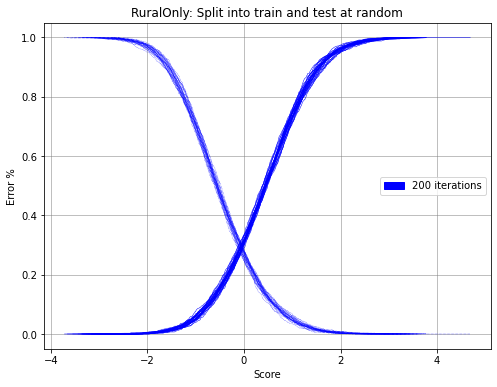

In [10]:
urban=False
area= 'Urban' if urban else 'Rural'
selector=df['urban']==urban
subData=D.get_subset(selector)
subD=DataSplitter(subData)

train_selector=np.random.rand(subData.shape[0]) > 0.3
Train=subD.get_subset(train_selector)
Test=subD.get_subset(~train_selector)

param['num_round']=200
log200=simple_bootstrap('xgb',Train,Test,param,ensemble_size=30)

styled_logs=[
    {   'log':log200,
        'style':['b:','b-'],
        'label':'200 iterations',
        'label_color':'b'
    }
]


_mean,_std=plot_scores(styled_logs,title=f'{area}Only: Split into train and test at random')

pickle_file=f'data/Checkpoint_{area}.pk'
Dump={'styled_logs':styled_logs,
     'tree':tree,
     'mean':_mean,
     'std':_std}
pkl.dump(Dump,open(pickle_file,'wb'))



In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

parameters = {
    # Parameters that we are going to tune.
    'eta':0.15,
    'max_depth': 3,
    'verbosity': 0,
    'nthread': 7,
    'num_rounds': 300,
    'objective':'binary:logistic',
}
gs_xgb, X = log200[-1]['bst'], log200[-1]['dtrain'] 

gridsearch_params = [
    (max_depth, num_rounds, eta/100)
    for max_depth in range(2,4)
    for num_rounds in range(50,250,50)
    for eta in range(10,35,5)
]

min_auc = float("Inf")
best_params = None
for max_depth, num_rounds, eta in gridsearch_params:
    print("CV with max_depth={}, num_rounds={}, eta={}".format(
                             max_depth, num_rounds, eta))
    # Update our parameters
    parameters['max_depth'] = max_depth
    parameters['num_rounds'] = num_rounds
    parameters['eta'] = eta
    
    # Run CV
    cv_results = gs_xgb.cv(
        parameters,
        dtrain,
        nfold=5,
        metrics={'auc','error','logloss'},
        early_stopping_rounds=10
    )
    # Update best MAE
    print(cv_results)
    mean_auc = cv_results['test-auc-mean'].min()
    boost_rounds = cv_results['test-auc-mean'].argmin()
    print("\tAUC {} for {} rounds".format(mean_auc, boost_rounds))
    if mean_auc < min_auc:
        min_auc = mean_auc
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, AUC: {}".format(best_params[0], best_params[1], min_auc))